# Lista de exercício 3

In [1]:
# Import all libraries to construct the model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
import multiprocessing as mp
import psutil
import time

Using TensorFlow backend.


In [2]:
data_path = 'wdbc.data'
df = pd.read_csv(data_path, header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [3]:
# Separating input data and targets
cols = [0, 1]
features, targets = df.drop(df.columns[cols],axis=1), df[1]

targets.replace('M', 1, inplace=True)
targets.replace('B', 0, inplace=True)

# Split datasets to train e test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30, random_state=42)

In [4]:
# Defining a function to get memory usage
def monitor(target):
    worker_process = mp.Process(target=target)
    worker_process.start()
    p = psutil.Process(worker_process.pid)
    return p.memory_info()[0]/1024/1024

In [5]:
# Create this class to keep state of Keras history and show additional informations, because I'm using a monitor to ge a used memory
class KerasHistory:

    def __init__(self):
        self.info = None
        self.memory_usage = 0
        self.elapsed = 0

In [6]:
# Function of training
def train(model, X, y, keras_history, epochs=100, batch_size=20, filepath="weights.best.hdf5"):
    start = time.time()
    # checkpoint
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(X, y, validation_split=0.20, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks_list)
    keras_history.info = history
    done = time.time()
    keras_history.elapsed = done - start

In [7]:
# Show info of model
def show_info(model, X, y, keras_history):
    # list all data in history
    #print(history.history.keys())

    # summarize history for accuracy
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['acc'])
    plt.plot(keras_history.info.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['loss'])
    plt.plot(keras_history.info.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Print memory usage
    print('Memory Usage {:2.2f} MB'.format(keras_history.memory_usage))
    
    print('Time of Processing {:4.2f}s'.format(keras_history.elapsed))
    
    score = model.evaluate(X, y, verbose=0)
    print('Accuracy {:2.2f}%'.format(score[1]*100))

In [28]:
# Building the model 1
model1 = Sequential()
model1.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model1.add(Dense(32, activation='tanh'))
model1.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model1.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model1.summary()

# Training the model 1
keras_history1 = KerasHistory()
memory_usage = monitor(target=train(model1, X_train, y_train, keras_history1))
keras_history1.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.2719 - acc: 0.5818 - val_loss: 0.2455 - val_acc: 0.6375
Epoch 2/100
 - 0s - loss: 0.2485 - acc: 0.6226 - val_loss: 0.2369 - val_acc: 0.6375
Epoch 3/100
 - 0s - loss: 0.2409 - acc: 0.6226 - val_loss: 0.2329 - val_acc: 0.6375
Epoch 4/100
 - 0s - loss: 0.2375 - acc: 0.6226 - val_loss: 0.2315 - val_acc: 0.6375
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2355 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 90/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 91/100
 - 0s - loss: 0.2356 - acc: 0.6226 - val_loss: 0.2313 - val_acc: 0.6375
Epoch 92/100
 - 0s - loss: 0.2355 - acc: 0.6226 - val_loss: 0.2313 - val_acc: 0.6375
Epoch 93/100
 - 0s - loss: 0.2352 - acc: 0.6226 - val_loss: 0.2315 - val_acc: 0.6375
Epoch 94/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2314 - val_acc: 0.6375
Epoch 95/100
 - 0s - loss: 0.2356 - acc: 0.6226 - val_loss: 0.2314 - val_acc: 0.6375
Epoch 96/100
 - 0s - loss: 0.2354 - acc: 0.6226 - val_loss: 0.2315 - val_acc: 0.6375
Epoch 97/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2314 - val_acc: 0.6375
Epoch 98/100
 - 0s - loss: 0.2355 - acc: 0.6226 - val_loss: 0.2313 - val_acc: 0.6375
Epoch 99/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2313 - val_acc: 0.6375
Epoch 100/100
 - 0s - loss: 0.2354 - acc: 0.6226 - val_loss: 0.23

## Respostas da questão 1

## Treinamento 1
Para o treinamento 1 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

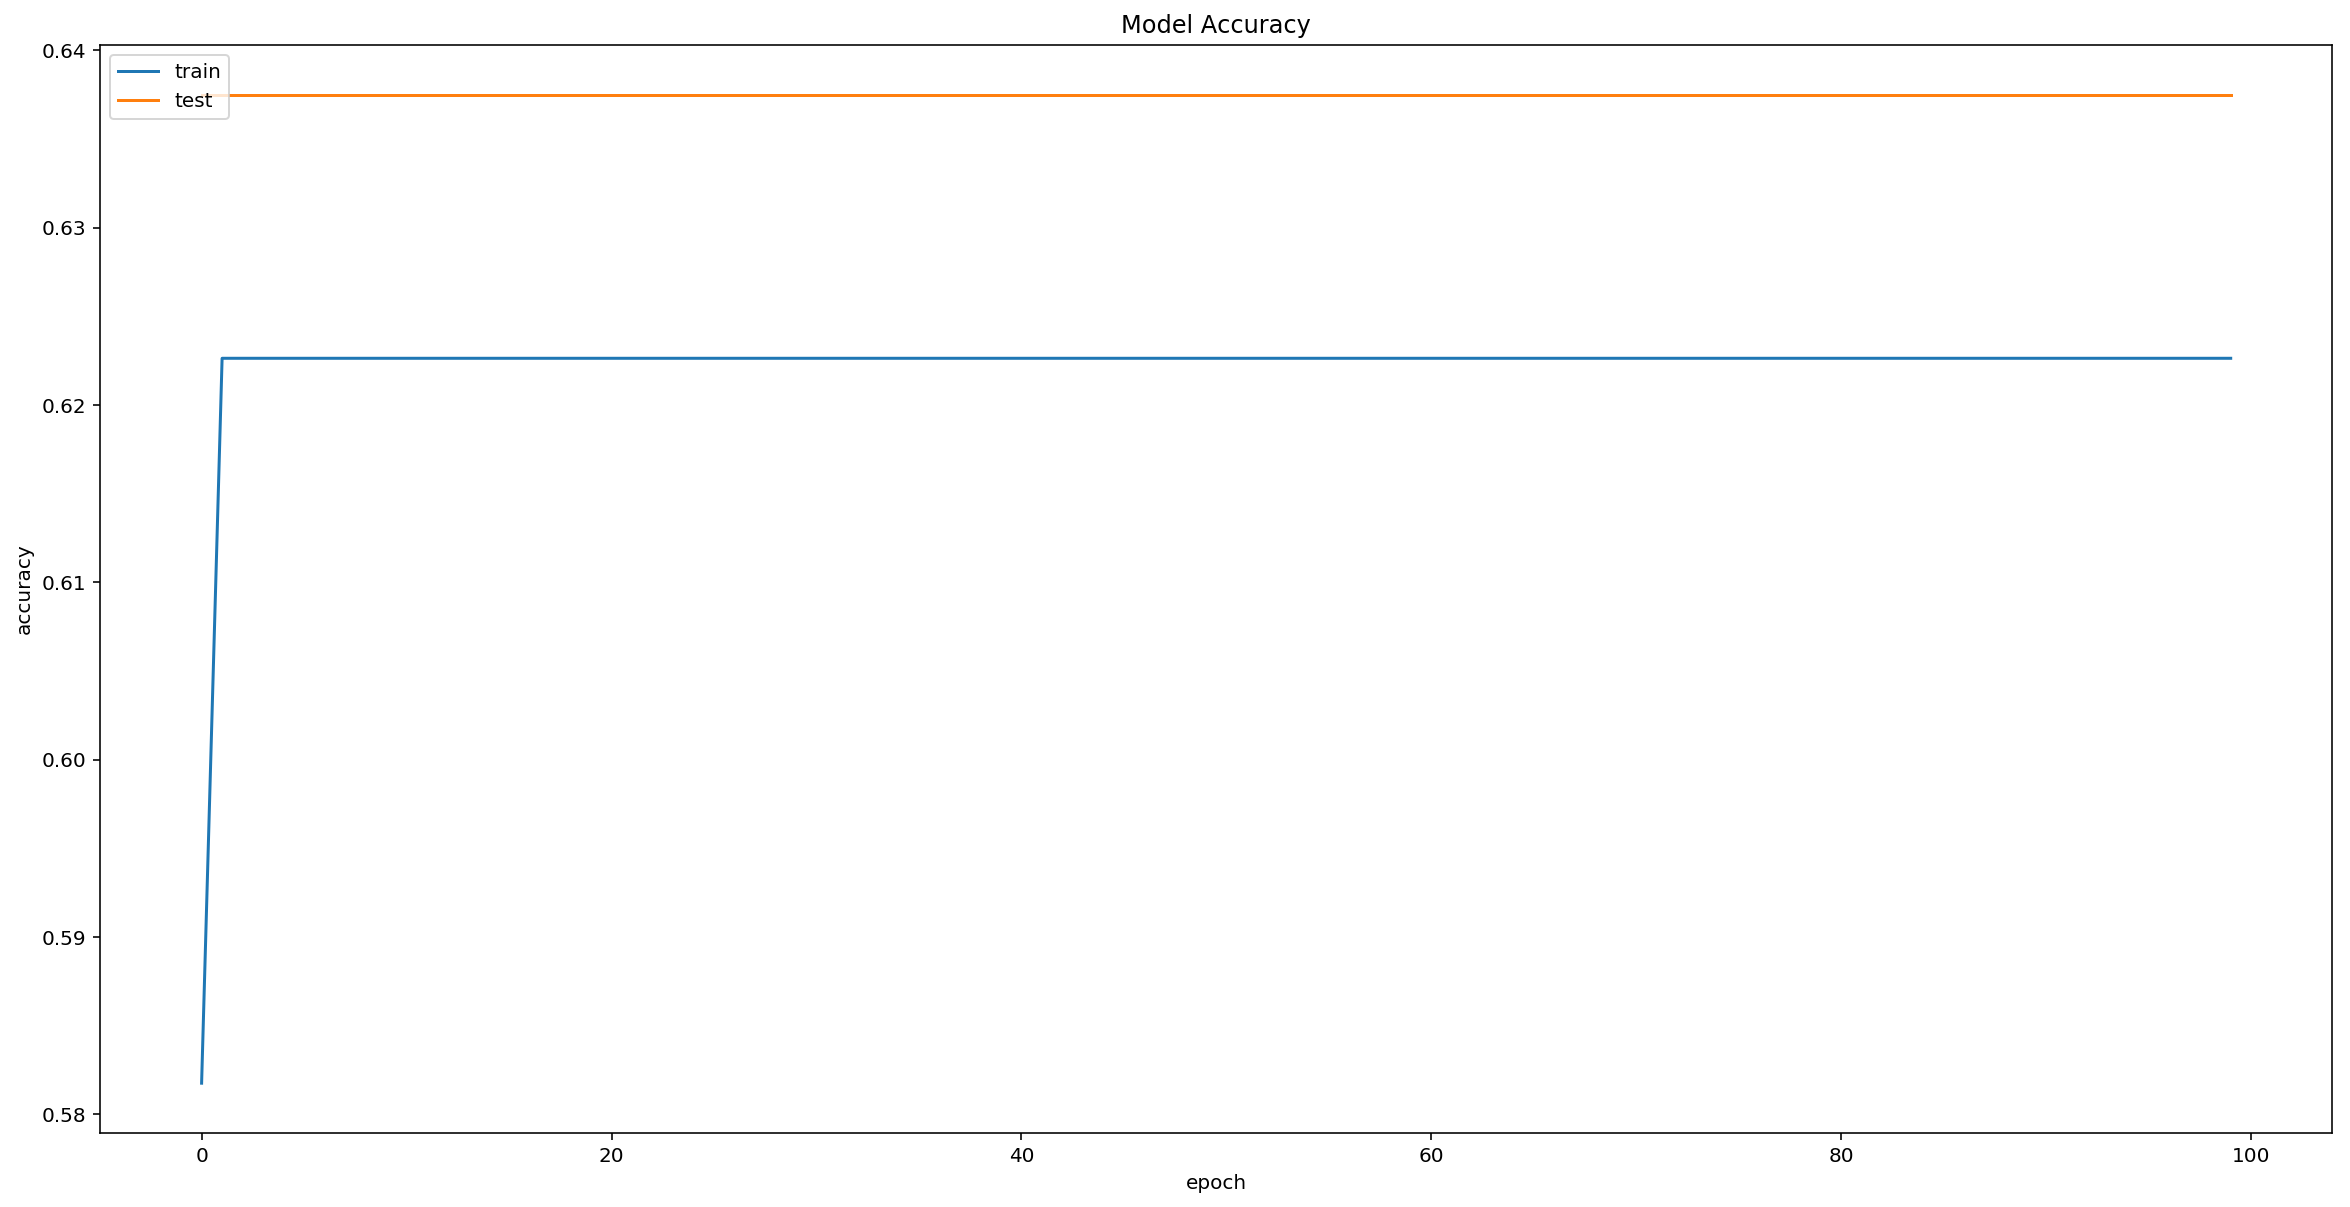

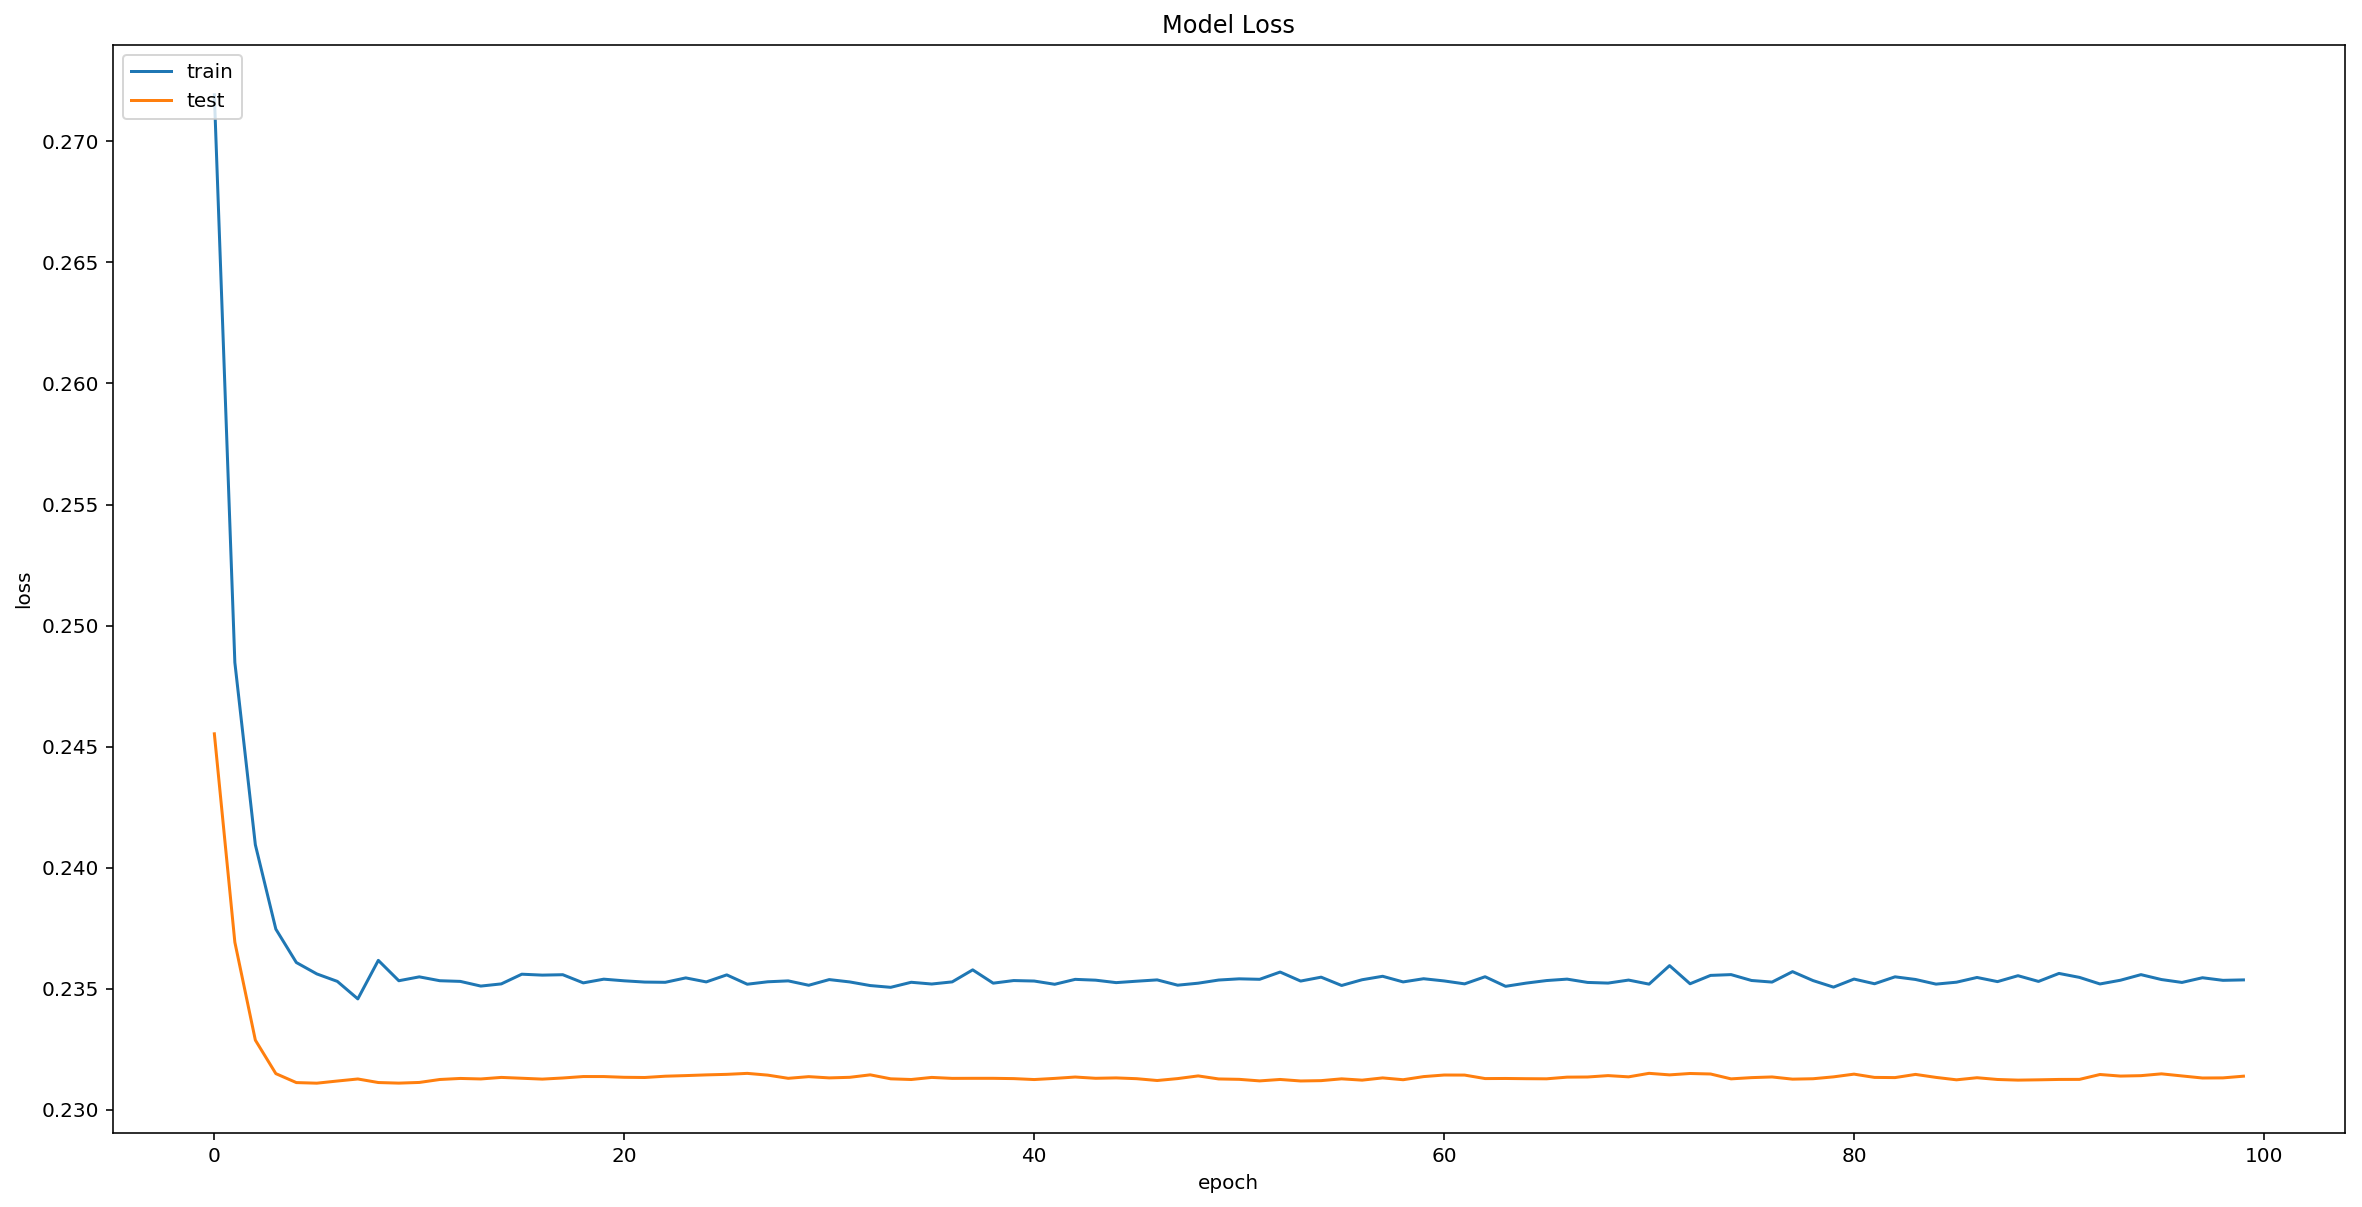

Memory Usage 0.15 MB
Time of Processing 2.98s
Accuracy 63.16%


In [29]:
show_info(model1, X_test, y_test, keras_history1)

In [30]:
# Building the model 2
model2 = Sequential()
model2.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model2.add(Dense(32, activation='sigmoid'))
model2.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model2.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Training the model 2
keras_history2 = KerasHistory()
memory_usage = monitor(target=train(model2, X_train, y_train, keras_history2))
keras_history2.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.2433 - acc: 0.5943 - val_loss: 0.2233 - val_acc: 0.6375
Epoch 2/100
 - 0s - loss: 0.2235 - acc: 0.6226 - val_loss: 0.2178 - val_acc: 0.6375
Epoch 3/100
 - 0s - loss: 0.2095 - acc: 0.6226 - val_loss: 0.2021 - val_acc: 0.6375
Epoch 4/100
 - 0s - loss: 0.2098 - acc: 0.6226 - val_loss: 0.2157 - val_acc: 0.6375
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.0681 - acc: 0.9119 - val_loss: 0.0658 - val_acc: 0.9000
Epoch 90/100
 - 0s - loss: 0.0656 - acc: 0.9151 - val_loss: 0.0720 - val_acc: 0.9000
Epoch 91/100
 - 0s - loss: 0.0723 - acc: 0.9088 - val_loss: 0.0868 - val_acc: 0.8750
Epoch 92/100
 - 0s - loss: 0.0679 - acc: 0.9119 - val_loss: 0.0717 - val_acc: 0.9000
Epoch 93/100
 - 0s - loss: 0.0671 - acc: 0.9088 - val_loss: 0.0687 - val_acc: 0.9000
Epoch 94/100
 - 0s - loss: 0.0615 - acc: 0.9151 - val_loss: 0.0682 - val_acc: 0.8875
Epoch 95/100
 - 0s - loss: 0.0653 - acc: 0.9088 - val_loss: 0.0693 - val_acc: 0.9125
Epoch 96/100
 - 0s - loss: 0.0667 - acc: 0.9151 - val_loss: 0.0725 - val_acc: 0.9125
Epoch 97/100
 - 0s - loss: 0.0653 - acc: 0.9245 - val_loss: 0.0747 - val_acc: 0.9000
Epoch 98/100
 - 0s - loss: 0.0670 - acc: 0.9151 - val_loss: 0.0757 - val_acc: 0.9125
Epoch 99/100
 - 0s - loss: 0.0701 - acc: 0.9088 - val_loss: 0.0716 - val_acc: 0.9125
Epoch 100/100
 - 0s - loss: 0.0604 - acc: 0.9119 - val_loss: 0.06

## Treinamento 2
Para o treinamento 2 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a sigmóide como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

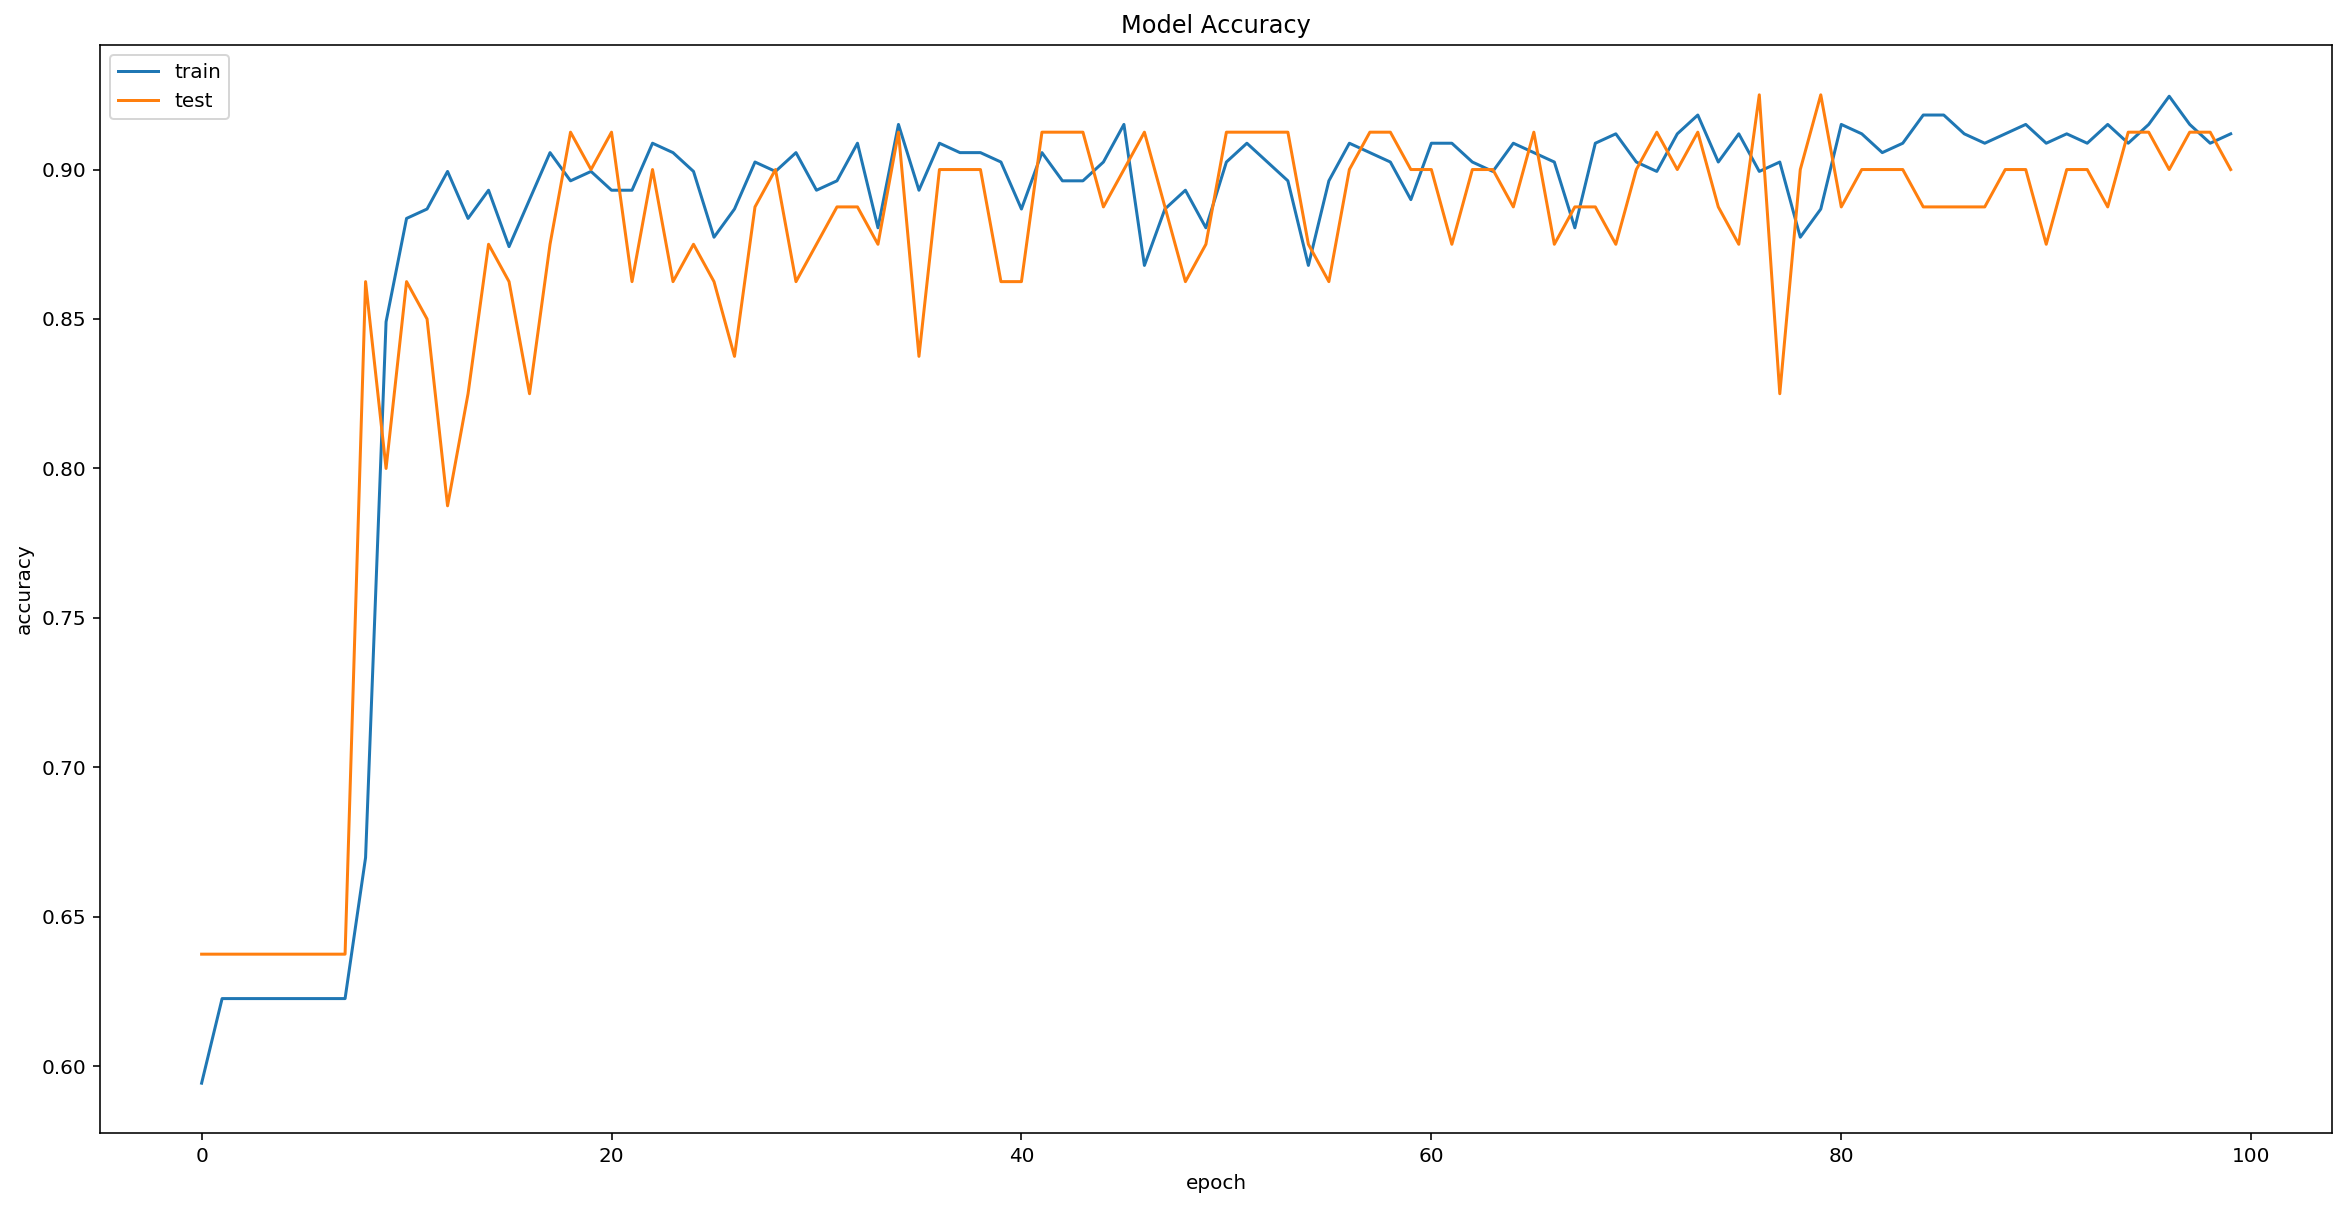

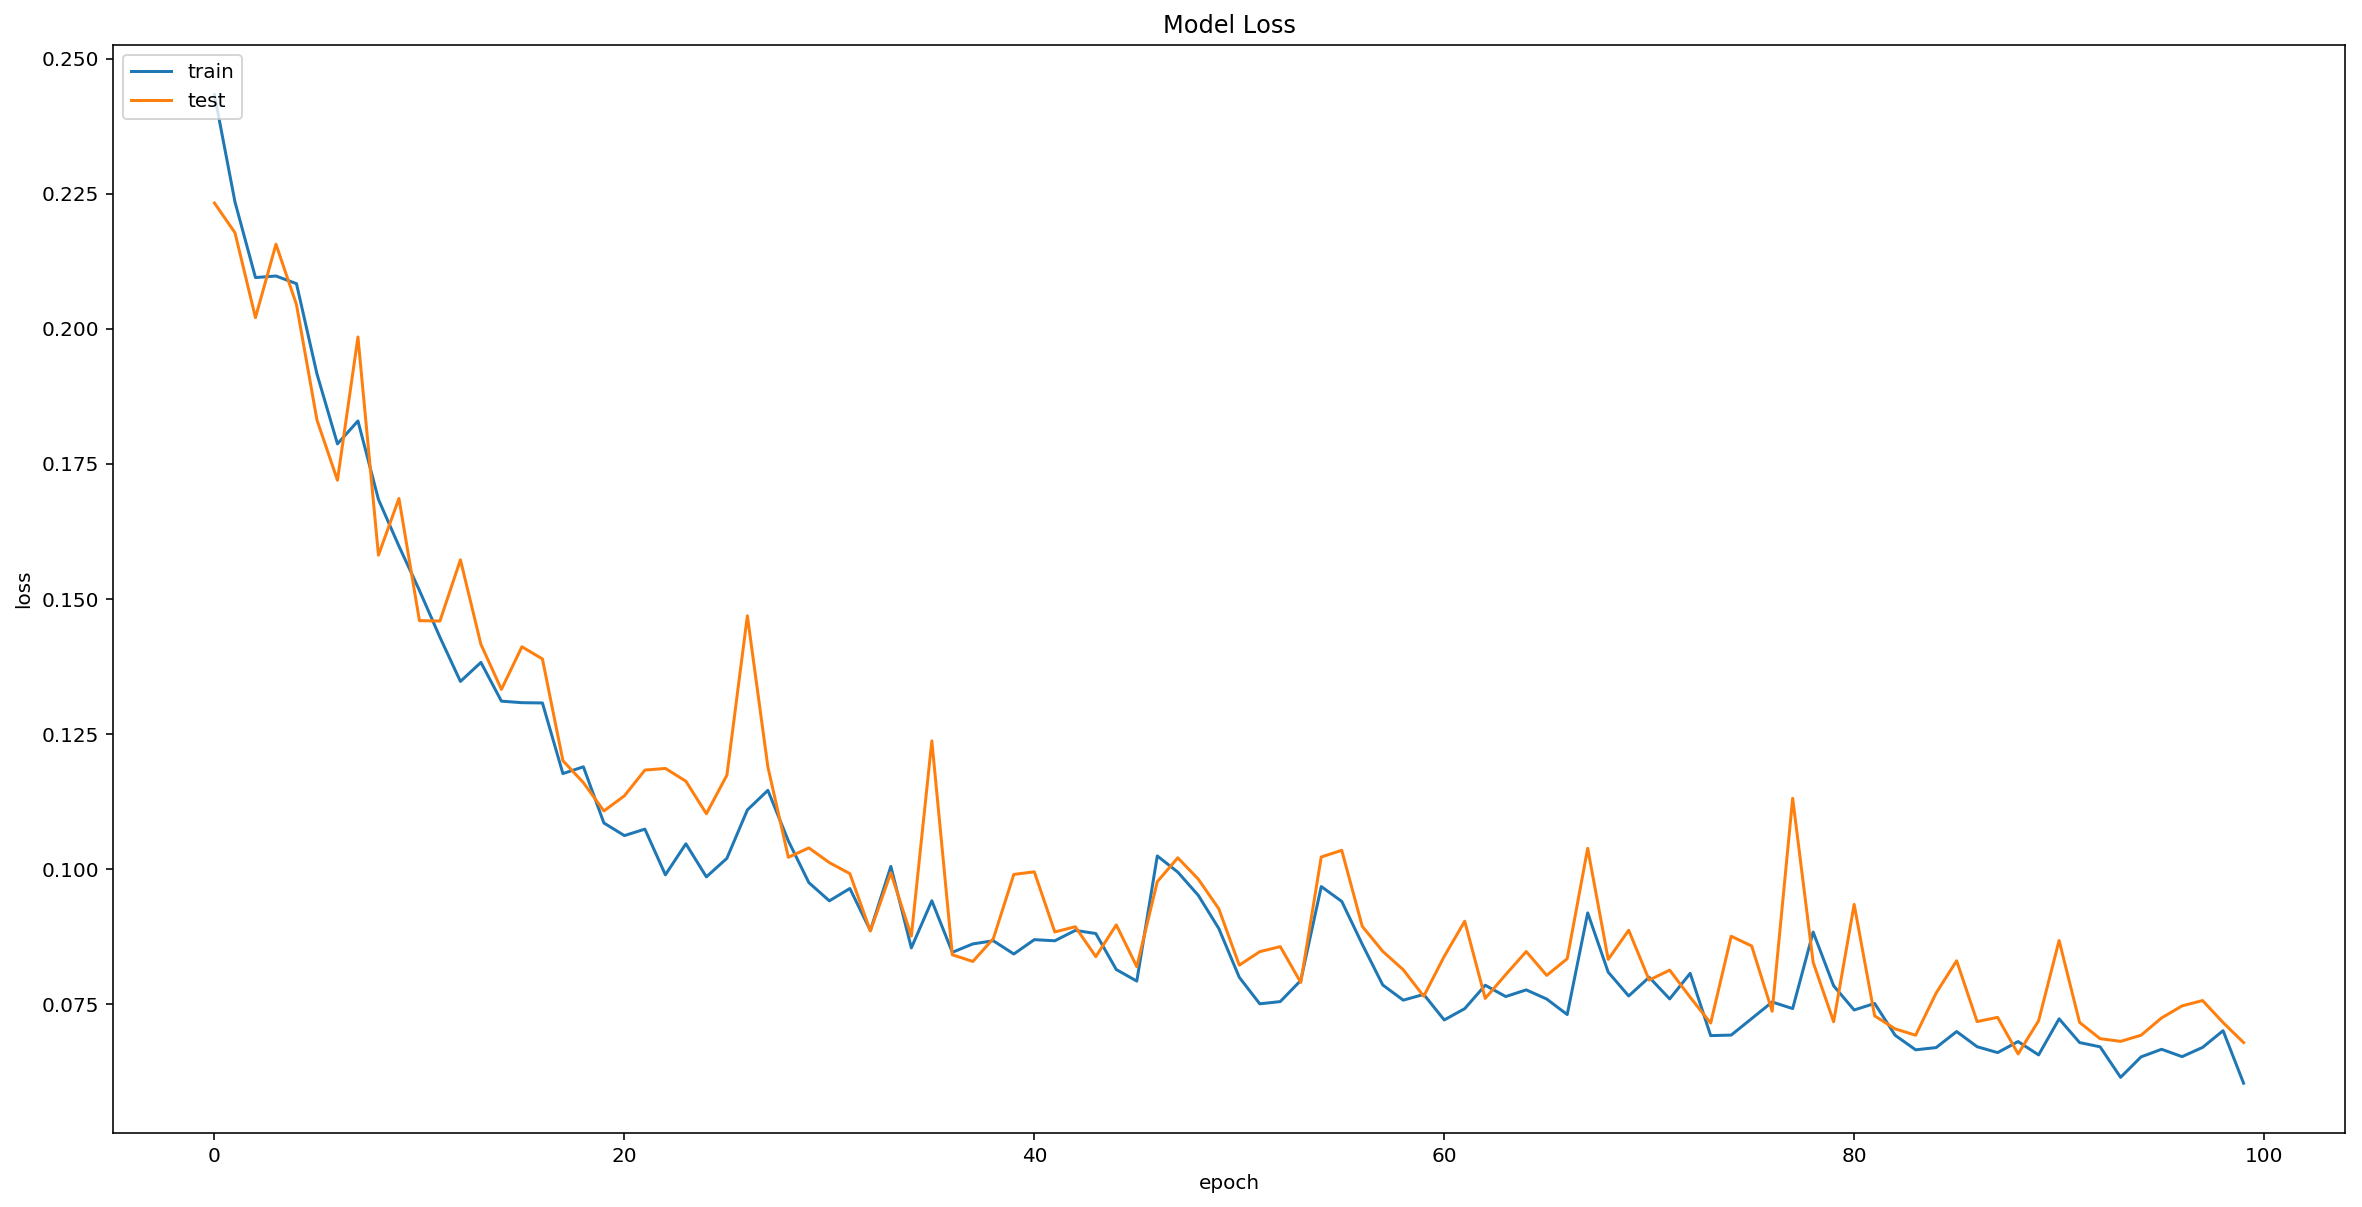

Memory Usage 1.21 MB
Time of Processing 4.04s
Accuracy 97.66%


In [31]:
show_info(model2, X_test, y_test, keras_history2)

In [32]:
# Building the model 3
model3 = Sequential()
model3.add(Dense(64, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model3.add(Dense(32, activation='tanh'))
model3.add(Dense(1, activation='tanh'))

# Compile model with loss function, optmizer and metrics
model3.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model3.summary()

# Training the model 3
keras_history3 = KerasHistory()
memory_usage = monitor(target=train(model3, X_train, y_train, keras_history3))
keras_history3.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/100
 - 0s - loss: 0.3541 - acc: 0.6101 - val_loss: 0.2612 - val_acc: 0.6375
Epoch 2/100
 - 0s - loss: 0.2414 - acc: 0.6226 - val_loss: 0.2522 - val_acc: 0.6375
Epoch 3/100
 - 0s - loss: 0.2465 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 4/100
 - 0s - loss: 0.2351 - acc: 0.6226 - val_loss: 0.2338 - val_acc: 0.6375
Epoch 5/100
 - 0s - los

Epoch 89/100
 - 0s - loss: 0.2357 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 90/100
 - 0s - loss: 0.2352 - acc: 0.6226 - val_loss: 0.2323 - val_acc: 0.6375
Epoch 91/100
 - 0s - loss: 0.2352 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 92/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 93/100
 - 0s - loss: 0.2356 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 94/100
 - 0s - loss: 0.2353 - acc: 0.6226 - val_loss: 0.2321 - val_acc: 0.6375
Epoch 95/100
 - 0s - loss: 0.2355 - acc: 0.6226 - val_loss: 0.2314 - val_acc: 0.6375
Epoch 96/100
 - 0s - loss: 0.2358 - acc: 0.6226 - val_loss: 0.2314 - val_acc: 0.6375
Epoch 97/100
 - 0s - loss: 0.2385 - acc: 0.6226 - val_loss: 0.2315 - val_acc: 0.6375
Epoch 98/100
 - 0s - loss: 0.2366 - acc: 0.6226 - val_loss: 0.2339 - val_acc: 0.6375
Epoch 99/100
 - 0s - loss: 0.2369 - acc: 0.6226 - val_loss: 0.2312 - val_acc: 0.6375
Epoch 100/100
 - 0s - loss: 0.2361 - acc: 0.6226 - val_loss: 0.23

## Treinamento 3
Para o treinamento 3 foram utilizados os seguintes hiperparametros:

Épocas = 100

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 64 e a segunda com 32 e a camada de saída com dois neurônios. Na primeira e na segunda camada utilizei a tangente hiperbólica como função de ativação. Nesse treinamento ao invés de utilizar o SGD como otimizador da função de perda, utilizei o Adam.

Nesse ciclo podemos observar os resultados abaixo:

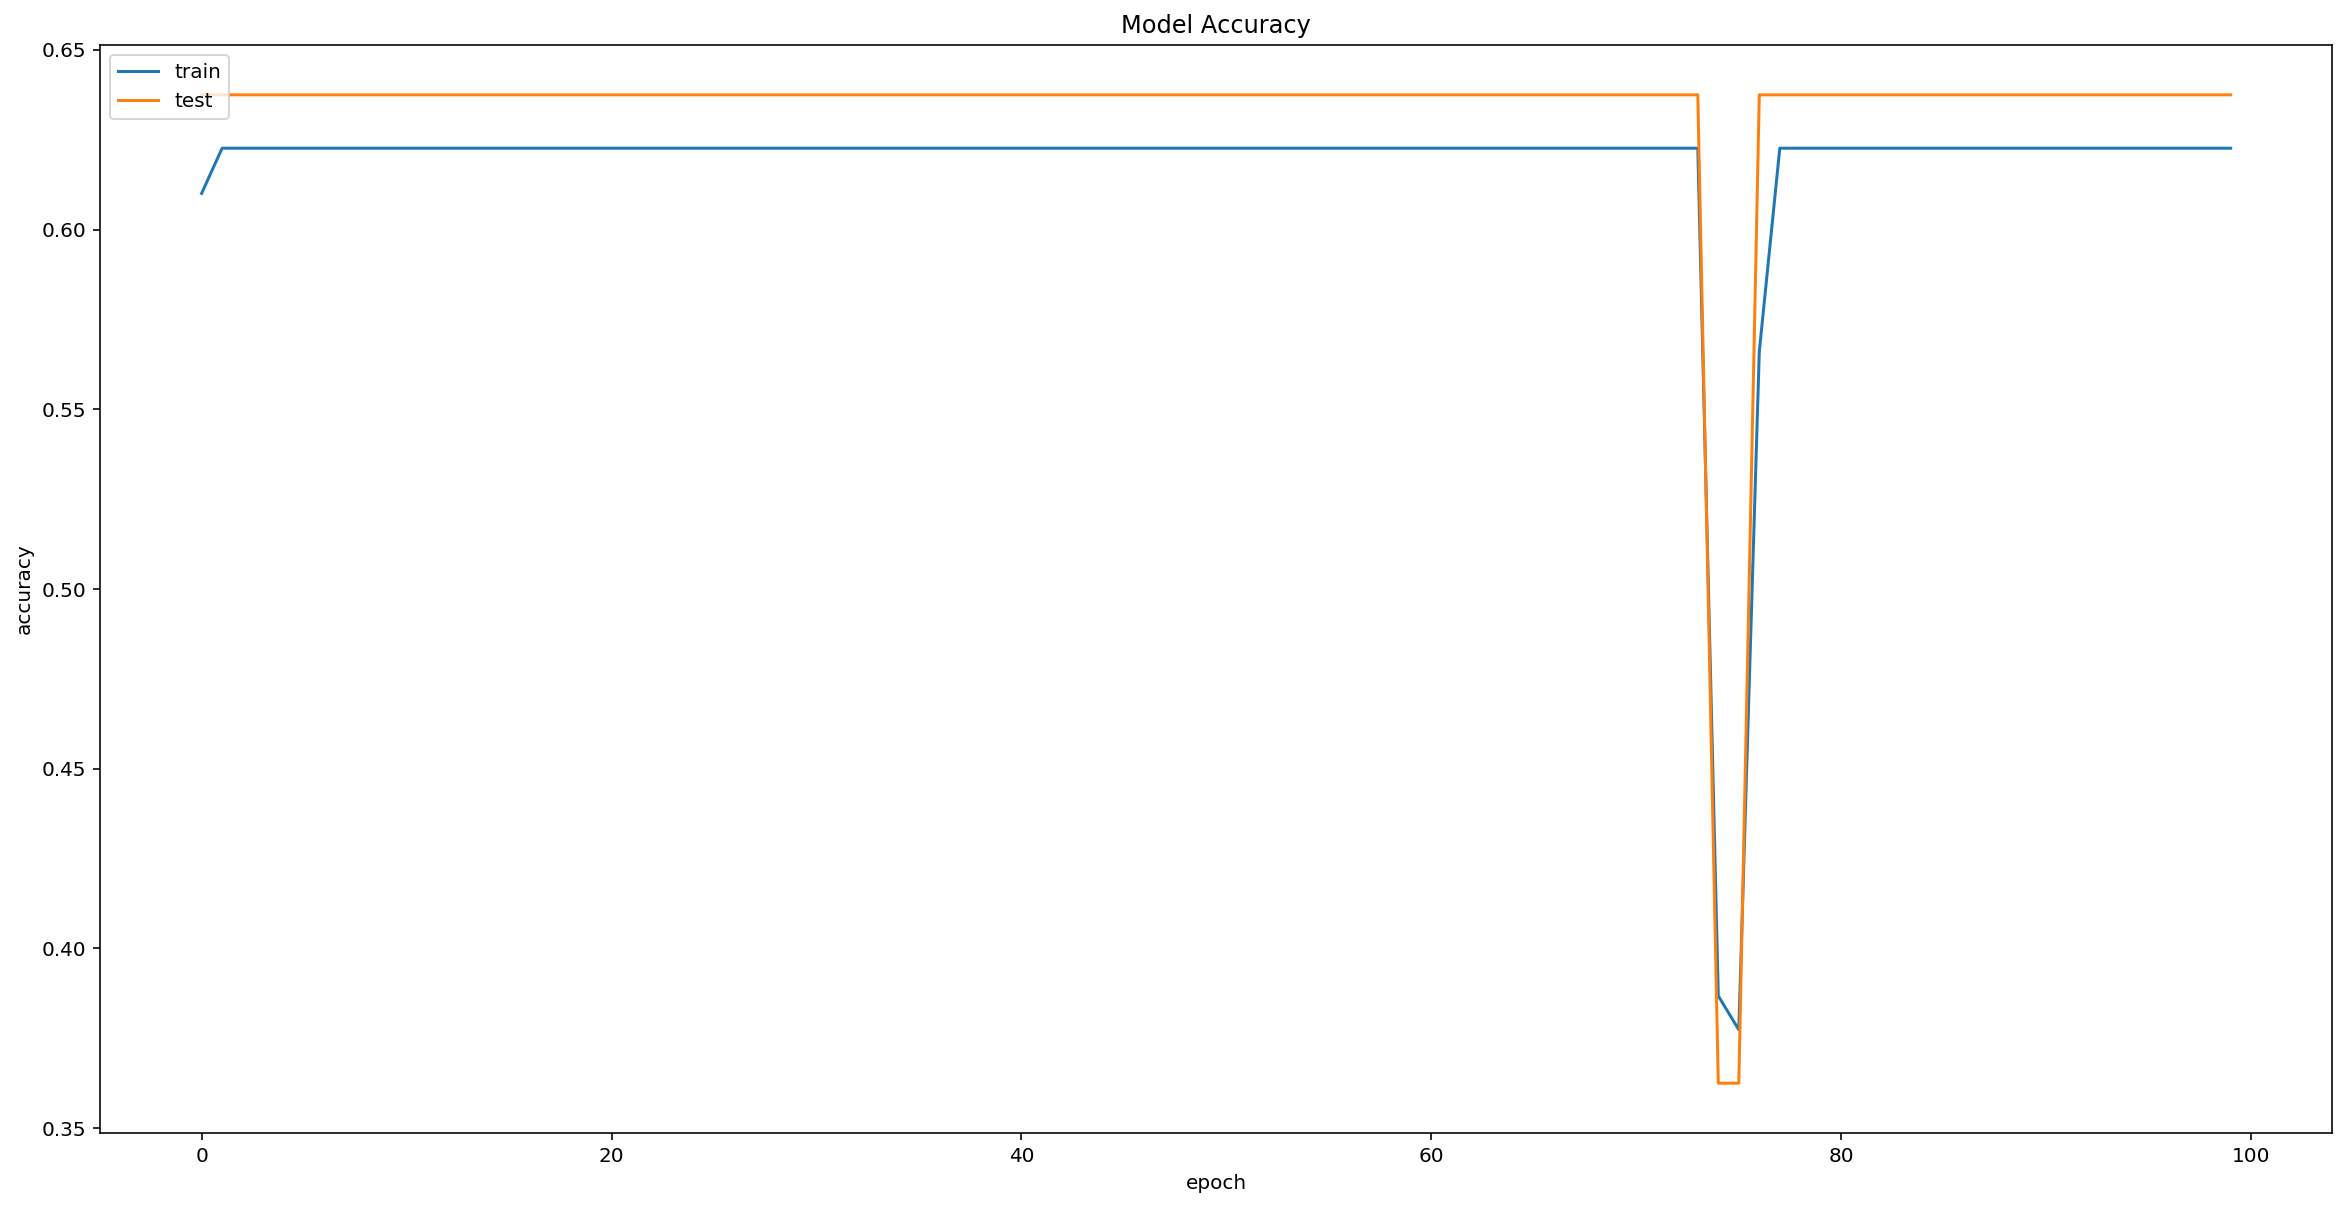

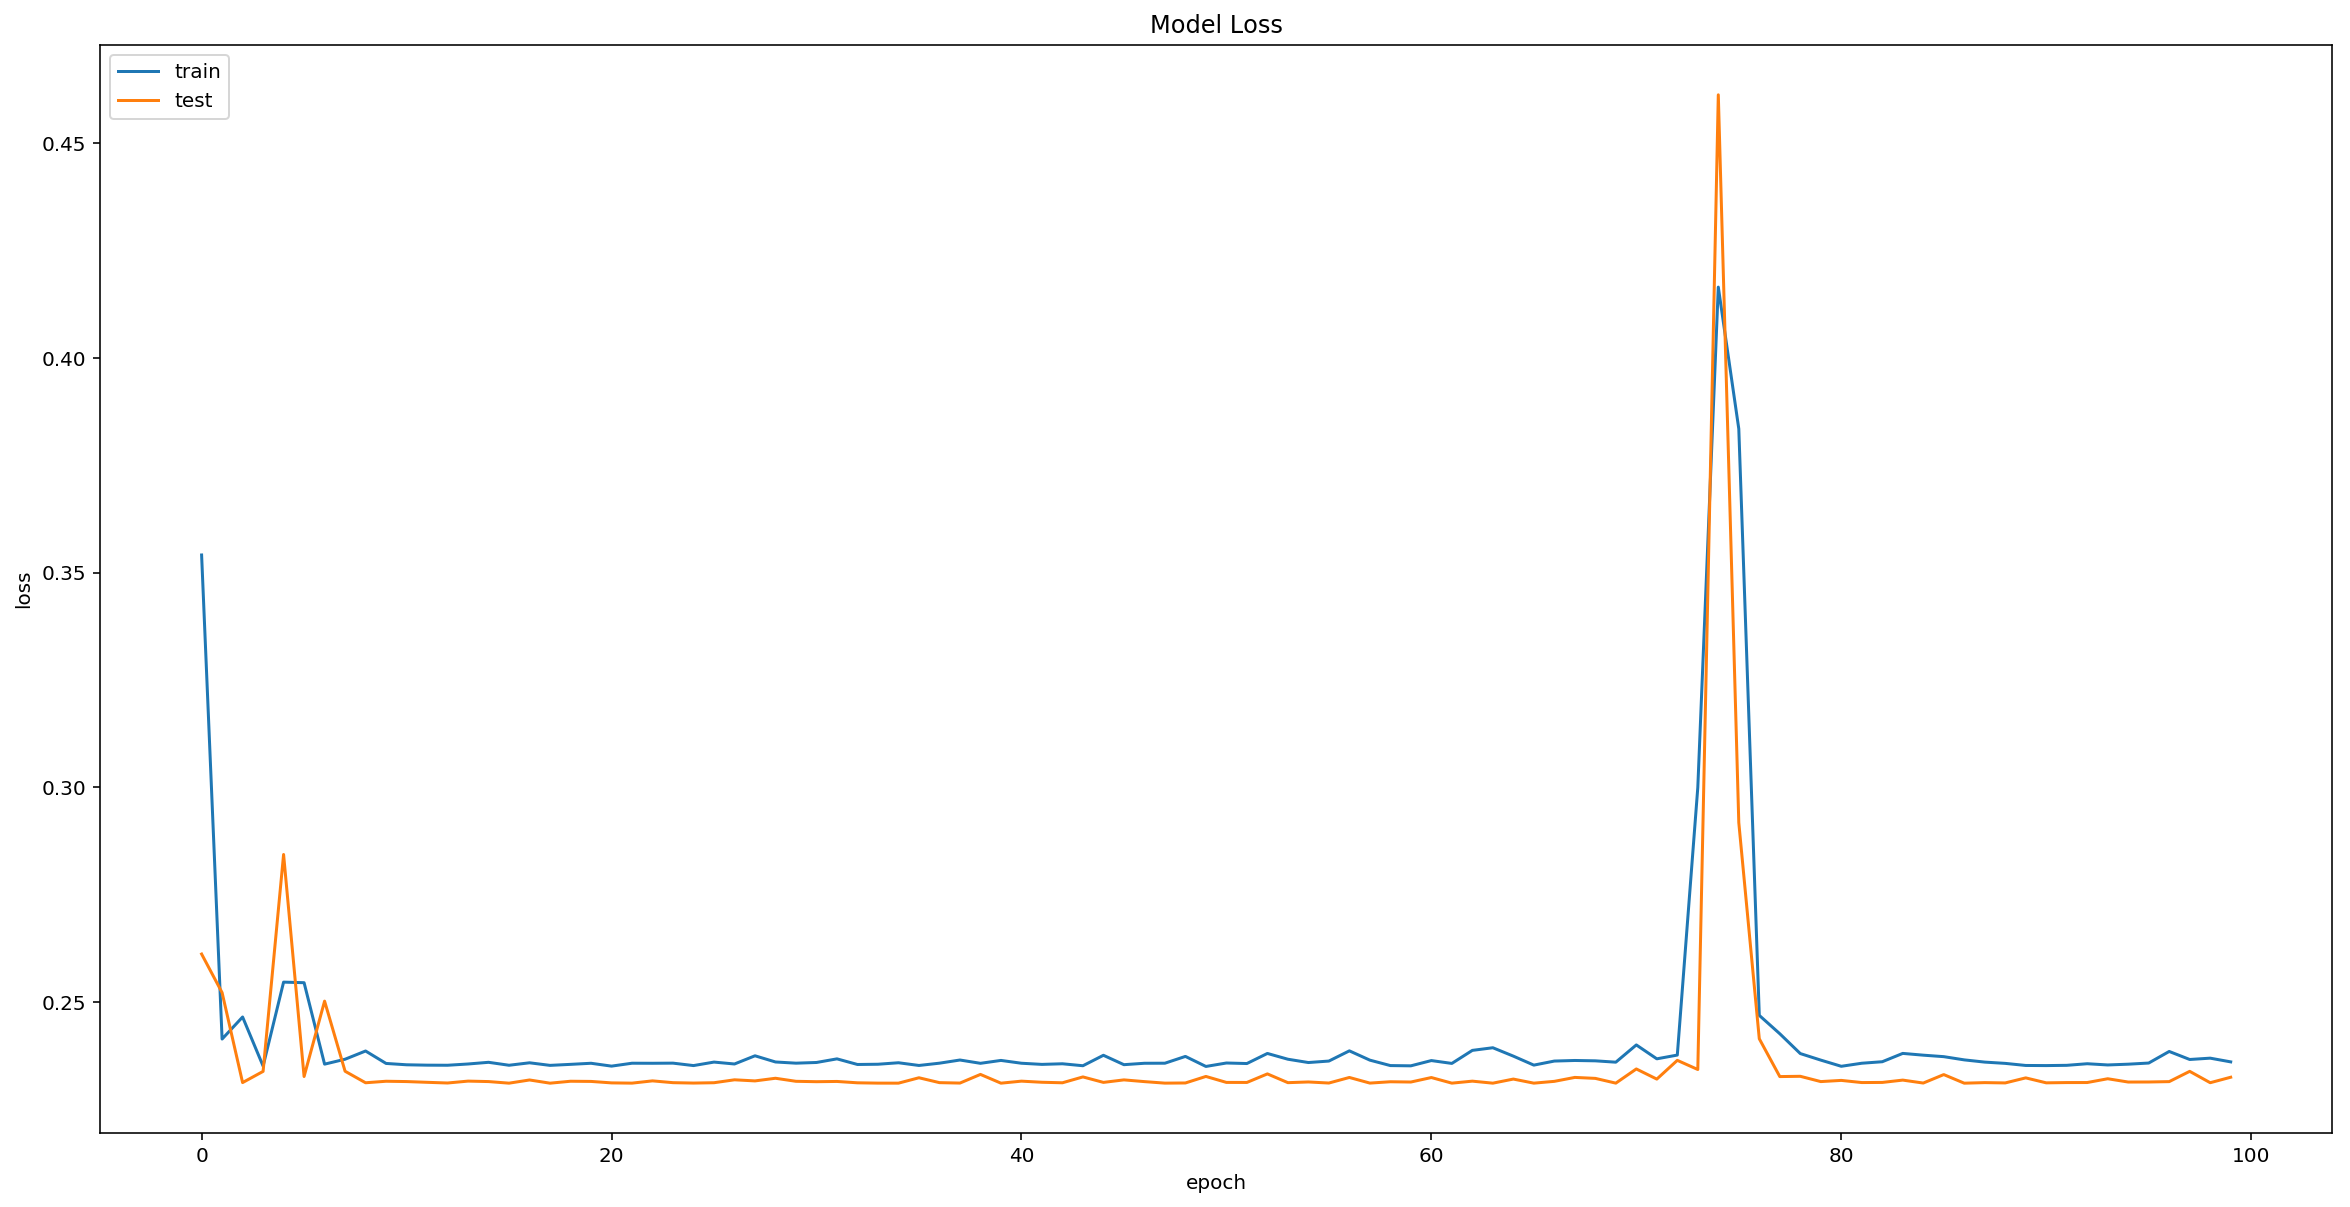

Memory Usage 1.64 MB
Time of Processing 3.89s
Accuracy 63.16%


In [33]:
show_info(model3, X_test, y_test, keras_history3)

In [8]:
# Normalization of data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [37]:
# Building the model 4
model4 = Sequential()
model4.add(Dense(32, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='zeros'))
model4.add(Dense(16, activation='tanh'))
model4.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model4.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model4.summary()

# Training the model 4
keras_history4 = KerasHistory()
memory_usage = monitor(target=train(model4, X_train_norm, y_train, keras_history4, epochs=50))
keras_history4.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/50
 - 0s - loss: 0.2116 - acc: 0.8050 - val_loss: 0.1739 - val_acc: 0.9000
Epoch 2/50
 - 0s - loss: 0.1598 - acc: 0.9151 - val_loss: 0.1369 - val_acc: 0.9500
Epoch 3/50
 - 0s - loss: 0.1304 - acc: 0.9214 - val_loss: 0.1149 - val_acc: 0.9500
Epoch 4/50
 - 0s - loss: 0.1117 - acc: 0.9308 - val_loss: 0.1003 - val_acc: 0.9625
Epoch 5/50
 - 0s - loss: 0.

## Treinamento 4
Para o treinamento 4 foram utilizados os seguintes hiperparametros:

Épocas = 50

Batchsize = 20

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 32 e a segunda com 16 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Uma técnica utilizada nesse caso foi normalizar os dados, com isso foi possível diminuir o número de neurônios nas camadas ocultas, o número de épocas foi a metade e a precisão do modelo melhorou.

Nesse ciclo podemos observar os resultados abaixo:

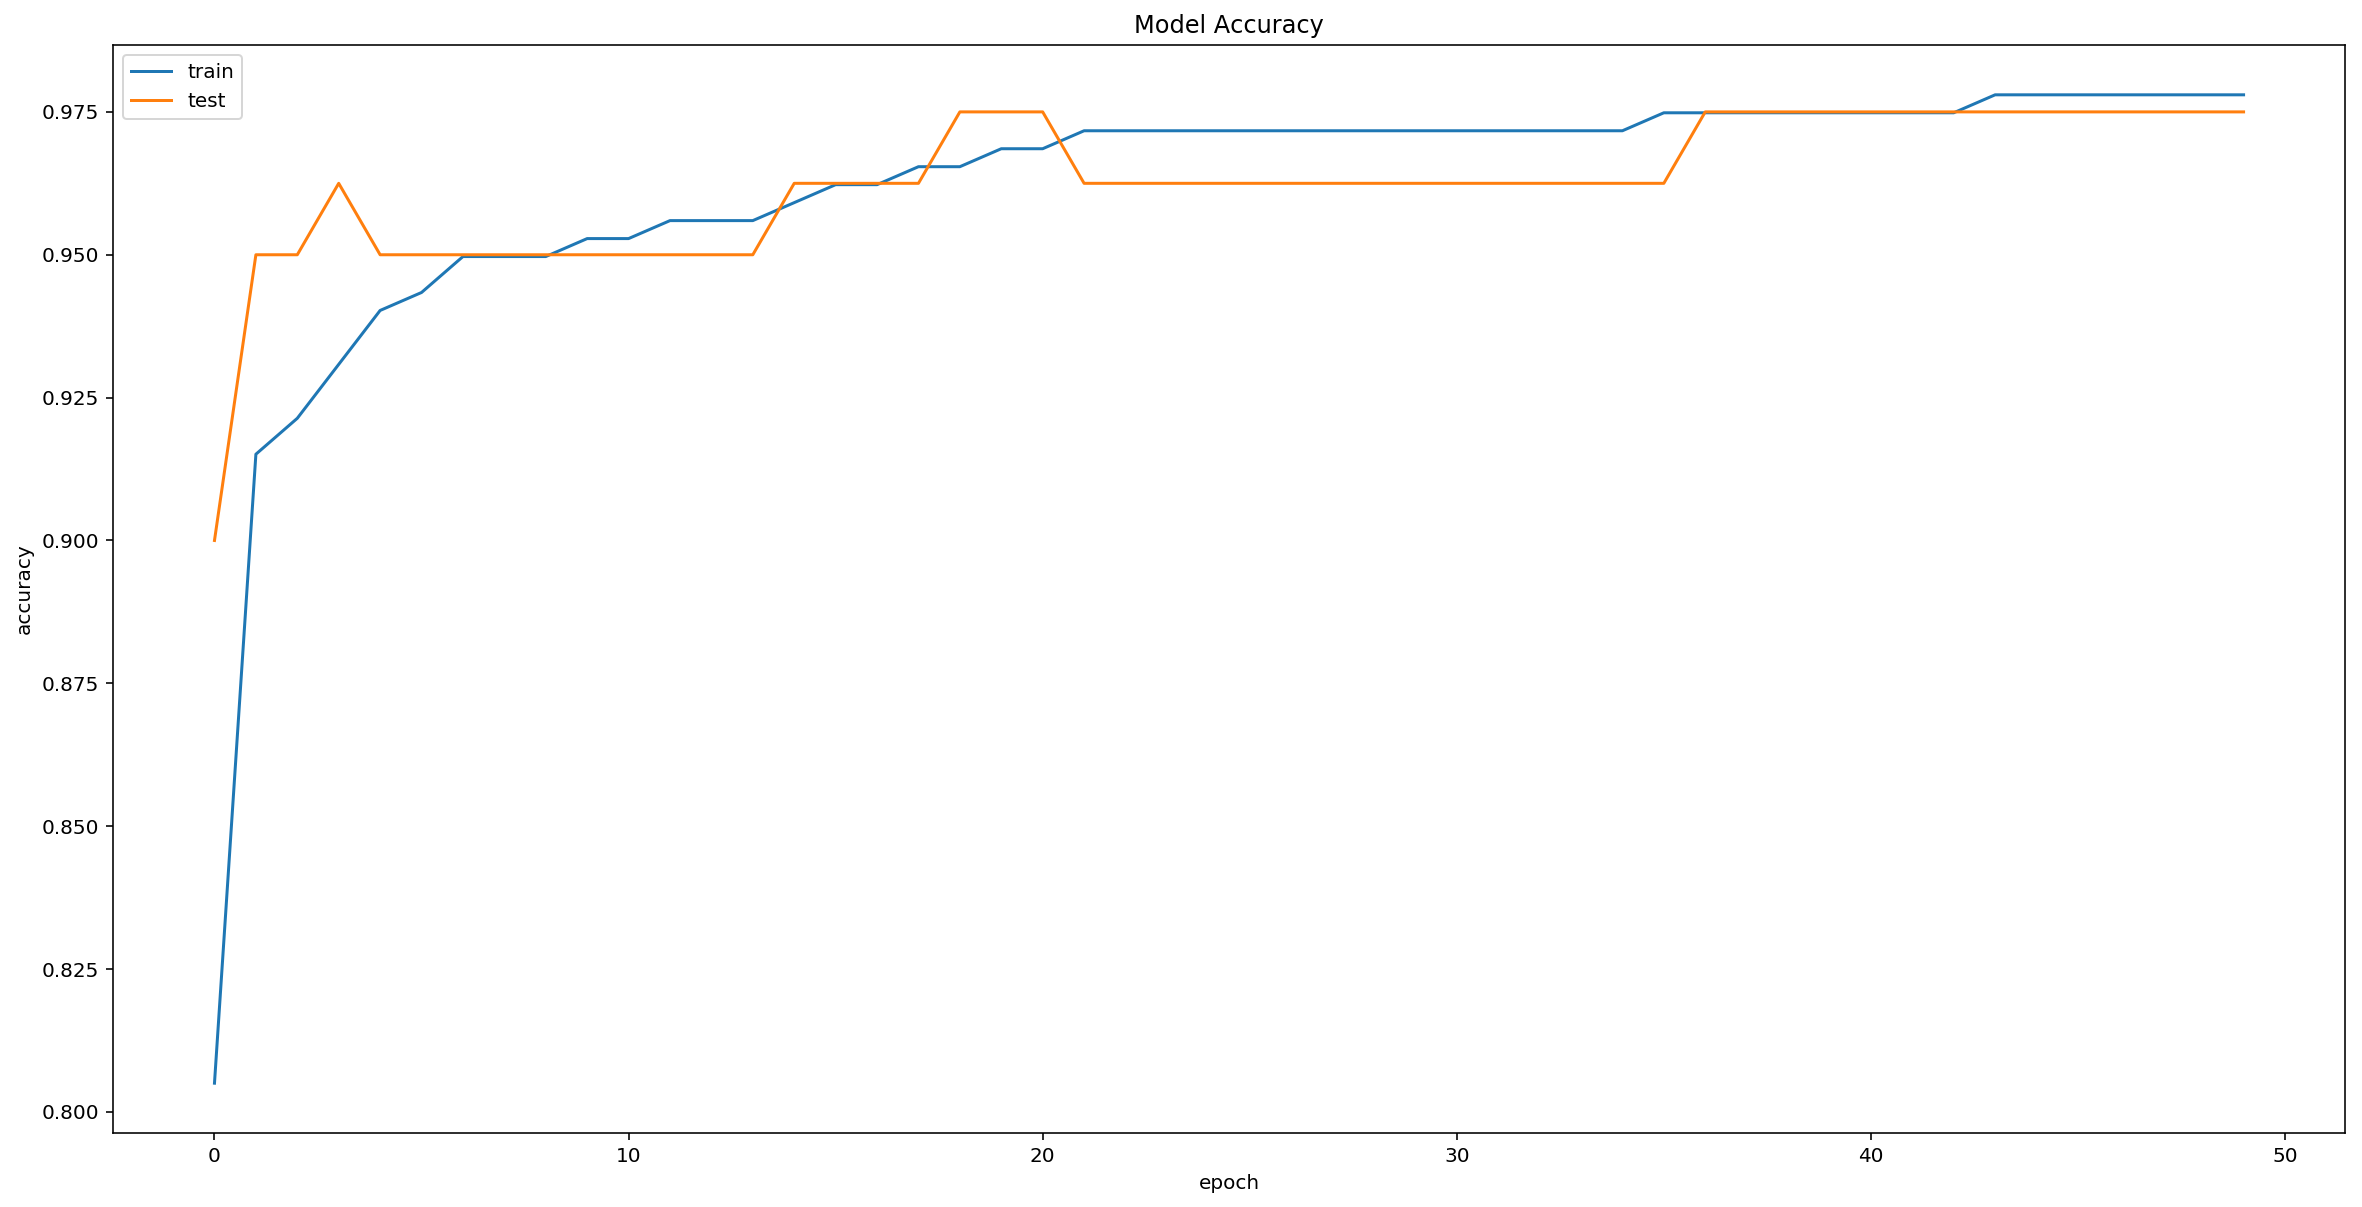

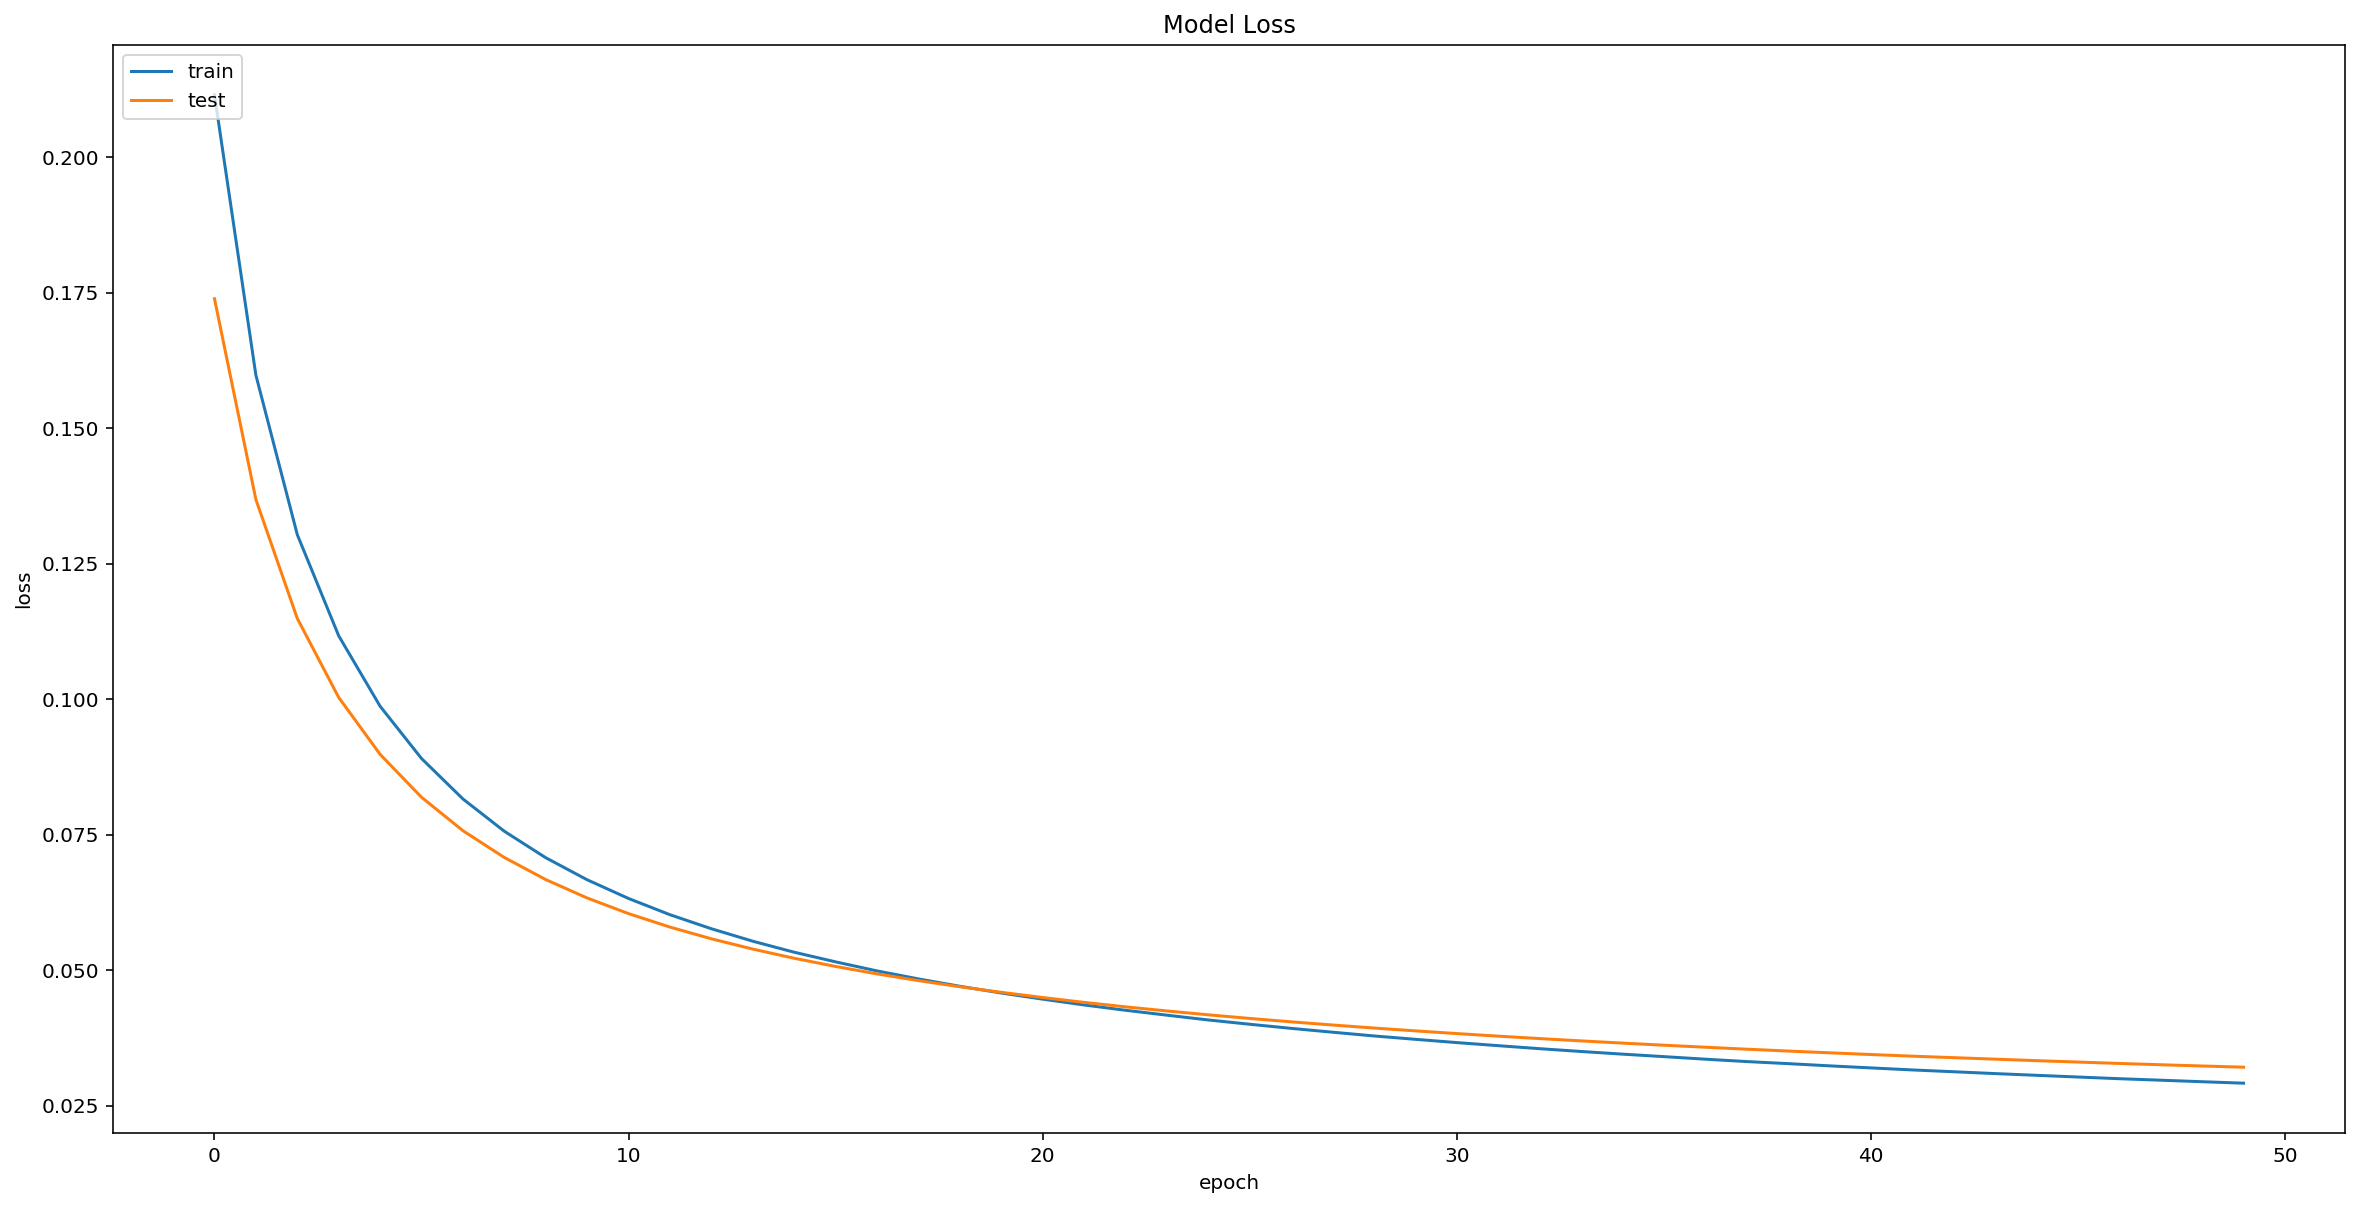

Memory Usage 0.15 MB
Time of Processing 1.79s
Accuracy 98.83%


In [38]:
show_info(model4, X_test_norm, y_test, keras_history4)

In [39]:
# Building the model 5
model5 = Sequential()
model5.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model5.add(Dense(64, activation='tanh'))
model5.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model5.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model5.summary()

# Training the model 5
keras_history5 = KerasHistory()
memory_usage = monitor(target=train(model5, X_train_norm, y_train, keras_history5, epochs=1000, batch_size=10))
keras_history5.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/1000
 - 0s - loss: 0.1384 - acc: 0.8711 - val_loss: 0.0965 - val_acc: 0.9250
Epoch 2/1000
 - 0s - loss: 0.0793 - acc: 0.9497 - val_loss: 0.0711 - val_acc: 0.9375
Epoch 3/1000
 - 0s - loss: 0.0624 - acc: 0.9591 - val_loss: 0.0602 - val_acc: 0.9625
Epoch 4/1000
 - 0s - loss: 0.0534 - acc: 0.9591 - val_loss: 0.0538 - val_acc: 0.9625
Epoch 5/1000
 - 0

Epoch 88/1000
 - 0s - loss: 0.0164 - acc: 0.9843 - val_loss: 0.0223 - val_acc: 0.9625
Epoch 89/1000
 - 0s - loss: 0.0163 - acc: 0.9843 - val_loss: 0.0222 - val_acc: 0.9625
Epoch 90/1000
 - 0s - loss: 0.0163 - acc: 0.9843 - val_loss: 0.0221 - val_acc: 0.9625
Epoch 91/1000
 - 0s - loss: 0.0162 - acc: 0.9843 - val_loss: 0.0221 - val_acc: 0.9625
Epoch 92/1000
 - 0s - loss: 0.0162 - acc: 0.9843 - val_loss: 0.0220 - val_acc: 0.9625
Epoch 93/1000
 - 0s - loss: 0.0161 - acc: 0.9843 - val_loss: 0.0219 - val_acc: 0.9625
Epoch 94/1000
 - 0s - loss: 0.0161 - acc: 0.9843 - val_loss: 0.0218 - val_acc: 0.9625
Epoch 95/1000
 - 0s - loss: 0.0160 - acc: 0.9843 - val_loss: 0.0218 - val_acc: 0.9625
Epoch 96/1000
 - 0s - loss: 0.0159 - acc: 0.9843 - val_loss: 0.0217 - val_acc: 0.9625
Epoch 97/1000
 - 0s - loss: 0.0159 - acc: 0.9843 - val_loss: 0.0217 - val_acc: 0.9625
Epoch 98/1000
 - 0s - loss: 0.0159 - acc: 0.9843 - val_loss: 0.0216 - val_acc: 0.9625
Epoch 99/1000
 - 0s - loss: 0.0158 - acc: 0.9843 - val

Epoch 183/1000
 - 0s - loss: 0.0128 - acc: 0.9874 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 184/1000
 - 0s - loss: 0.0128 - acc: 0.9874 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 185/1000
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 186/1000
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 187/1000
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 188/1000
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 189/1000
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 190/1000
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0206 - val_acc: 0.9750
Epoch 191/1000
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 192/1000
 - 0s - loss: 0.0125 - acc: 0.9874 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 193/1000
 - 0s - loss: 0.0125 - acc: 0.9874 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 194/1000
 - 0s - loss: 0.0125 - acc: 

 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0239 - val_acc: 0.9625
Epoch 278/1000
 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 279/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0240 - val_acc: 0.9625
Epoch 280/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 281/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 282/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 283/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 284/1000
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 285/1000
 - 0s - loss: 0.0104 - acc: 0.9874 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 286/1000
 - 0s - loss: 0.0104 - acc: 0.9874 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 287/1000
 - 0s - loss: 0.0104 - acc: 0.9874 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 288/1000
 - 0s - loss: 0.0104 - acc: 0.9874 - val_lo

Epoch 372/1000
 - 0s - loss: 0.0091 - acc: 0.9906 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 373/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0264 - val_acc: 0.9625
Epoch 374/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0264 - val_acc: 0.9625
Epoch 375/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 376/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0264 - val_acc: 0.9625
Epoch 377/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0265 - val_acc: 0.9625
Epoch 378/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0266 - val_acc: 0.9625
Epoch 379/1000
 - 0s - loss: 0.0090 - acc: 0.9906 - val_loss: 0.0268 - val_acc: 0.9625
Epoch 380/1000
 - 0s - loss: 0.0089 - acc: 0.9906 - val_loss: 0.0269 - val_acc: 0.9625
Epoch 381/1000
 - 0s - loss: 0.0089 - acc: 0.9906 - val_loss: 0.0269 - val_acc: 0.9625
Epoch 382/1000
 - 0s - loss: 0.0089 - acc: 0.9906 - val_loss: 0.0268 - val_acc: 0.9625
Epoch 383/1000
 - 0s - loss: 0.0089 - acc: 

 - 0s - loss: 0.0080 - acc: 0.9937 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 467/1000
 - 0s - loss: 0.0080 - acc: 0.9906 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 468/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0275 - val_acc: 0.9625
Epoch 469/1000
 - 0s - loss: 0.0079 - acc: 0.9937 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 470/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0275 - val_acc: 0.9625
Epoch 471/1000
 - 0s - loss: 0.0079 - acc: 0.9937 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 472/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 473/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 474/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0274 - val_acc: 0.9625
Epoch 475/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0275 - val_acc: 0.9625
Epoch 476/1000
 - 0s - loss: 0.0079 - acc: 0.9906 - val_loss: 0.0276 - val_acc: 0.9625
Epoch 477/1000
 - 0s - loss: 0.0079 - acc: 0.9937 - val_lo

Epoch 561/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 562/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 563/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0280 - val_acc: 0.9625
Epoch 564/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0280 - val_acc: 0.9625
Epoch 565/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0280 - val_acc: 0.9625
Epoch 566/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 567/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 568/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 569/1000
 - 0s - loss: 0.0070 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 570/1000
 - 0s - loss: 0.0071 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 571/1000
 - 0s - loss: 0.0070 - acc: 0.9969 - val_loss: 0.0280 - val_acc: 0.9625
Epoch 572/1000
 - 0s - loss: 0.0071 - acc: 

 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 656/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 657/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 658/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 659/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 660/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 661/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 662/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 663/1000
 - 0s - loss: 0.0065 - acc: 0.9969 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 664/1000
 - 0s - loss: 0.0064 - acc: 0.9969 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 665/1000
 - 0s - loss: 0.0064 - acc: 0.9969 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 666/1000
 - 0s - loss: 0.0064 - acc: 0.9969 - val_lo

Epoch 750/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 751/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0286 - val_acc: 0.9625
Epoch 752/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 753/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0288 - val_acc: 0.9625
Epoch 754/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 755/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 756/1000
 - 0s - loss: 0.0059 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 757/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0286 - val_acc: 0.9625
Epoch 758/1000
 - 0s - loss: 0.0060 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 759/1000
 - 0s - loss: 0.0059 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 760/1000
 - 0s - loss: 0.0059 - acc: 0.9969 - val_loss: 0.0287 - val_acc: 0.9625
Epoch 761/1000
 - 0s - loss: 0.0059 - acc: 

 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0291 - val_acc: 0.9625
Epoch 845/1000
 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0291 - val_acc: 0.9625
Epoch 846/1000
 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 847/1000
 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 848/1000
 - 0s - loss: 0.0056 - acc: 0.9969 - val_loss: 0.0293 - val_acc: 0.9625
Epoch 849/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 850/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 851/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 852/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0292 - val_acc: 0.9625
Epoch 853/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0293 - val_acc: 0.9625
Epoch 854/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_loss: 0.0293 - val_acc: 0.9625
Epoch 855/1000
 - 0s - loss: 0.0055 - acc: 0.9969 - val_lo

Epoch 939/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0297 - val_acc: 0.9625
Epoch 940/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0297 - val_acc: 0.9625
Epoch 941/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0297 - val_acc: 0.9625
Epoch 942/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0297 - val_acc: 0.9625
Epoch 943/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0298 - val_acc: 0.9625
Epoch 944/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0298 - val_acc: 0.9625
Epoch 945/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0298 - val_acc: 0.9625
Epoch 946/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0298 - val_acc: 0.9625
Epoch 947/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0299 - val_acc: 0.9625
Epoch 948/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0298 - val_acc: 0.9625
Epoch 949/1000
 - 0s - loss: 0.0052 - acc: 0.9969 - val_loss: 0.0299 - val_acc: 0.9625
Epoch 950/1000
 - 0s - loss: 0.0052 - acc: 

## Treinamento 5
Para o treinamento 5 foram utilizados os seguintes hiperparametros:

Épocas = 1000

Batchsize = 10

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

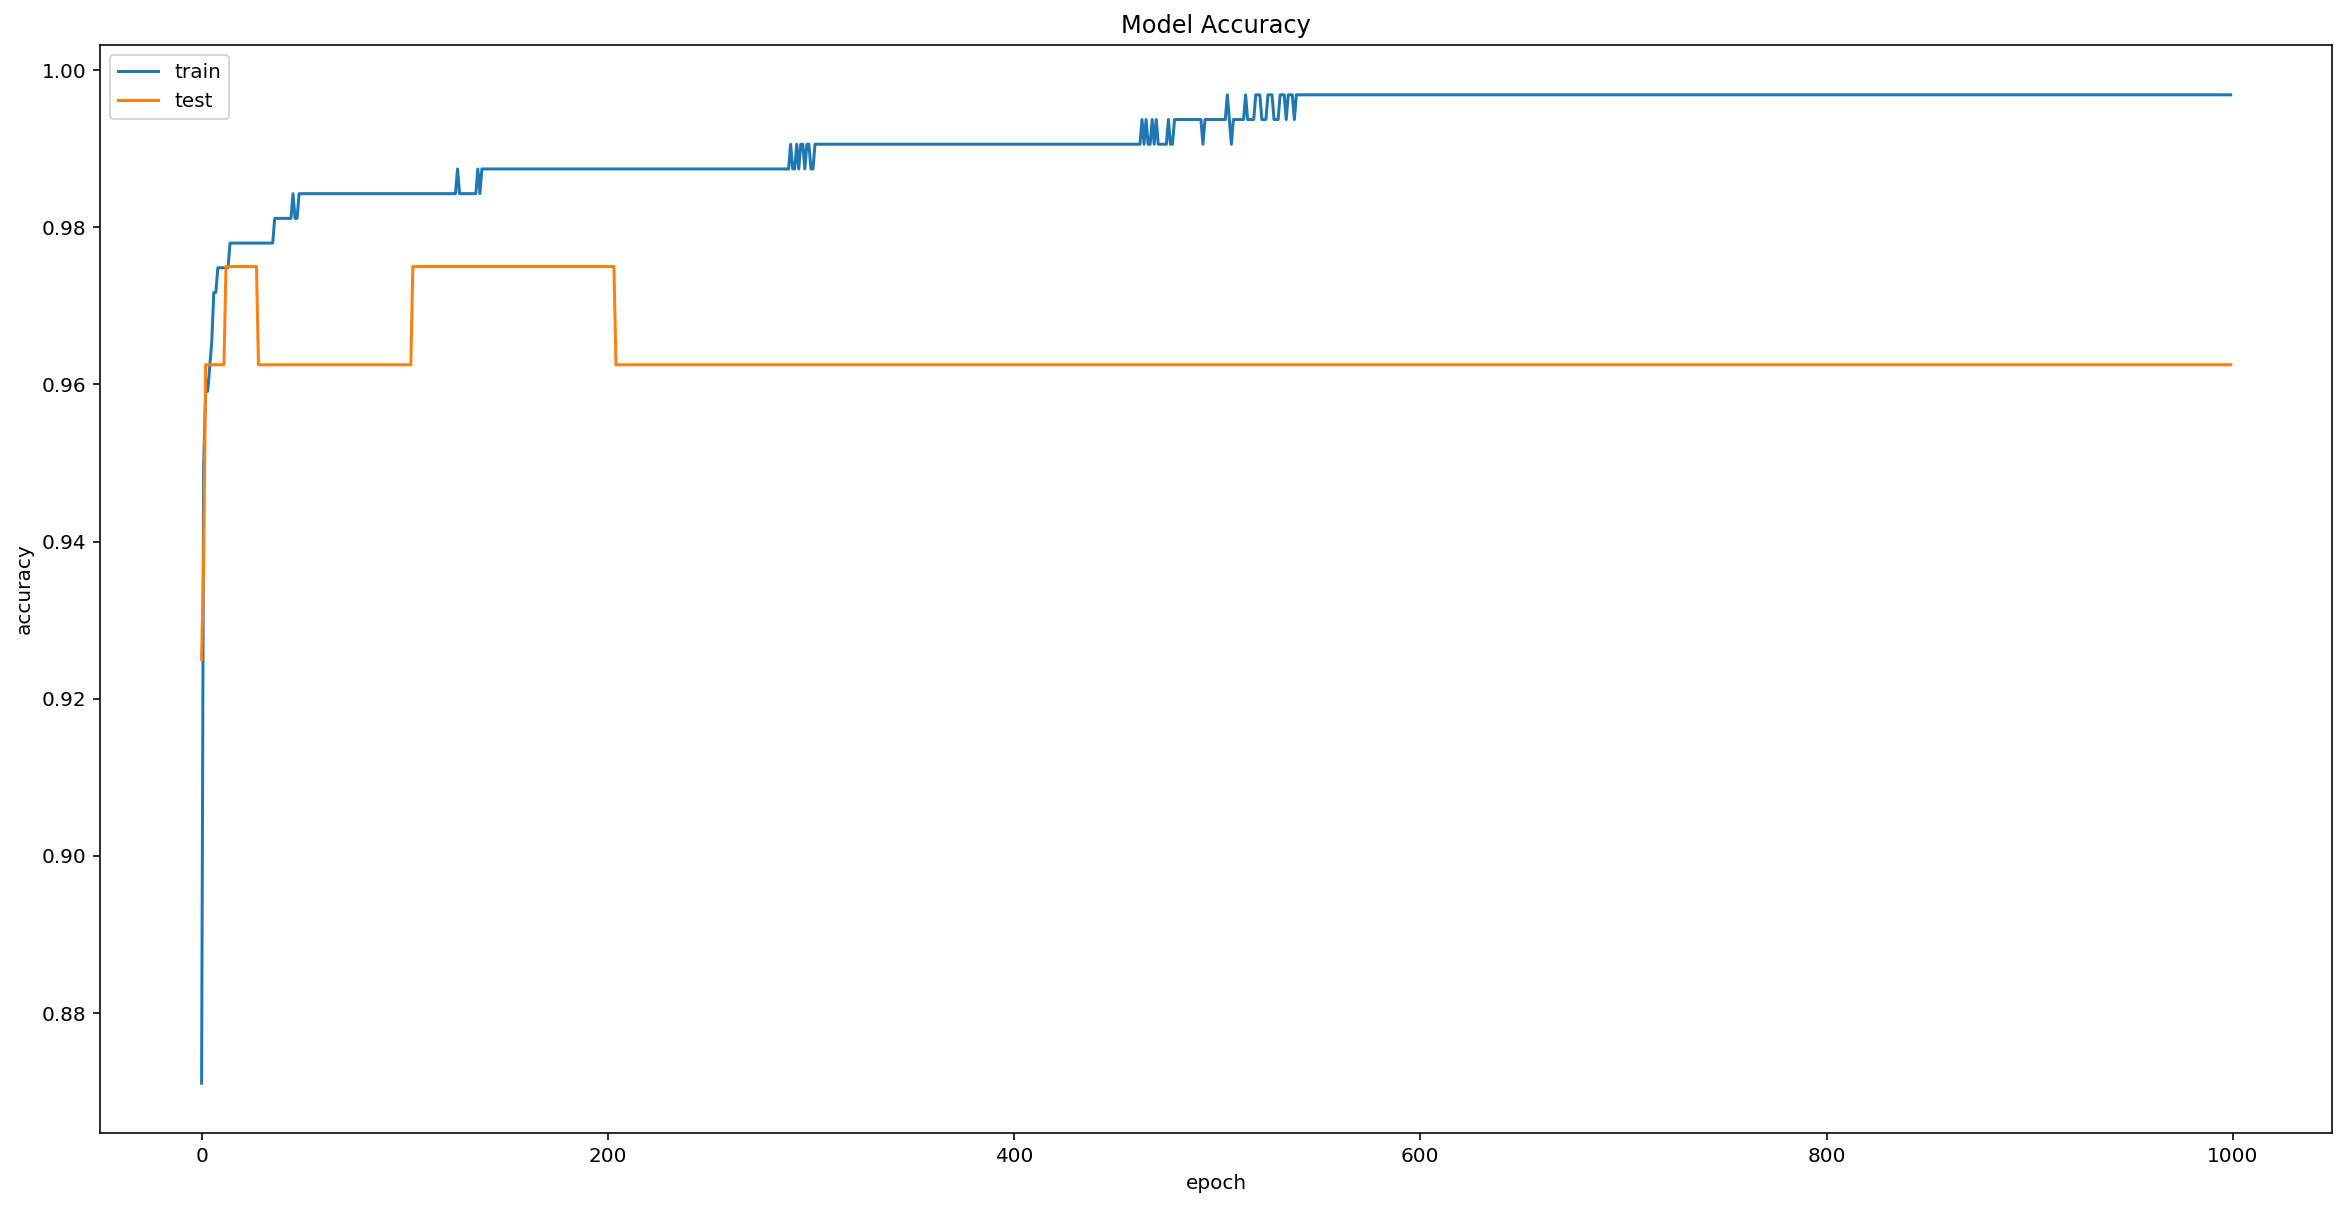

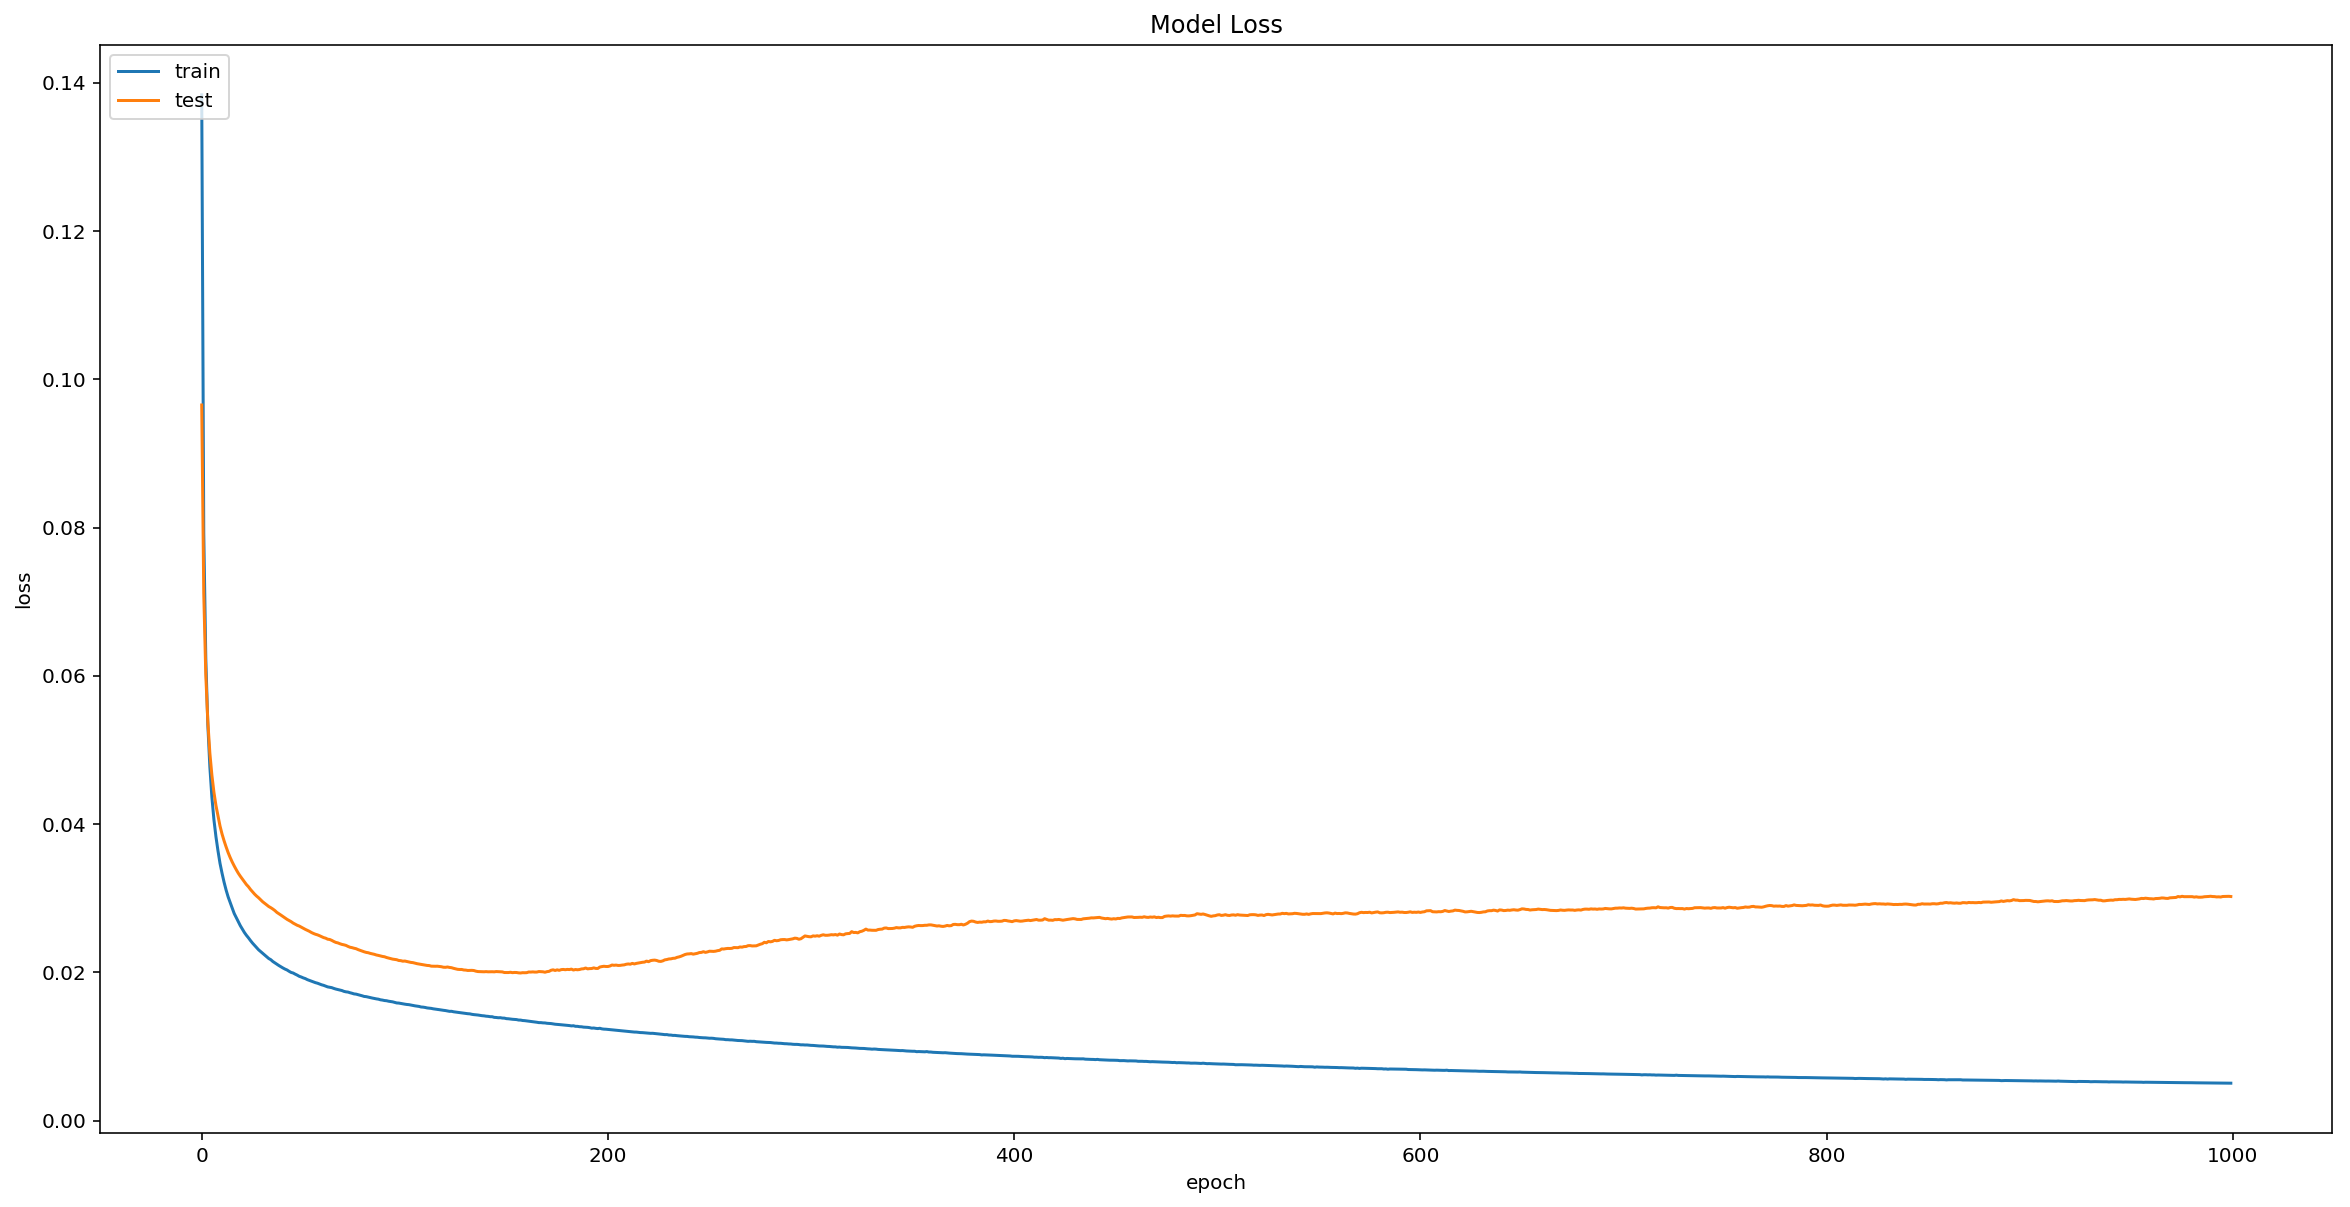

Memory Usage 1.49 MB
Time of Processing 46.59s
Accuracy 95.91%


In [40]:
show_info(model5, X_test_norm, y_test, keras_history5)

## Respostas da questão 2

In [42]:
# Building the model 6
model6 = Sequential()
model6.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model6.add(Dense(64, activation='tanh'))
model6.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model6.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model6.summary()

# Training the model 6
keras_history6 = KerasHistory()
memory_usage = monitor(target=train(model6, X_train_norm, y_train, keras_history6, epochs=200, batch_size=100))
keras_history6.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2021 - acc: 0.8208 - val_loss: 0.1758 - val_acc: 0.8625
Epoch 2/200
 - 0s - loss: 0.1718 - acc: 0.8616 - val_loss: 0.1530 - val_acc: 0.9250
Epoch 3/200
 - 0s - loss: 0.1508 - acc: 0.8868 - val_loss: 0.1360 - val_acc: 0.9375
Epoch 4/200
 - 0s - loss: 0.1352 - acc: 0.9119 - val_loss: 0.1236 - val_acc: 0.9375
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0337 - acc: 0.9748 - val_loss: 0.0384 - val_acc: 0.9750
Epoch 90/200
 - 0s - loss: 0.0335 - acc: 0.9748 - val_loss: 0.0383 - val_acc: 0.9750
Epoch 91/200
 - 0s - loss: 0.0334 - acc: 0.9748 - val_loss: 0.0381 - val_acc: 0.9750
Epoch 92/200
 - 0s - loss: 0.0332 - acc: 0.9748 - val_loss: 0.0381 - val_acc: 0.9750
Epoch 93/200
 - 0s - loss: 0.0331 - acc: 0.9748 - val_loss: 0.0380 - val_acc: 0.9750
Epoch 94/200
 - 0s - loss: 0.0330 - acc: 0.9748 - val_loss: 0.0379 - val_acc: 0.9750
Epoch 95/200
 - 0s - loss: 0.0328 - acc: 0.9748 - val_loss: 0.0377 - val_acc: 0.9750
Epoch 96/200
 - 0s - loss: 0.0327 - acc: 0.9748 - val_loss: 0.0376 - val_acc: 0.9750
Epoch 97/200
 - 0s - loss: 0.0325 - acc: 0.9748 - val_loss: 0.0376 - val_acc: 0.9750
Epoch 98/200
 - 0s - loss: 0.0324 - acc: 0.9780 - val_loss: 0.0375 - val_acc: 0.9750
Epoch 99/200
 - 0s - loss: 0.0323 - acc: 0.9780 - val_loss: 0.0375 - val_acc: 0.9750
Epoch 100/200
 - 0s - loss: 0.0322 - acc: 0.9780 - val_loss: 0.03

Epoch 185/200
 - 0s - loss: 0.0254 - acc: 0.9780 - val_loss: 0.0317 - val_acc: 0.9750
Epoch 186/200
 - 0s - loss: 0.0253 - acc: 0.9780 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 187/200
 - 0s - loss: 0.0253 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 188/200
 - 0s - loss: 0.0253 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 189/200
 - 0s - loss: 0.0252 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 190/200
 - 0s - loss: 0.0252 - acc: 0.9780 - val_loss: 0.0314 - val_acc: 0.9750
Epoch 191/200
 - 0s - loss: 0.0251 - acc: 0.9780 - val_loss: 0.0313 - val_acc: 0.9750
Epoch 192/200
 - 0s - loss: 0.0251 - acc: 0.9780 - val_loss: 0.0313 - val_acc: 0.9750
Epoch 193/200
 - 0s - loss: 0.0250 - acc: 0.9780 - val_loss: 0.0312 - val_acc: 0.9750
Epoch 194/200
 - 0s - loss: 0.0250 - acc: 0.9780 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 195/200
 - 0s - loss: 0.0249 - acc: 0.9780 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 196/200
 - 0s - loss: 0.0249 - acc: 0.9780 - val

## Treinamento 6
Para o treinamento 6 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 100

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

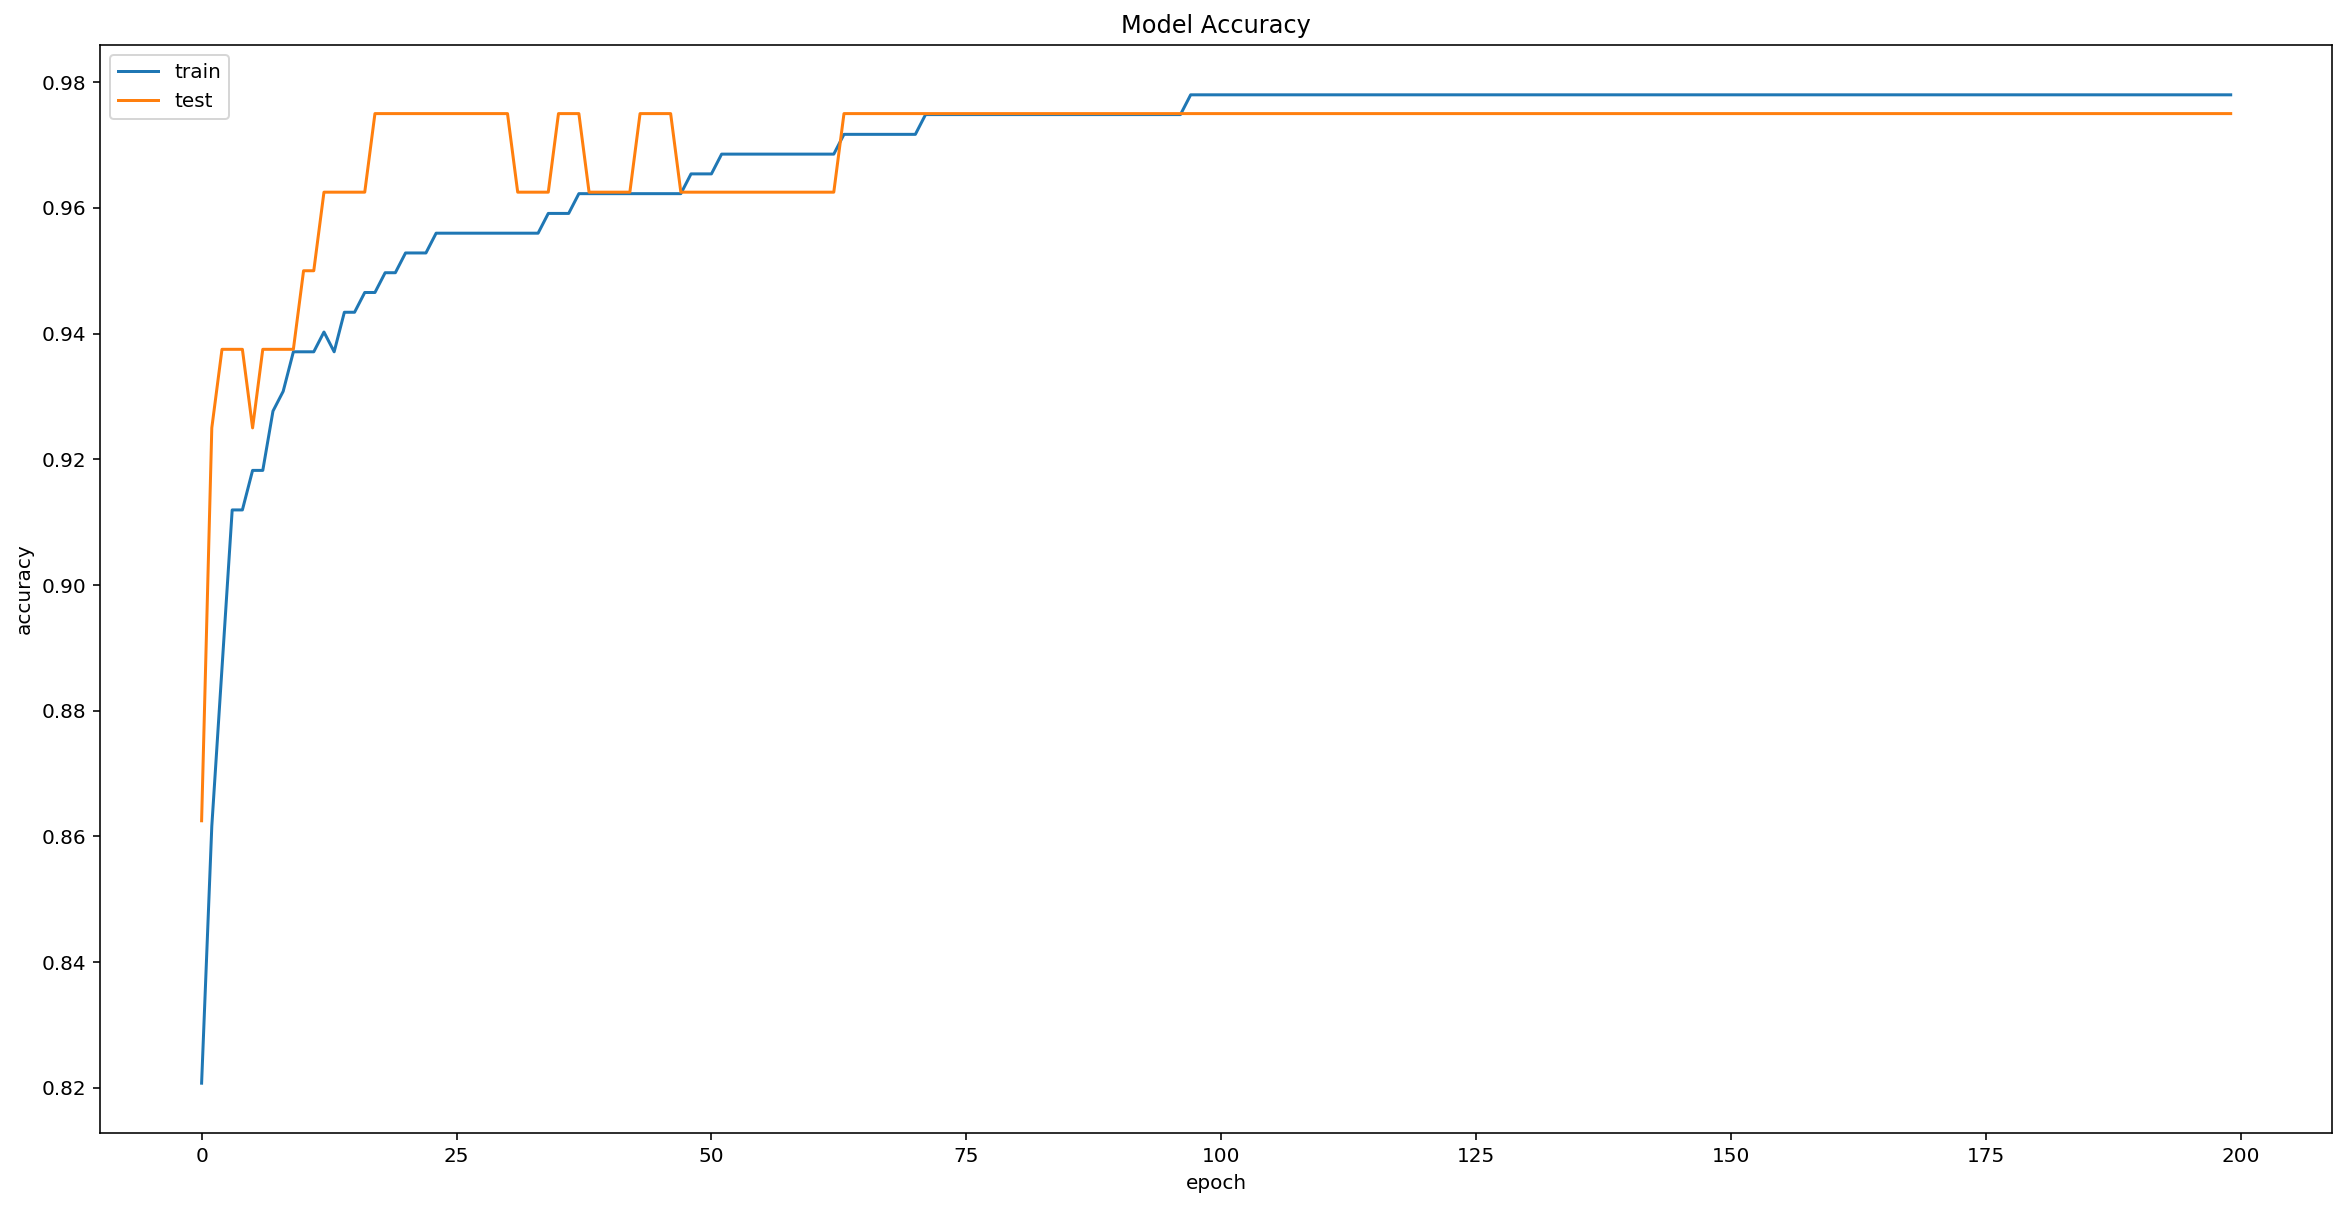

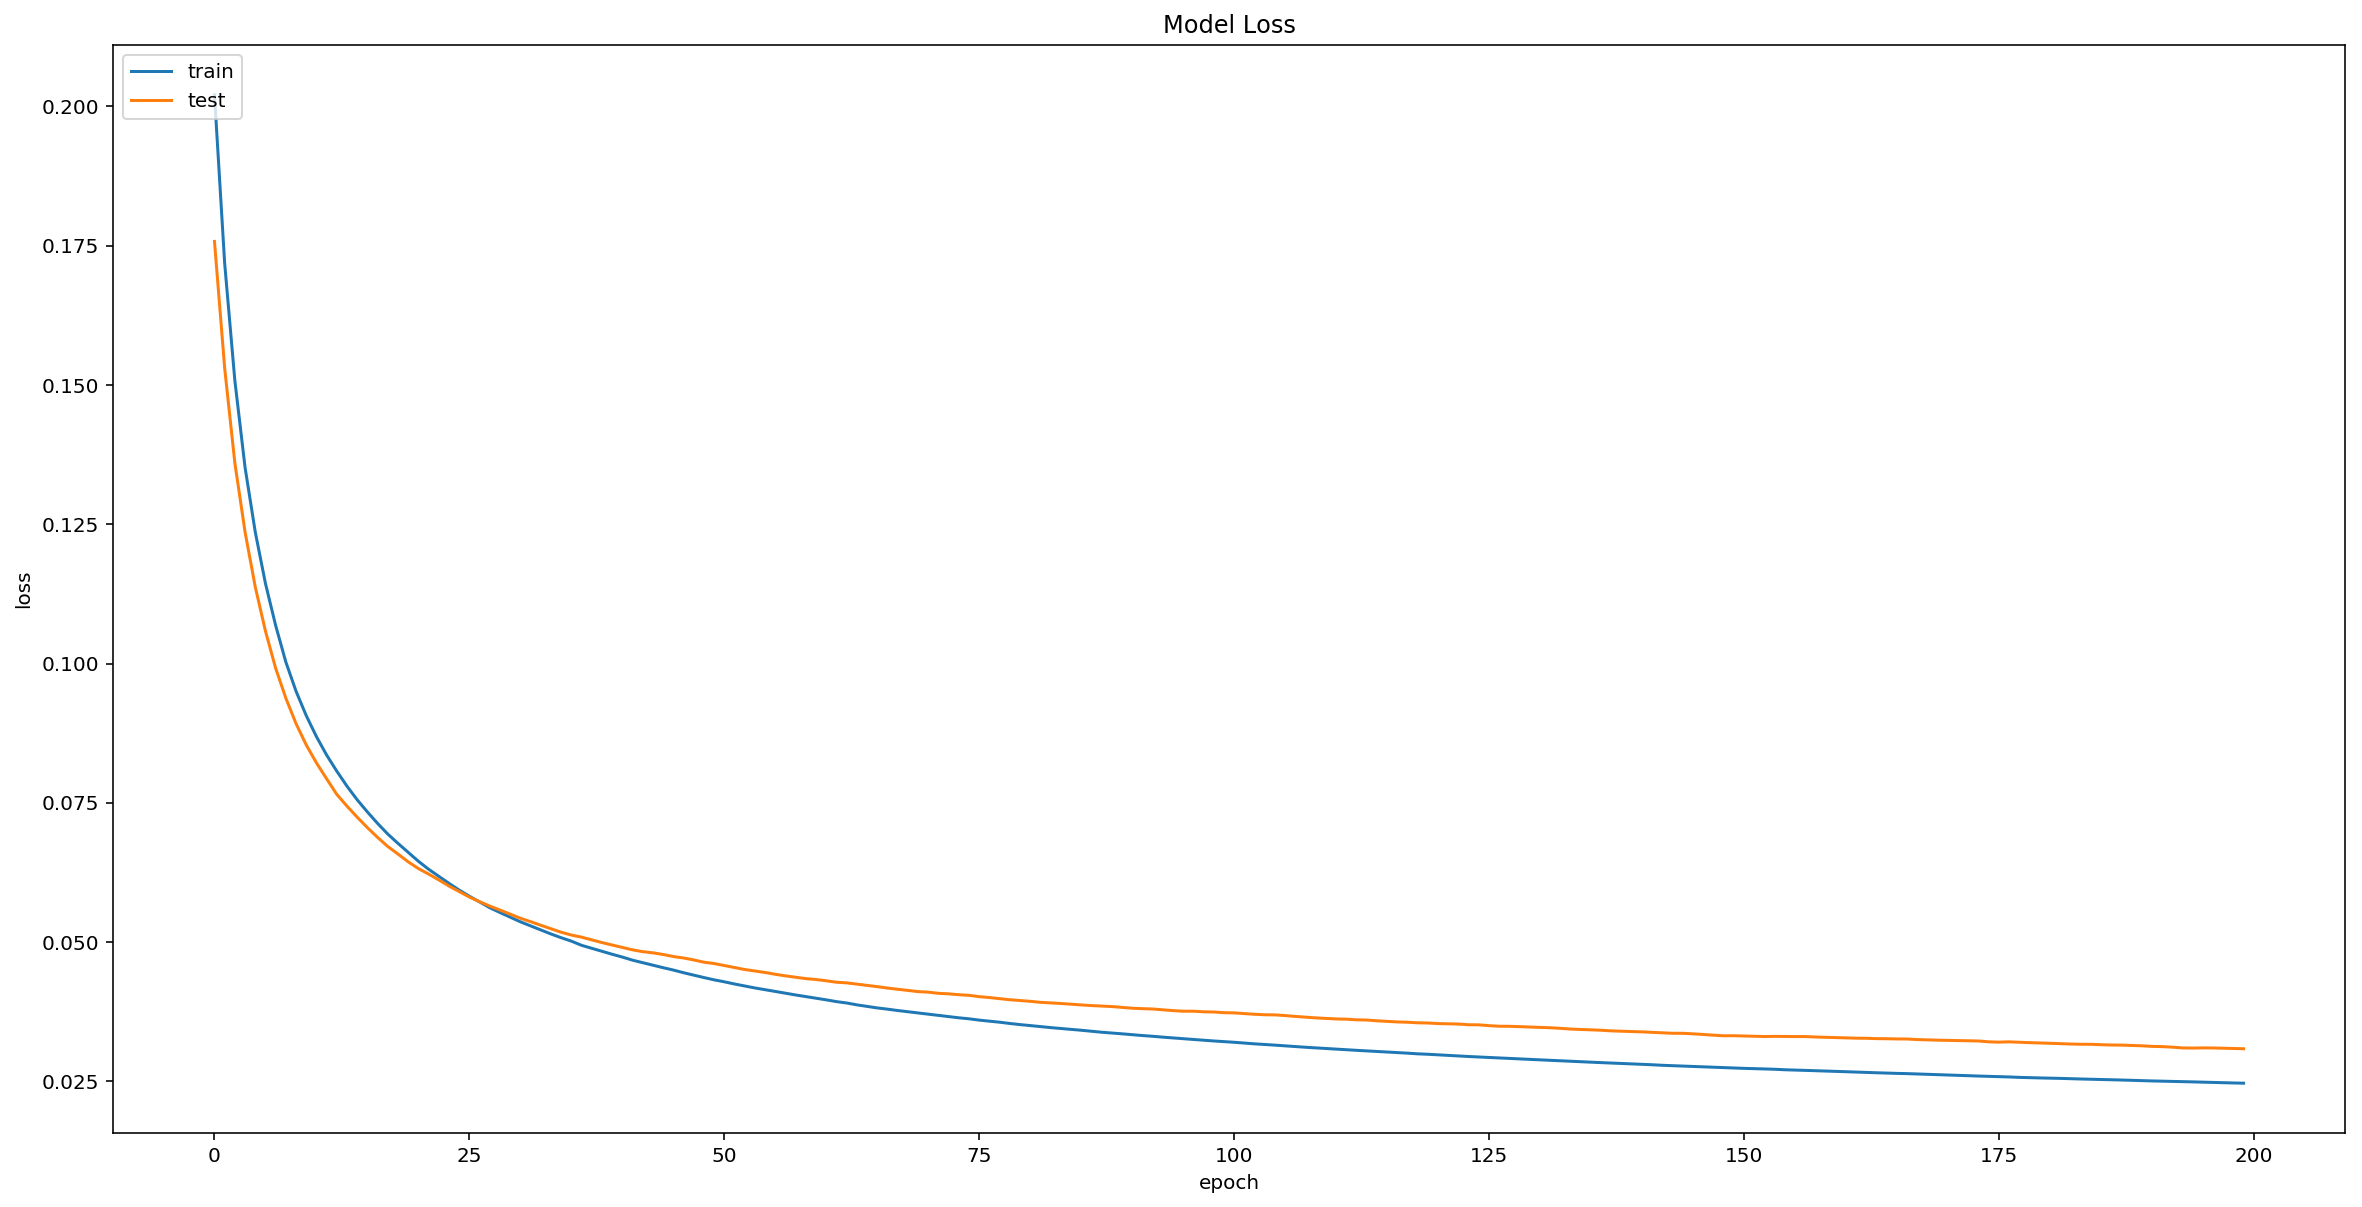

Memory Usage 1.27 MB
Time of Processing 2.58s
Accuracy 98.83%


In [43]:
show_info(model6, X_test_norm, y_test, keras_history6)

In [44]:
# Building the model 7
model7 = Sequential()
model7.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model7.add(Dense(64, activation='tanh'))
model7.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model7.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model7.summary()

# Training the model 7
keras_history7 = KerasHistory()
memory_usage = monitor(target=train(model7, X_train_norm, y_train, keras_history7, epochs=200, batch_size=80))
keras_history7.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2535 - acc: 0.4748 - val_loss: 0.2244 - val_acc: 0.8125
Epoch 2/200
 - 0s - loss: 0.2056 - acc: 0.8585 - val_loss: 0.1866 - val_acc: 0.9250
Epoch 3/200
 - 0s - loss: 0.1731 - acc: 0.9057 - val_loss: 0.1607 - val_acc: 0.9250
Epoch 4/200
 - 0s - loss: 0.1506 - acc: 0.9214 - val_loss: 0.1422 - val_acc: 0.9375
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0333 - acc: 0.9748 - val_loss: 0.0383 - val_acc: 0.9625
Epoch 90/200
 - 0s - loss: 0.0331 - acc: 0.9748 - val_loss: 0.0381 - val_acc: 0.9625
Epoch 91/200
 - 0s - loss: 0.0330 - acc: 0.9748 - val_loss: 0.0380 - val_acc: 0.9625
Epoch 92/200
 - 0s - loss: 0.0328 - acc: 0.9748 - val_loss: 0.0379 - val_acc: 0.9625
Epoch 93/200
 - 0s - loss: 0.0327 - acc: 0.9780 - val_loss: 0.0378 - val_acc: 0.9625
Epoch 94/200
 - 0s - loss: 0.0325 - acc: 0.9780 - val_loss: 0.0376 - val_acc: 0.9625
Epoch 95/200
 - 0s - loss: 0.0324 - acc: 0.9780 - val_loss: 0.0375 - val_acc: 0.9625
Epoch 96/200
 - 0s - loss: 0.0322 - acc: 0.9780 - val_loss: 0.0374 - val_acc: 0.9625
Epoch 97/200
 - 0s - loss: 0.0321 - acc: 0.9780 - val_loss: 0.0373 - val_acc: 0.9750
Epoch 98/200
 - 0s - loss: 0.0320 - acc: 0.9780 - val_loss: 0.0372 - val_acc: 0.9750
Epoch 99/200
 - 0s - loss: 0.0318 - acc: 0.9780 - val_loss: 0.0371 - val_acc: 0.9750
Epoch 100/200
 - 0s - loss: 0.0317 - acc: 0.9780 - val_loss: 0.03

Epoch 185/200
 - 0s - loss: 0.0249 - acc: 0.9780 - val_loss: 0.0312 - val_acc: 0.9750
Epoch 186/200
 - 0s - loss: 0.0249 - acc: 0.9780 - val_loss: 0.0311 - val_acc: 0.9750
Epoch 187/200
 - 0s - loss: 0.0248 - acc: 0.9780 - val_loss: 0.0311 - val_acc: 0.9750
Epoch 188/200
 - 0s - loss: 0.0248 - acc: 0.9780 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 189/200
 - 0s - loss: 0.0248 - acc: 0.9780 - val_loss: 0.0310 - val_acc: 0.9750
Epoch 190/200
 - 0s - loss: 0.0247 - acc: 0.9780 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 191/200
 - 0s - loss: 0.0247 - acc: 0.9780 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 192/200
 - 0s - loss: 0.0246 - acc: 0.9780 - val_loss: 0.0309 - val_acc: 0.9750
Epoch 193/200
 - 0s - loss: 0.0246 - acc: 0.9780 - val_loss: 0.0308 - val_acc: 0.9750
Epoch 194/200
 - 0s - loss: 0.0245 - acc: 0.9780 - val_loss: 0.0308 - val_acc: 0.9750
Epoch 195/200
 - 0s - loss: 0.0245 - acc: 0.9780 - val_loss: 0.0307 - val_acc: 0.9750
Epoch 196/200
 - 0s - loss: 0.0244 - acc: 0.9780 - val

## Treinamento 7
Para o treinamento 7 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 80

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

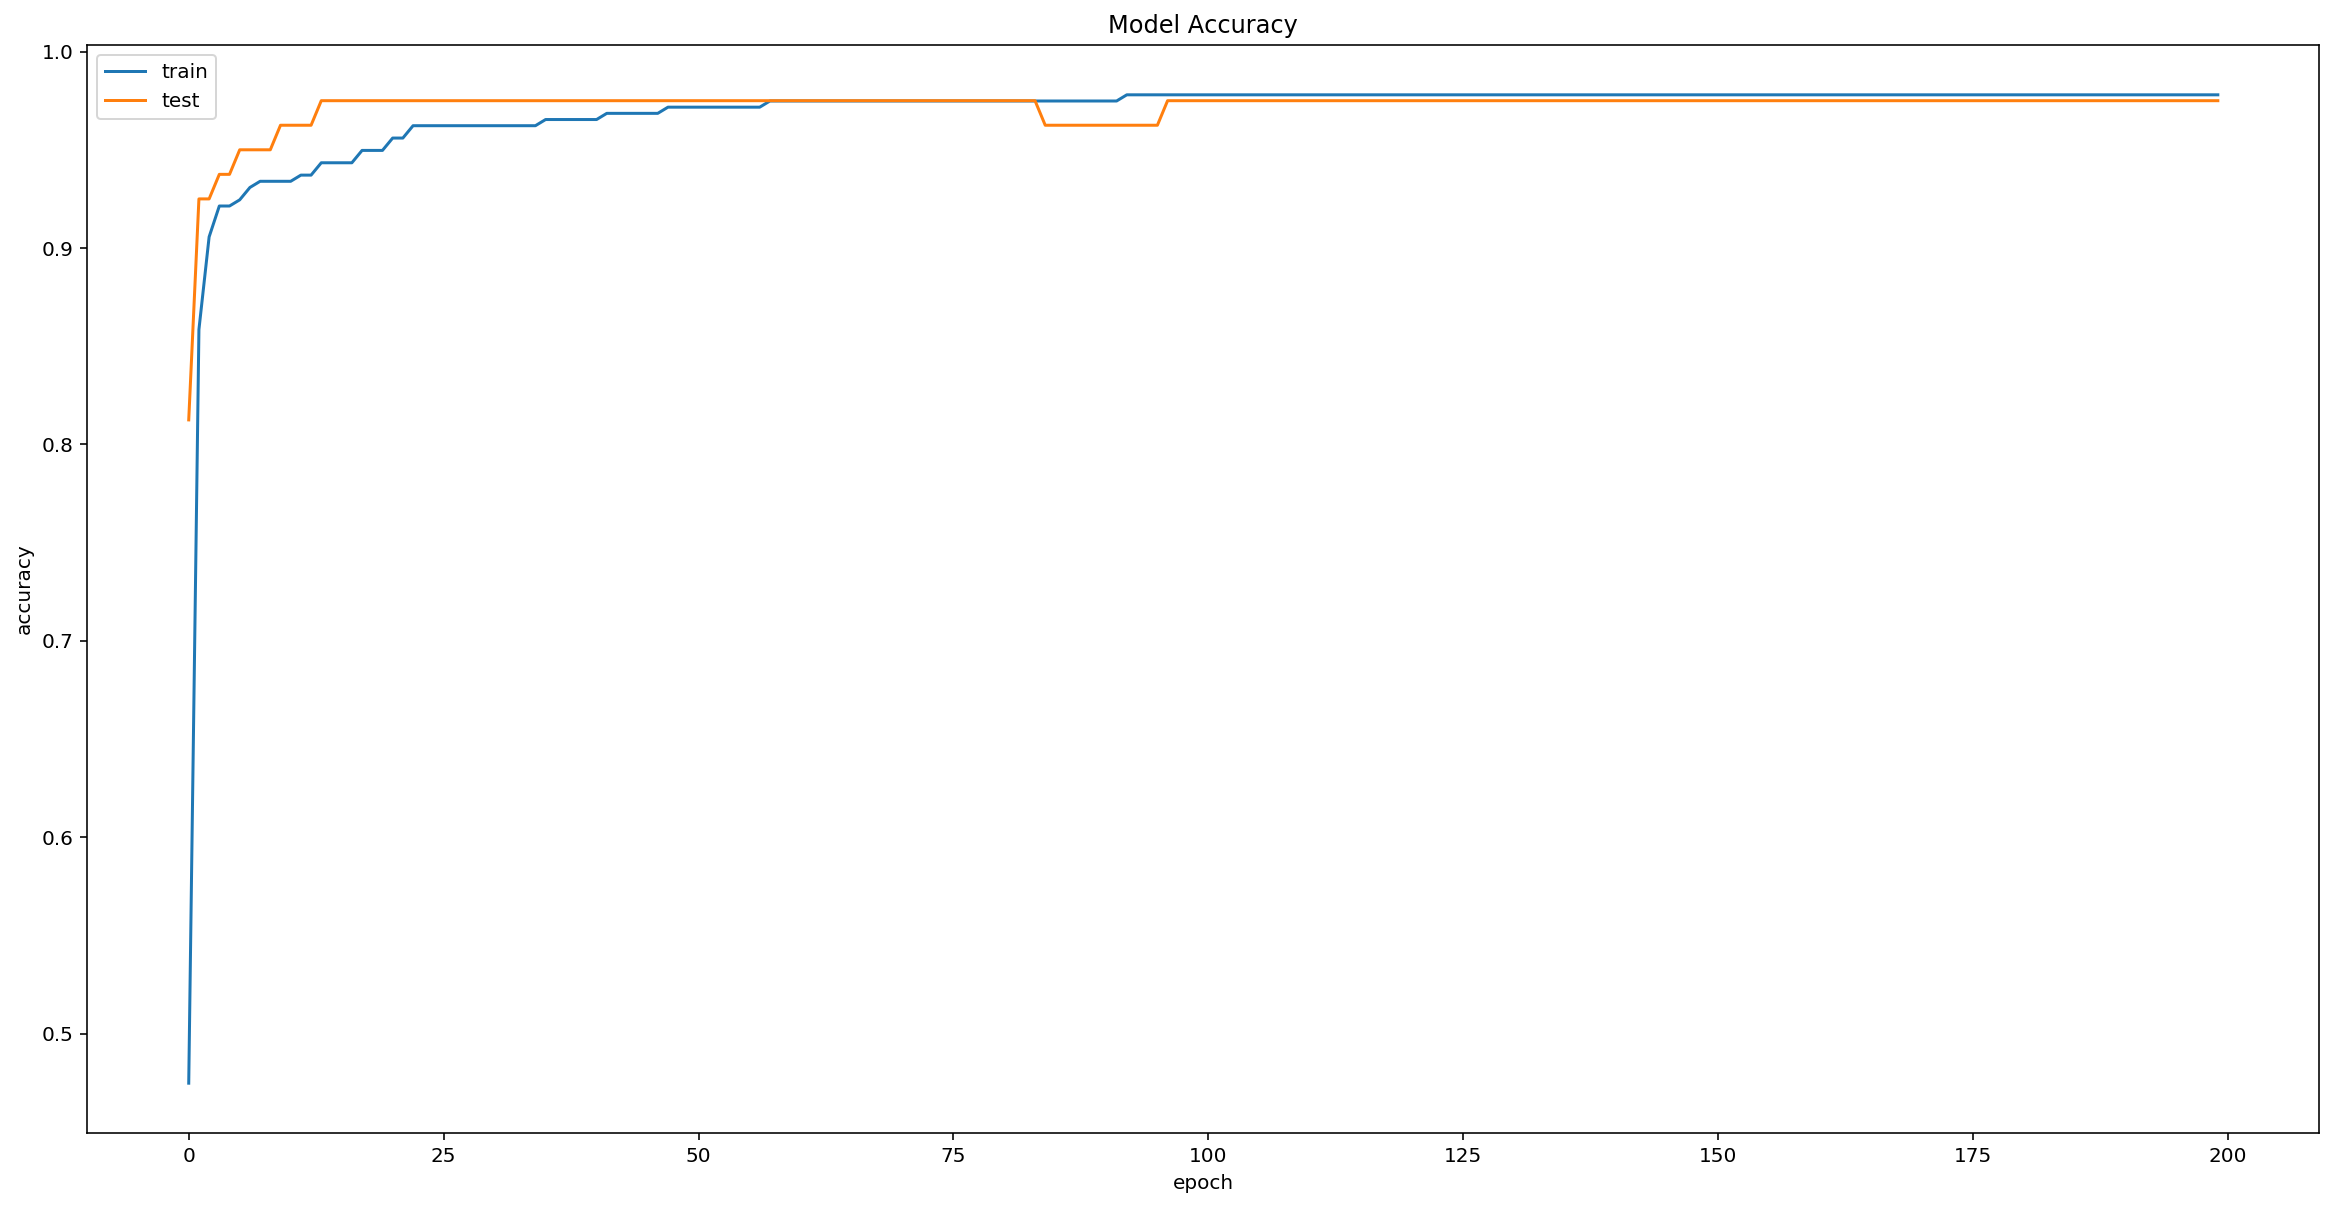

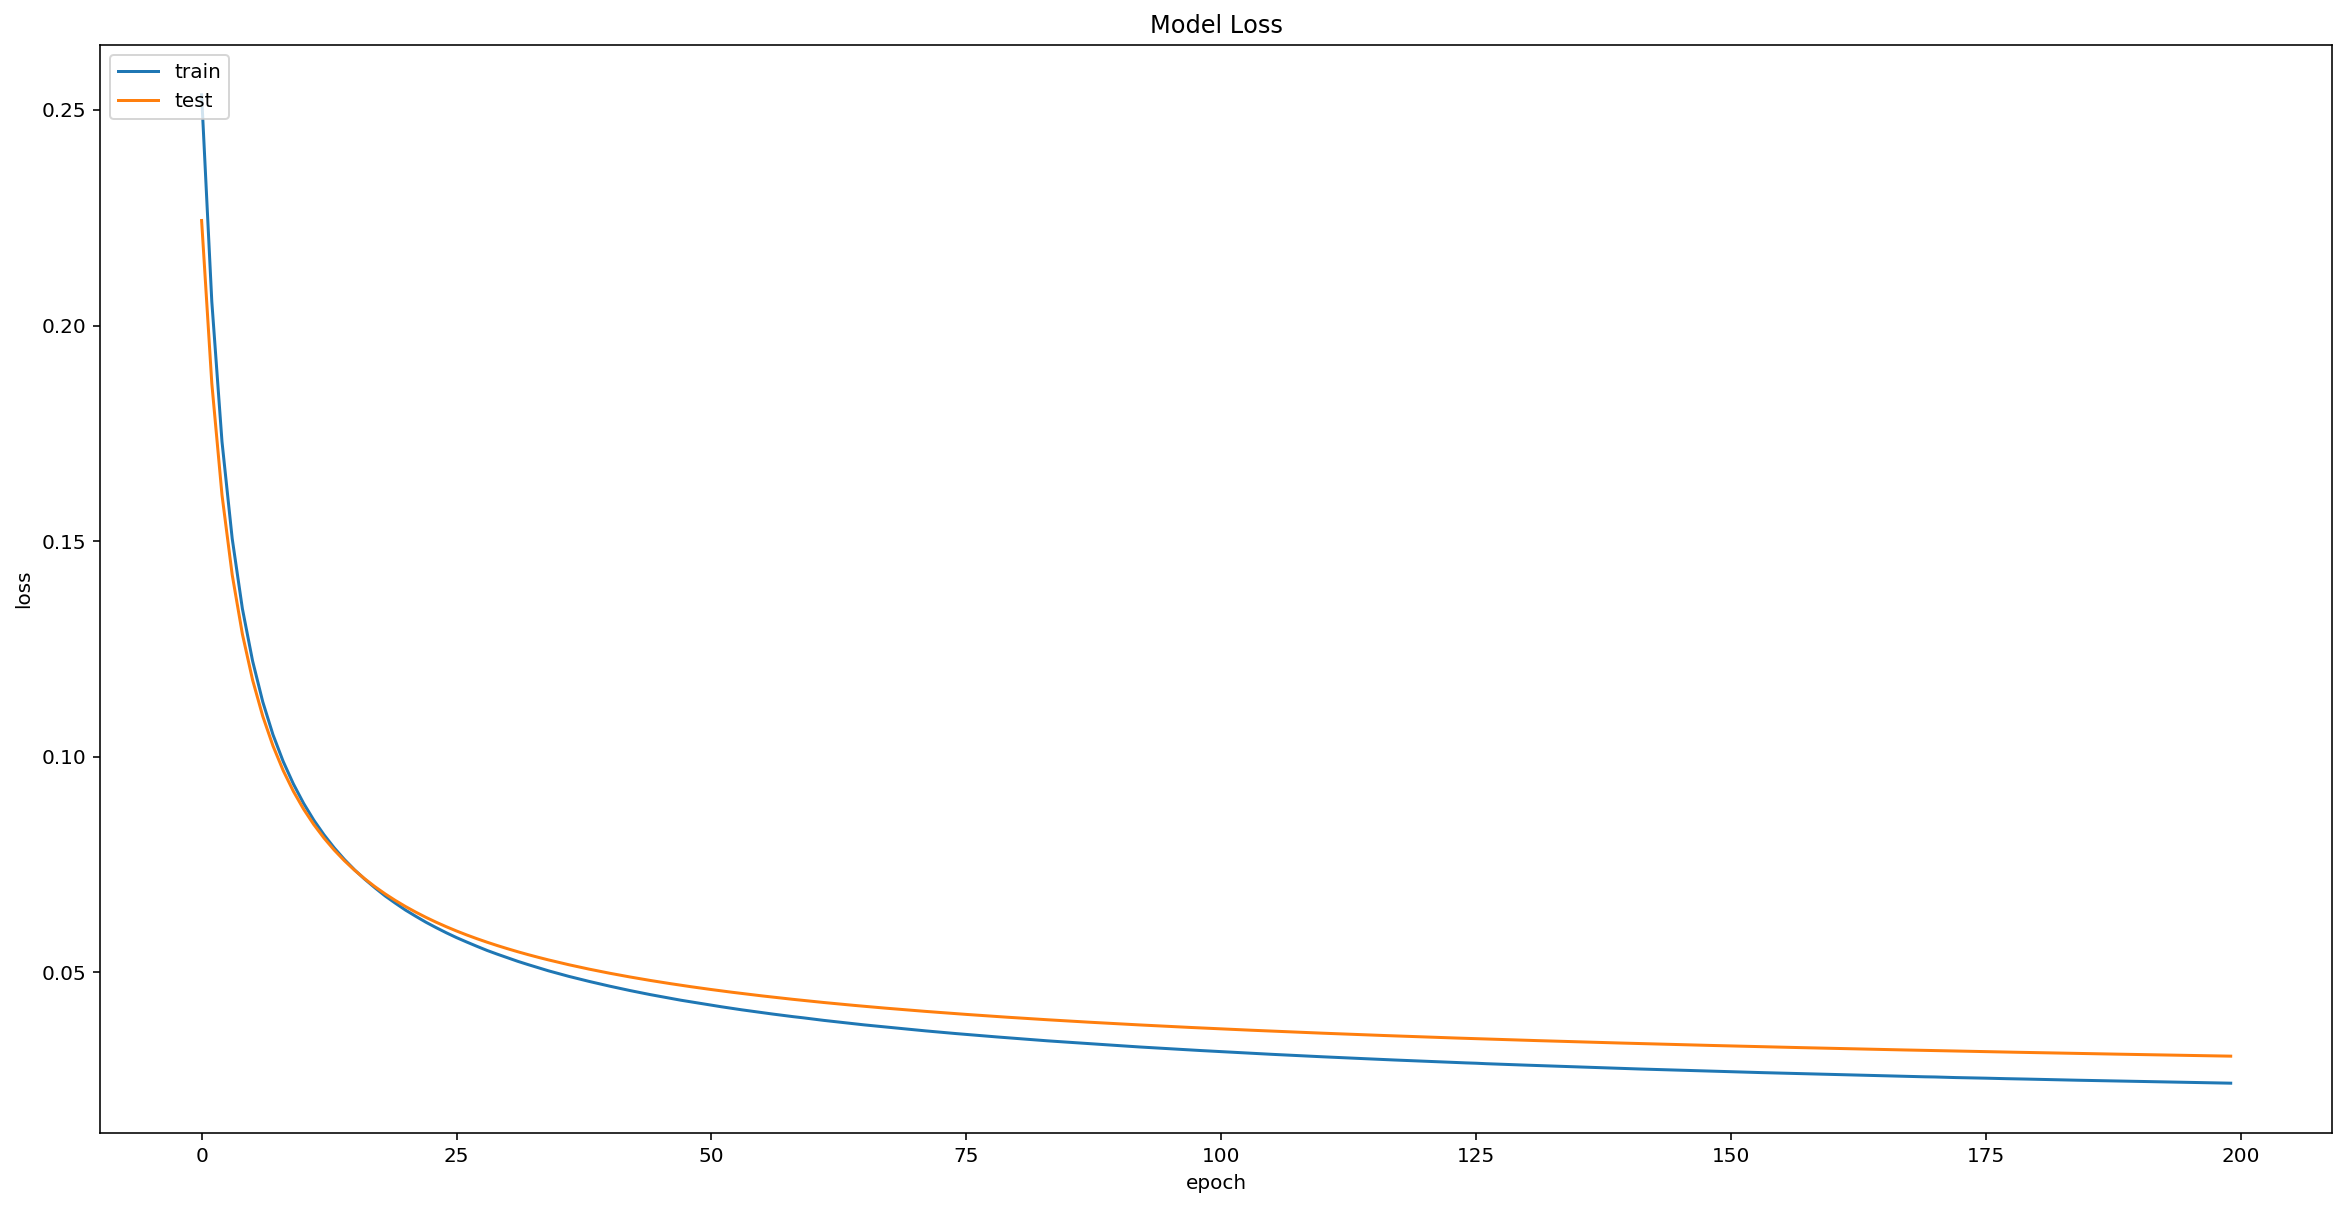

Memory Usage 1.17 MB
Time of Processing 2.42s
Accuracy 98.83%


In [45]:
show_info(model7, X_test_norm, y_test, keras_history7)

In [46]:
# Building the model 8
model8 = Sequential()
model8.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model8.add(Dense(64, activation='tanh'))
model8.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model8.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model8.summary()

# Training the model 8
keras_history8 = KerasHistory()
memory_usage = monitor(target=train(model8, X_train_norm, y_train, keras_history8, epochs=200, batch_size=60))
keras_history8.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.2234 - acc: 0.6855 - val_loss: 0.1921 - val_acc: 0.8750
Epoch 2/200
 - 0s - loss: 0.1736 - acc: 0.8931 - val_loss: 0.1542 - val_acc: 0.9125
Epoch 3/200
 - 0s - loss: 0.1426 - acc: 0.9182 - val_loss: 0.1311 - val_acc: 0.9375
Epoch 4/200
 - 0s - loss: 0.1233 - acc: 0.9214 - val_loss: 0.1158 - val_acc: 0.9375
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0286 - acc: 0.9780 - val_loss: 0.0345 - val_acc: 0.9500
Epoch 90/200
 - 0s - loss: 0.0284 - acc: 0.9780 - val_loss: 0.0345 - val_acc: 0.9500
Epoch 91/200
 - 0s - loss: 0.0283 - acc: 0.9780 - val_loss: 0.0344 - val_acc: 0.9500
Epoch 92/200
 - 0s - loss: 0.0282 - acc: 0.9780 - val_loss: 0.0342 - val_acc: 0.9500
Epoch 93/200
 - 0s - loss: 0.0281 - acc: 0.9780 - val_loss: 0.0341 - val_acc: 0.9500
Epoch 94/200
 - 0s - loss: 0.0279 - acc: 0.9780 - val_loss: 0.0340 - val_acc: 0.9500
Epoch 95/200
 - 0s - loss: 0.0278 - acc: 0.9780 - val_loss: 0.0339 - val_acc: 0.9500
Epoch 96/200
 - 0s - loss: 0.0277 - acc: 0.9780 - val_loss: 0.0338 - val_acc: 0.9500
Epoch 97/200
 - 0s - loss: 0.0276 - acc: 0.9780 - val_loss: 0.0337 - val_acc: 0.9500
Epoch 98/200
 - 0s - loss: 0.0275 - acc: 0.9780 - val_loss: 0.0336 - val_acc: 0.9500
Epoch 99/200
 - 0s - loss: 0.0274 - acc: 0.9780 - val_loss: 0.0335 - val_acc: 0.9500
Epoch 100/200
 - 0s - loss: 0.0273 - acc: 0.9780 - val_loss: 0.03

Epoch 185/200
 - 0s - loss: 0.0219 - acc: 0.9780 - val_loss: 0.0286 - val_acc: 0.9750
Epoch 186/200
 - 0s - loss: 0.0219 - acc: 0.9780 - val_loss: 0.0285 - val_acc: 0.9750
Epoch 187/200
 - 0s - loss: 0.0218 - acc: 0.9780 - val_loss: 0.0284 - val_acc: 0.9750
Epoch 188/200
 - 0s - loss: 0.0218 - acc: 0.9780 - val_loss: 0.0283 - val_acc: 0.9750
Epoch 189/200
 - 0s - loss: 0.0218 - acc: 0.9780 - val_loss: 0.0283 - val_acc: 0.9750
Epoch 190/200
 - 0s - loss: 0.0217 - acc: 0.9780 - val_loss: 0.0283 - val_acc: 0.9750
Epoch 191/200
 - 0s - loss: 0.0217 - acc: 0.9780 - val_loss: 0.0282 - val_acc: 0.9750
Epoch 192/200
 - 0s - loss: 0.0216 - acc: 0.9780 - val_loss: 0.0282 - val_acc: 0.9750
Epoch 193/200
 - 0s - loss: 0.0216 - acc: 0.9780 - val_loss: 0.0281 - val_acc: 0.9750
Epoch 194/200
 - 0s - loss: 0.0216 - acc: 0.9780 - val_loss: 0.0281 - val_acc: 0.9750
Epoch 195/200
 - 0s - loss: 0.0215 - acc: 0.9780 - val_loss: 0.0281 - val_acc: 0.9750
Epoch 196/200
 - 0s - loss: 0.0215 - acc: 0.9780 - val

## Treinamento 8
Para o treinamento 8 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 60

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

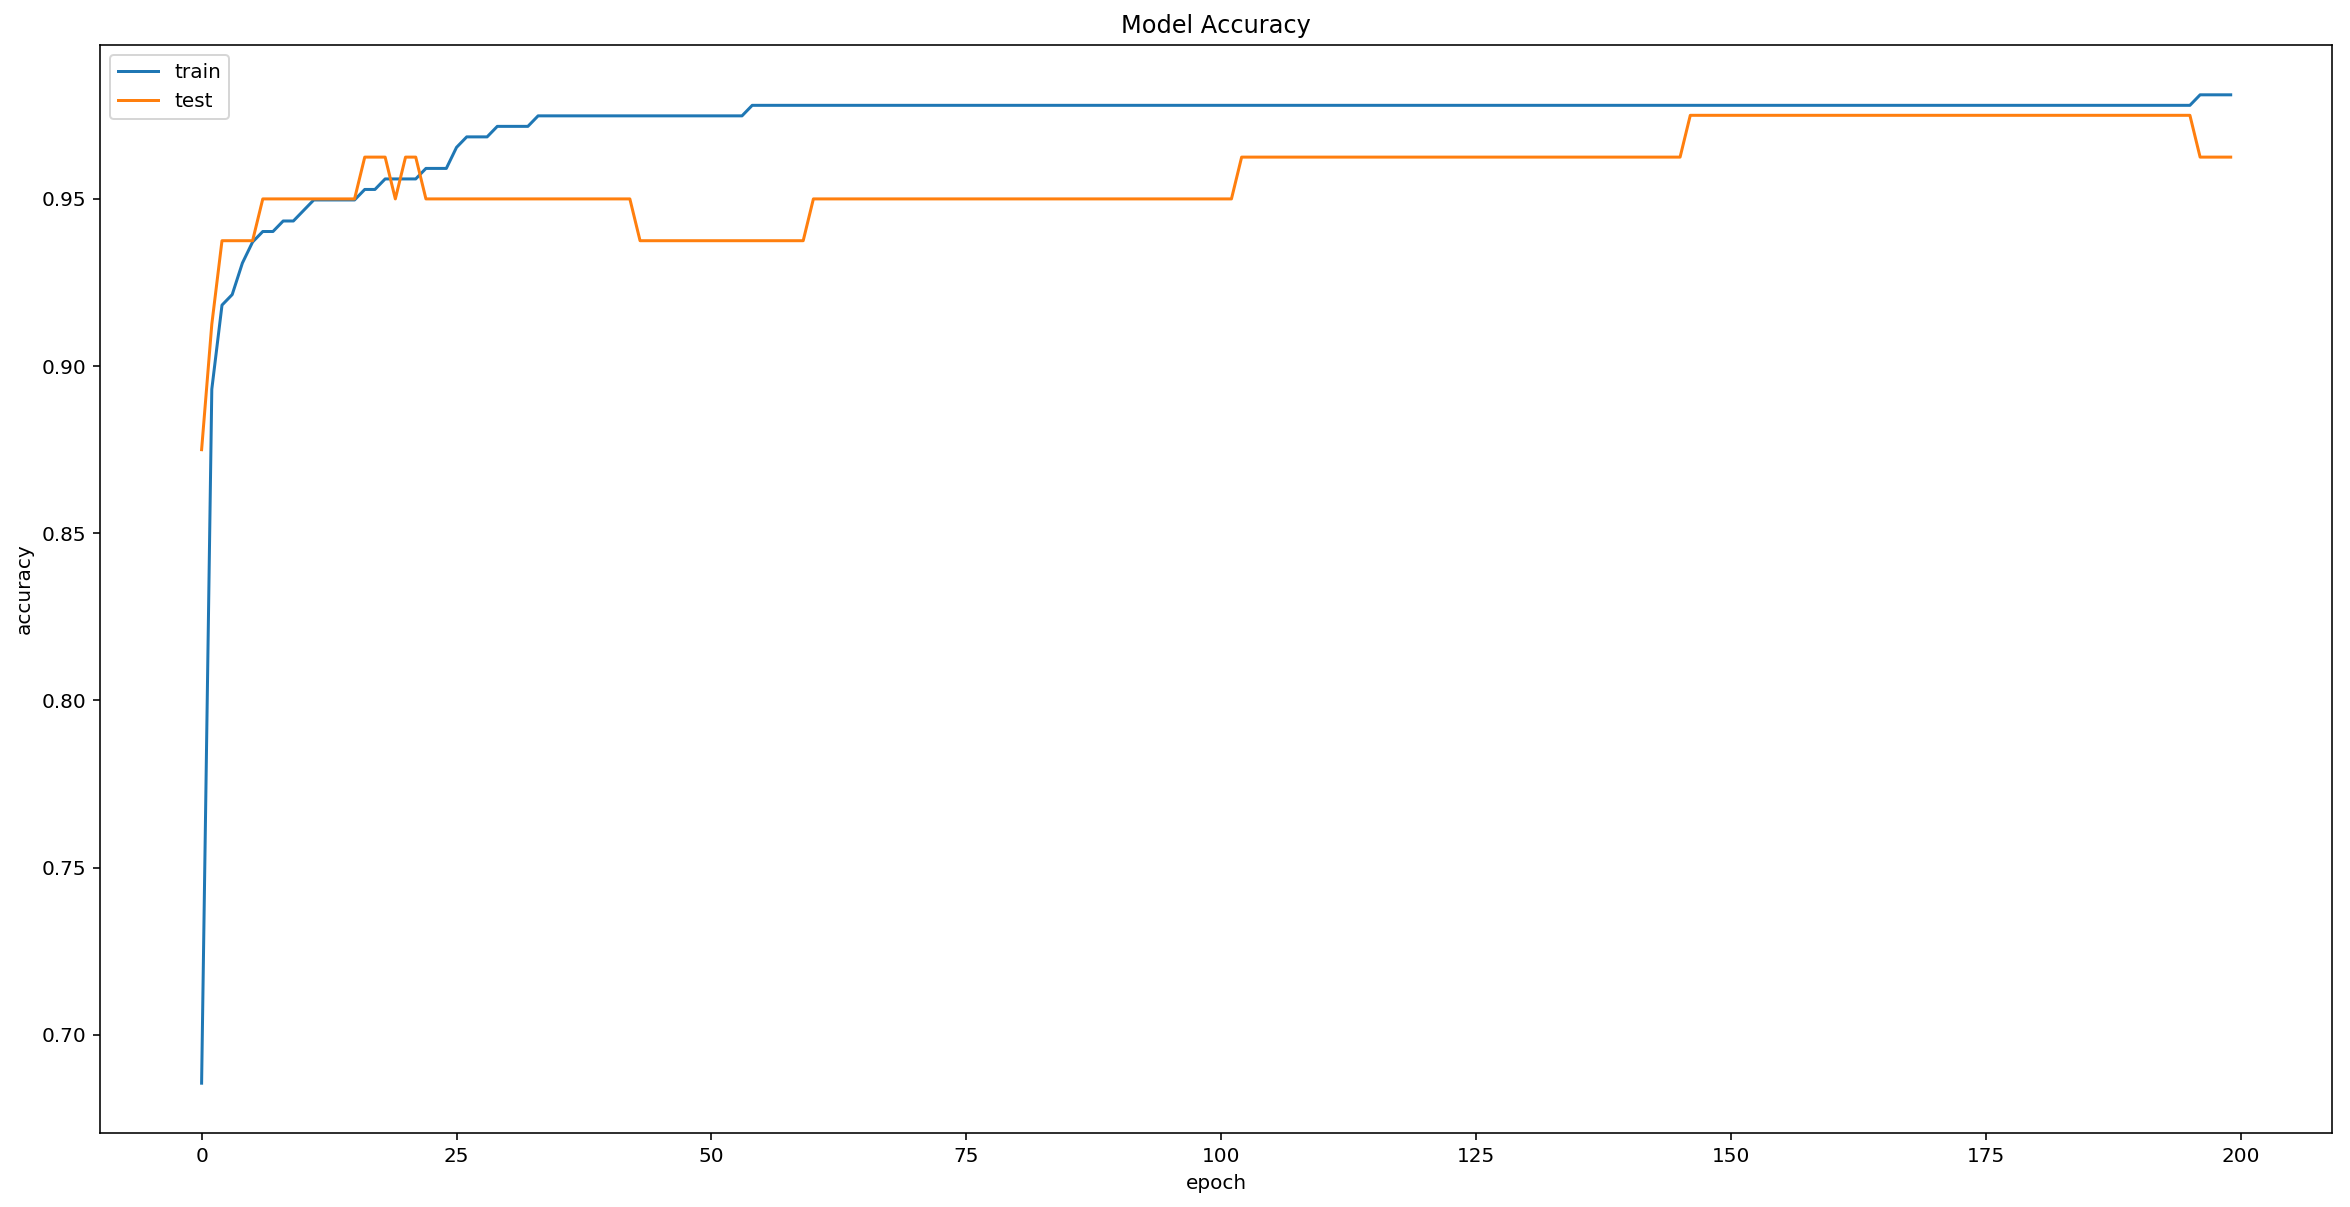

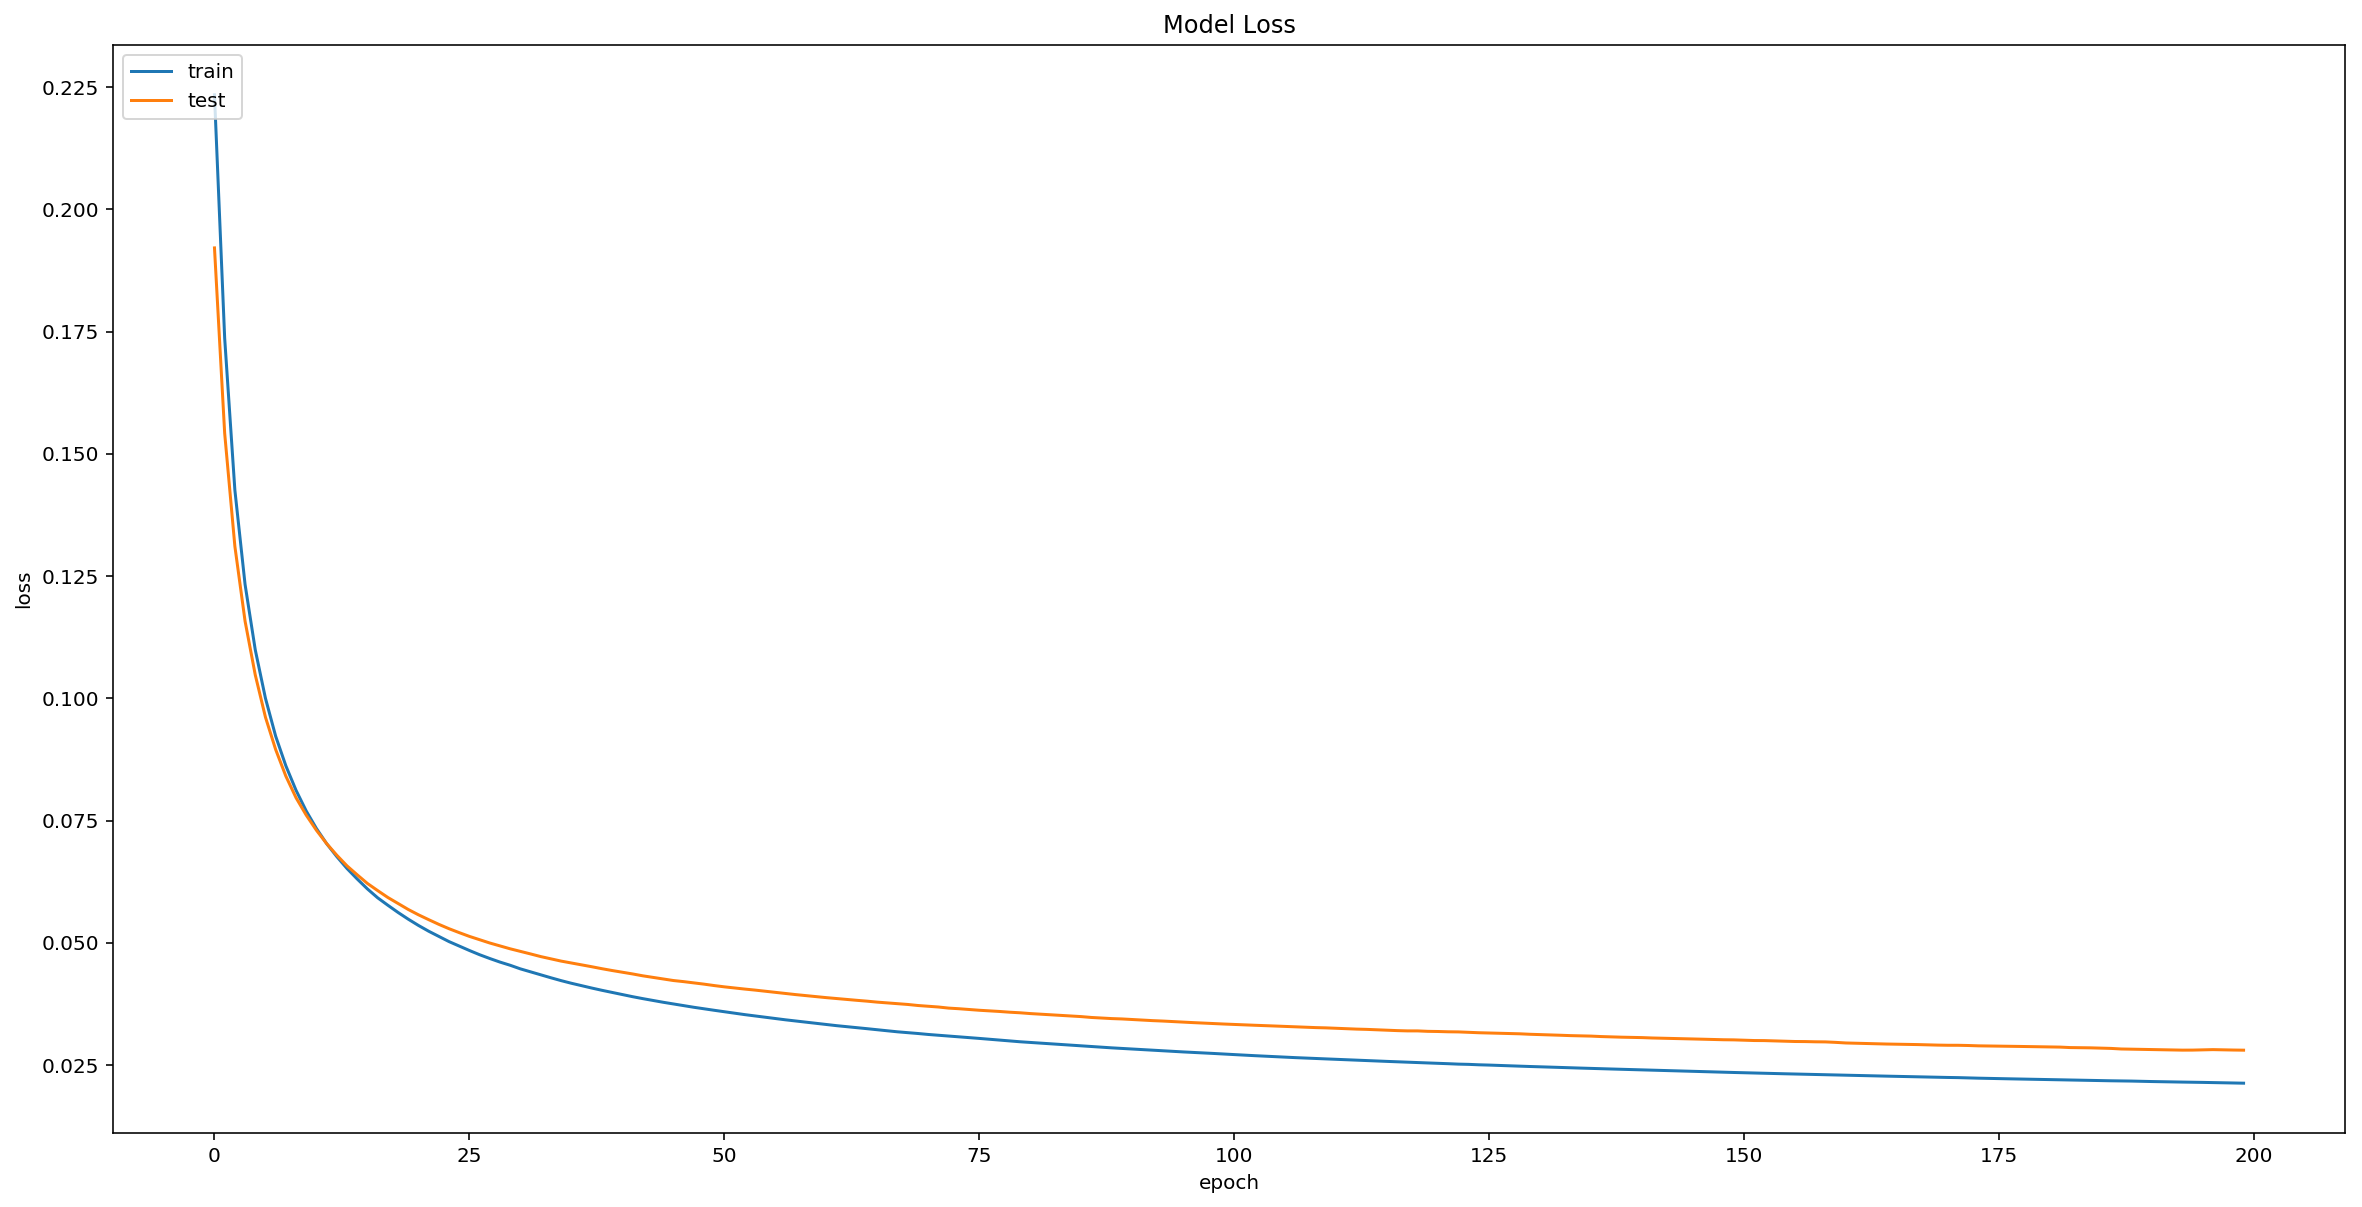

Memory Usage 1.43 MB
Time of Processing 3.20s
Accuracy 98.25%


In [47]:
show_info(model8, X_test_norm, y_test, keras_history8)

In [48]:
# Building the model 9
model9 = Sequential()
model9.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model9.add(Dense(64, activation='tanh'))
model9.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model9.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model9.summary()

# Training the model 9
keras_history9 = KerasHistory()
memory_usage = monitor(target=train(model9, X_train_norm, y_train, keras_history9, epochs=200, batch_size=30))
keras_history9.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.1706 - acc: 0.9025 - val_loss: 0.1334 - val_acc: 0.9250
Epoch 2/200
 - 0s - loss: 0.1250 - acc: 0.9119 - val_loss: 0.1056 - val_acc: 0.9375
Epoch 3/200
 - 0s - loss: 0.1027 - acc: 0.9277 - val_loss: 0.0899 - val_acc: 0.9750
Epoch 4/200
 - 0s - loss: 0.0892 - acc: 0.9371 - val_loss: 0.0800 - val_acc: 0.9750
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0287 - val_acc: 0.9750
Epoch 90/200
 - 0s - loss: 0.0229 - acc: 0.9780 - val_loss: 0.0287 - val_acc: 0.9750
Epoch 91/200
 - 0s - loss: 0.0228 - acc: 0.9780 - val_loss: 0.0286 - val_acc: 0.9750
Epoch 92/200
 - 0s - loss: 0.0227 - acc: 0.9780 - val_loss: 0.0285 - val_acc: 0.9750
Epoch 93/200
 - 0s - loss: 0.0226 - acc: 0.9780 - val_loss: 0.0285 - val_acc: 0.9625
Epoch 94/200
 - 0s - loss: 0.0225 - acc: 0.9780 - val_loss: 0.0284 - val_acc: 0.9625
Epoch 95/200
 - 0s - loss: 0.0225 - acc: 0.9780 - val_loss: 0.0283 - val_acc: 0.9625
Epoch 96/200
 - 0s - loss: 0.0224 - acc: 0.9780 - val_loss: 0.0282 - val_acc: 0.9625
Epoch 97/200
 - 0s - loss: 0.0223 - acc: 0.9780 - val_loss: 0.0281 - val_acc: 0.9625
Epoch 98/200
 - 0s - loss: 0.0222 - acc: 0.9780 - val_loss: 0.0280 - val_acc: 0.9625
Epoch 99/200
 - 0s - loss: 0.0222 - acc: 0.9780 - val_loss: 0.0279 - val_acc: 0.9625
Epoch 100/200
 - 0s - loss: 0.0221 - acc: 0.9780 - val_loss: 0.02

Epoch 185/200
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0237 - val_acc: 0.9625
Epoch 186/200
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0237 - val_acc: 0.9625
Epoch 187/200
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0237 - val_acc: 0.9625
Epoch 188/200
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0237 - val_acc: 0.9625
Epoch 189/200
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0236 - val_acc: 0.9625
Epoch 190/200
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0236 - val_acc: 0.9625
Epoch 191/200
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0236 - val_acc: 0.9625
Epoch 192/200
 - 0s - loss: 0.0180 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9625
Epoch 193/200
 - 0s - loss: 0.0180 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9625
Epoch 194/200
 - 0s - loss: 0.0180 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9625
Epoch 195/200
 - 0s - loss: 0.0180 - acc: 0.9843 - val_loss: 0.0235 - val_acc: 0.9625
Epoch 196/200
 - 0s - loss: 0.0179 - acc: 0.9843 - val

## Treinamento 9
Para o treinamento 9 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 30

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

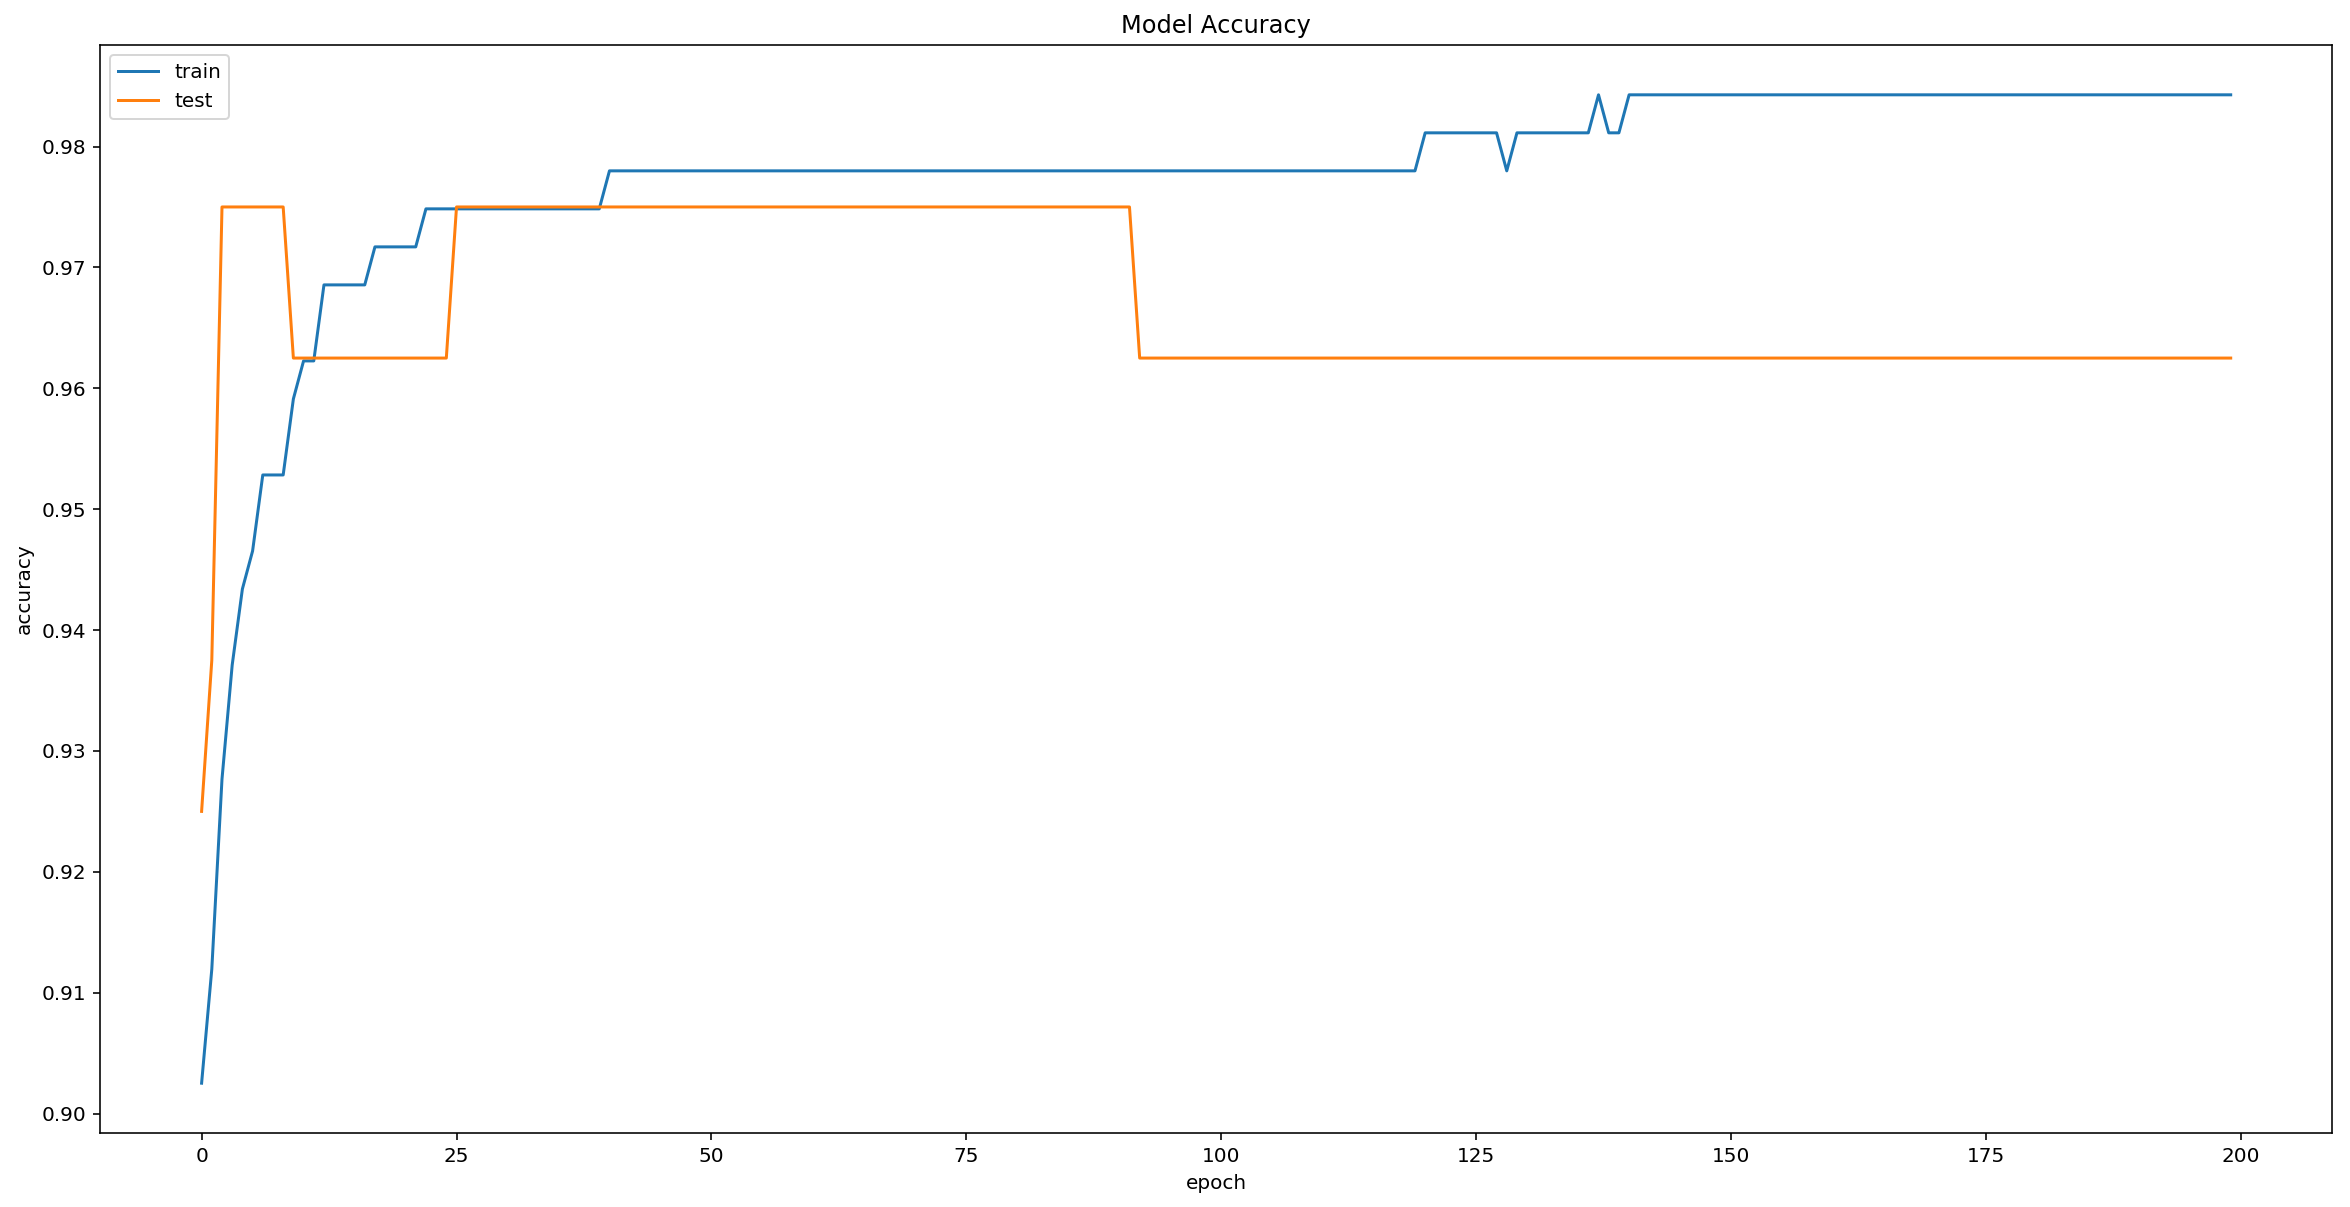

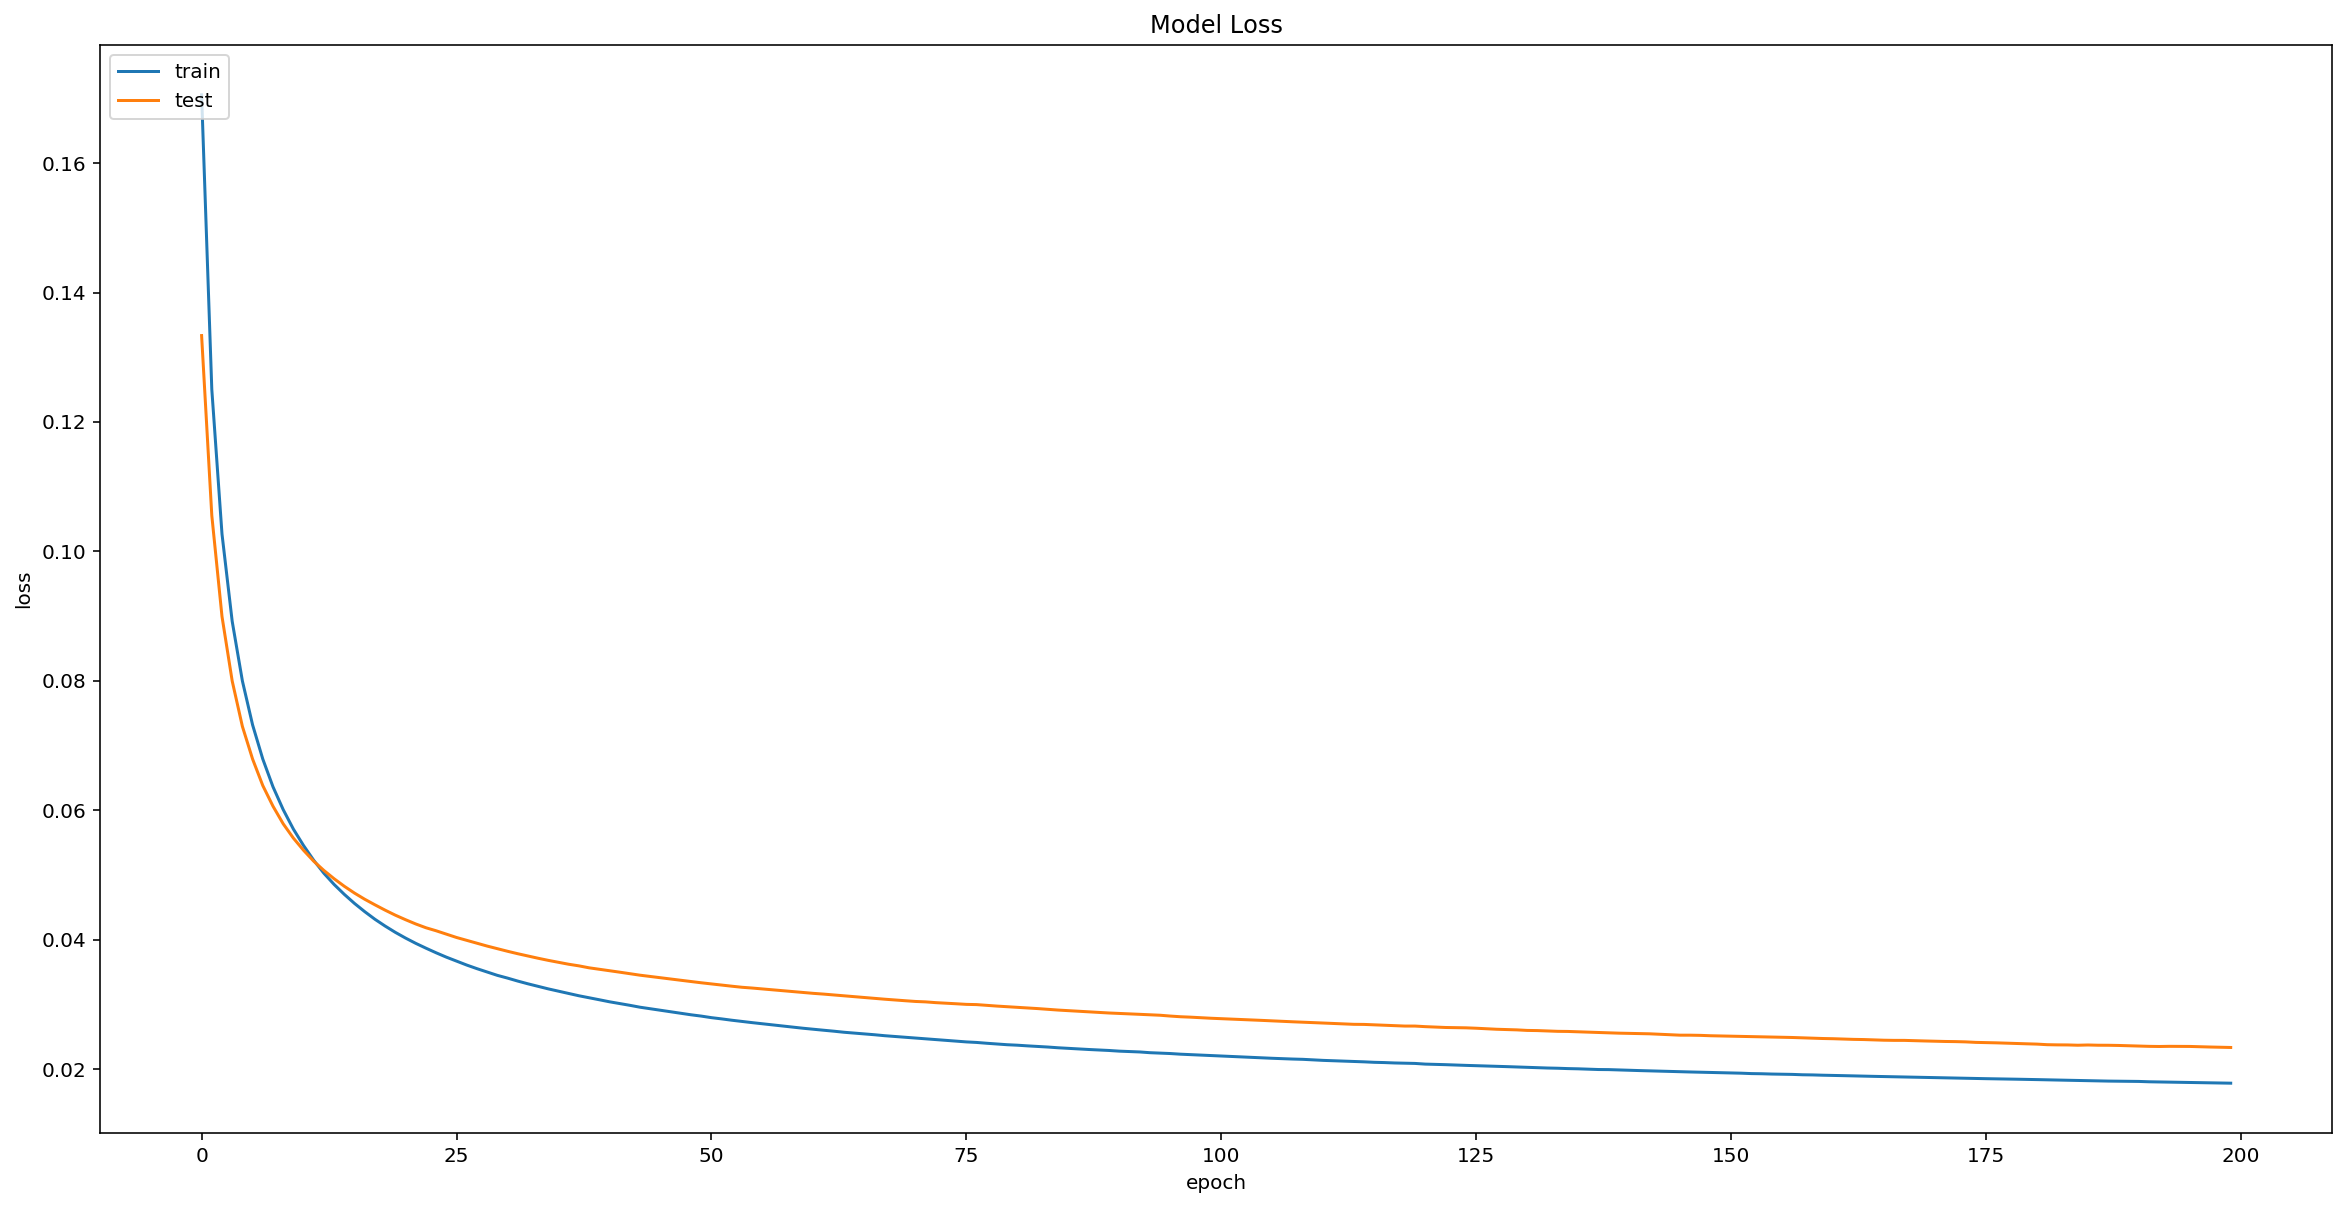

Memory Usage 1.30 MB
Time of Processing 4.83s
Accuracy 98.25%


In [49]:
show_info(model9, X_test_norm, y_test, keras_history9)

In [50]:
# Building the model 10
model10 = Sequential()
model10.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model10.add(Dense(64, activation='tanh'))
model10.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
model10.compile(loss = 'mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model10.summary()

# Training the model 10
keras_history10 = KerasHistory()
memory_usage = monitor(target=train(model10, X_train_norm, y_train, keras_history10, epochs=200, batch_size=15))
keras_history10.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/200
 - 0s - loss: 0.1836 - acc: 0.8239 - val_loss: 0.1290 - val_acc: 0.9375
Epoch 2/200
 - 0s - loss: 0.1090 - acc: 0.9340 - val_loss: 0.0929 - val_acc: 0.9375
Epoch 3/200
 - 0s - loss: 0.0833 - acc: 0.9465 - val_loss: 0.0765 - val_acc: 0.9500
Epoch 4/200
 - 0s - loss: 0.0703 - acc: 0.9560 - val_loss: 0.0671 - val_acc: 0.9500
Epoch 5/200
 - 0s - l

Epoch 89/200
 - 0s - loss: 0.0188 - acc: 0.9843 - val_loss: 0.0247 - val_acc: 0.9625
Epoch 90/200
 - 0s - loss: 0.0187 - acc: 0.9843 - val_loss: 0.0247 - val_acc: 0.9625
Epoch 91/200
 - 0s - loss: 0.0187 - acc: 0.9843 - val_loss: 0.0246 - val_acc: 0.9625
Epoch 92/200
 - 0s - loss: 0.0186 - acc: 0.9843 - val_loss: 0.0246 - val_acc: 0.9625
Epoch 93/200
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0245 - val_acc: 0.9625
Epoch 94/200
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0245 - val_acc: 0.9625
Epoch 95/200
 - 0s - loss: 0.0184 - acc: 0.9843 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 96/200
 - 0s - loss: 0.0183 - acc: 0.9843 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 97/200
 - 0s - loss: 0.0183 - acc: 0.9843 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 98/200
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 99/200
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0240 - val_acc: 0.9625
Epoch 100/200
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.02

Epoch 185/200
 - 0s - loss: 0.0150 - acc: 0.9874 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 186/200
 - 0s - loss: 0.0150 - acc: 0.9843 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 187/200
 - 0s - loss: 0.0149 - acc: 0.9874 - val_loss: 0.0209 - val_acc: 0.9750
Epoch 188/200
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0206 - val_acc: 0.9750
Epoch 189/200
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0206 - val_acc: 0.9750
Epoch 190/200
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 191/200
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 192/200
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 193/200
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 194/200
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 195/200
 - 0s - loss: 0.0147 - acc: 0.9843 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 196/200
 - 0s - loss: 0.0147 - acc: 0.9843 - val

## Treinamento 10
Para o treinamento 10 foram utilizados os seguintes hiperparametros:

Épocas = 200

Batchsize = 15

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Podemos observar que o melhor resultado do modelo foi com batches menores, nesse último treinamento com batch de 15 obtivemos o melhor resultado.

Nesse ciclo podemos observar os resultados abaixo:

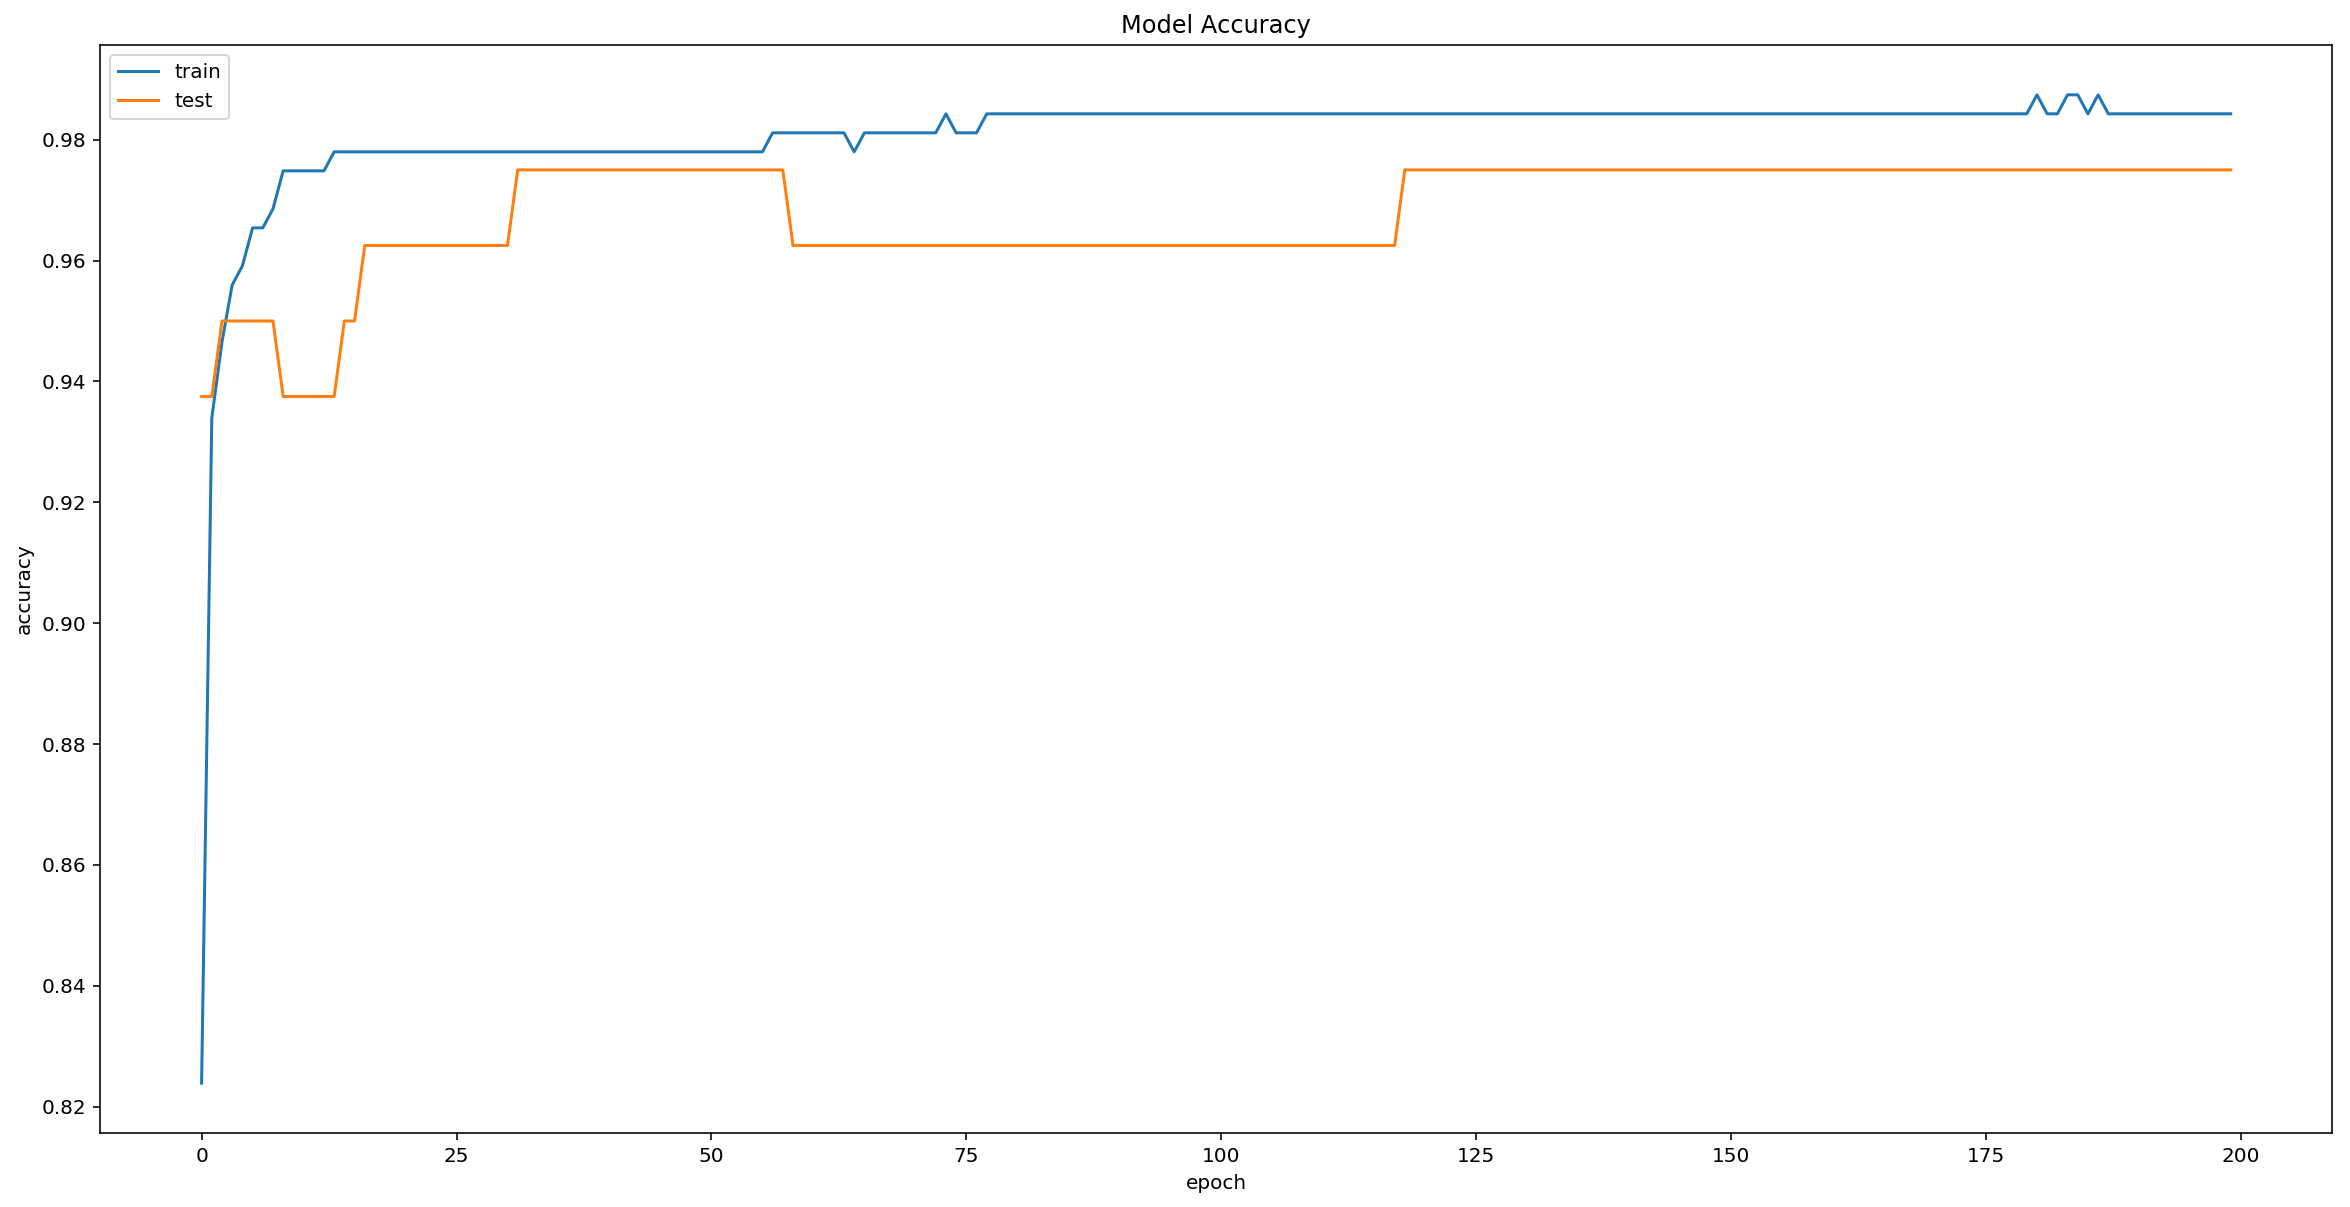

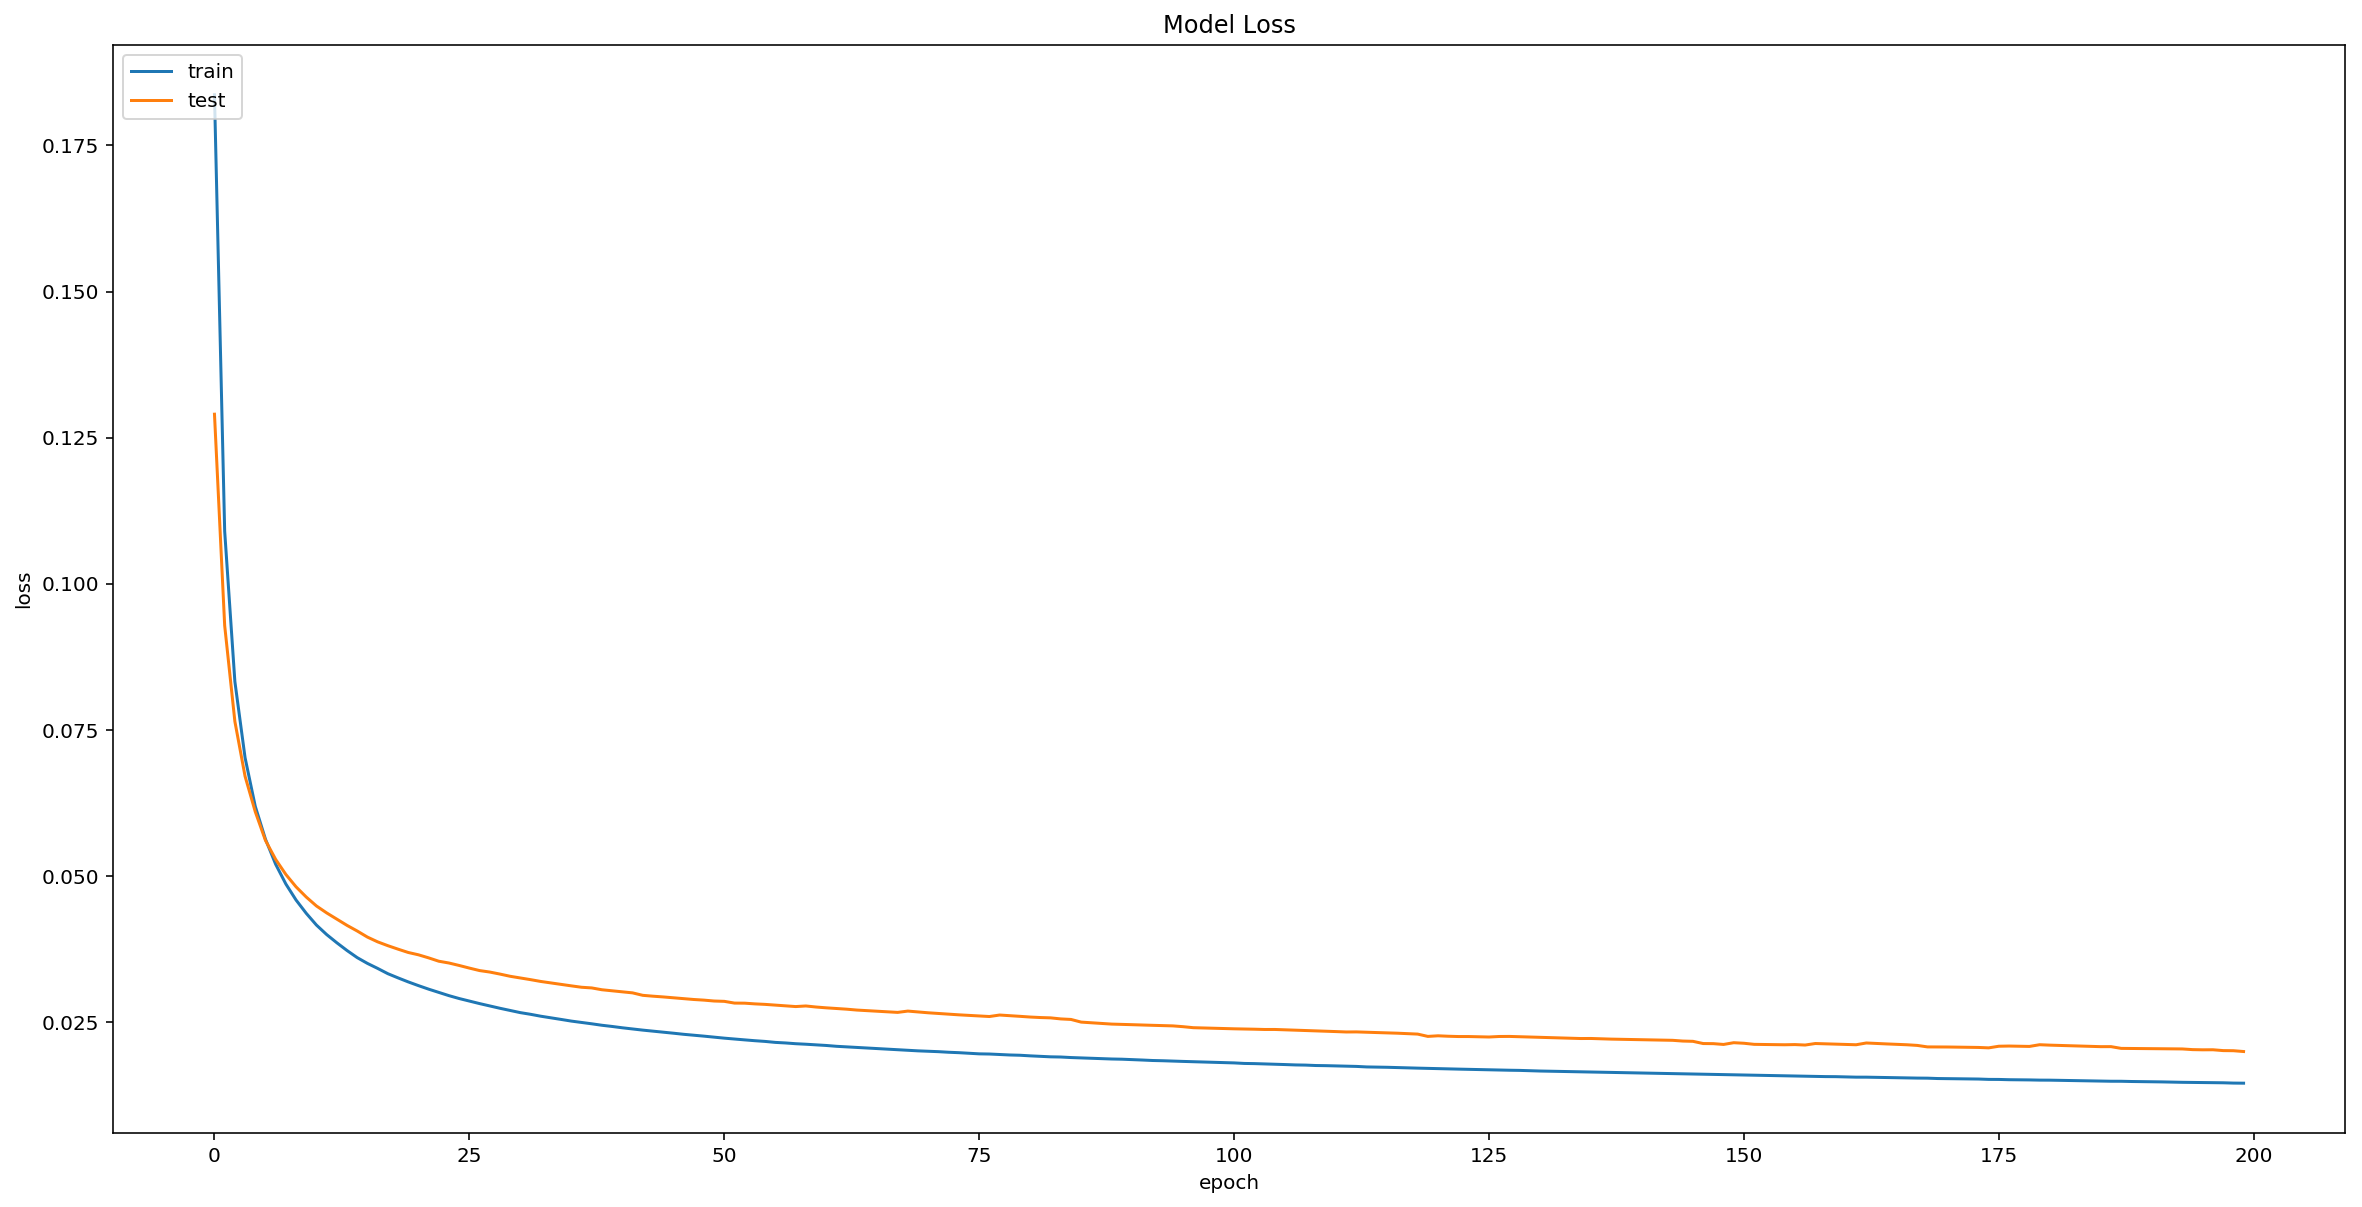

Memory Usage 1.15 MB
Time of Processing 8.06s
Accuracy 98.83%


In [51]:
show_info(model10, X_test_norm, y_test, keras_history10)

## Respostas da questão 3

In [52]:
# Building the model 11
model11 = Sequential()
model11.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model11.add(Dense(64, activation='tanh'))
model11.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd11 = optimizers.SGD(lr=0.001)
model11.compile(loss = 'mean_squared_error', optimizer=sgd11, metrics=['accuracy'])
model11.summary()

# Training the model 11
keras_history11 = KerasHistory()
memory_usage = monitor(target=train(model11, X_train_norm, y_train, keras_history11, epochs=500, batch_size=15))
keras_history11.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.2531 - acc: 0.4906 - val_loss: 0.2350 - val_acc: 0.6875
Epoch 2/500
 - 0s - loss: 0.2339 - acc: 0.7579 - val_loss: 0.2172 - val_acc: 0.8250
Epoch 3/500
 - 0s - loss: 0.2173 - acc: 0.8365 - val_loss: 0.2023 - val_acc: 0.8875
Epoch 4/500
 - 0s - loss: 0.2032 - acc: 0.8868 - val_loss: 0.1891 - val_acc: 0.9125
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0496 - acc: 0.9686 - val_loss: 0.0509 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0493 - acc: 0.9686 - val_loss: 0.0506 - val_acc: 0.9500
Epoch 91/500
 - 0s - loss: 0.0491 - acc: 0.9686 - val_loss: 0.0504 - val_acc: 0.9500
Epoch 92/500
 - 0s - loss: 0.0488 - acc: 0.9686 - val_loss: 0.0502 - val_acc: 0.9500
Epoch 93/500
 - 0s - loss: 0.0486 - acc: 0.9686 - val_loss: 0.0500 - val_acc: 0.9500
Epoch 94/500
 - 0s - loss: 0.0483 - acc: 0.9686 - val_loss: 0.0498 - val_acc: 0.9500
Epoch 95/500
 - 0s - loss: 0.0481 - acc: 0.9686 - val_loss: 0.0496 - val_acc: 0.9500
Epoch 96/500
 - 0s - loss: 0.0478 - acc: 0.9686 - val_loss: 0.0494 - val_acc: 0.9500
Epoch 97/500
 - 0s - loss: 0.0476 - acc: 0.9686 - val_loss: 0.0492 - val_acc: 0.9500
Epoch 98/500
 - 0s - loss: 0.0473 - acc: 0.9686 - val_loss: 0.0490 - val_acc: 0.9500
Epoch 99/500
 - 0s - loss: 0.0471 - acc: 0.9686 - val_loss: 0.0488 - val_acc: 0.9500
Epoch 100/500
 - 0s - loss: 0.0469 - acc: 0.9686 - val_loss: 0.04

Epoch 185/500
 - 0s - loss: 0.0350 - acc: 0.9717 - val_loss: 0.0391 - val_acc: 0.9625
Epoch 186/500
 - 0s - loss: 0.0349 - acc: 0.9717 - val_loss: 0.0390 - val_acc: 0.9625
Epoch 187/500
 - 0s - loss: 0.0348 - acc: 0.9717 - val_loss: 0.0390 - val_acc: 0.9625
Epoch 188/500
 - 0s - loss: 0.0348 - acc: 0.9717 - val_loss: 0.0389 - val_acc: 0.9625
Epoch 189/500
 - 0s - loss: 0.0347 - acc: 0.9717 - val_loss: 0.0388 - val_acc: 0.9625
Epoch 190/500
 - 0s - loss: 0.0346 - acc: 0.9717 - val_loss: 0.0388 - val_acc: 0.9625
Epoch 191/500
 - 0s - loss: 0.0345 - acc: 0.9717 - val_loss: 0.0387 - val_acc: 0.9625
Epoch 192/500
 - 0s - loss: 0.0344 - acc: 0.9717 - val_loss: 0.0386 - val_acc: 0.9625
Epoch 193/500
 - 0s - loss: 0.0343 - acc: 0.9717 - val_loss: 0.0386 - val_acc: 0.9625
Epoch 194/500
 - 0s - loss: 0.0343 - acc: 0.9717 - val_loss: 0.0385 - val_acc: 0.9625
Epoch 195/500
 - 0s - loss: 0.0342 - acc: 0.9717 - val_loss: 0.0384 - val_acc: 0.9625
Epoch 196/500
 - 0s - loss: 0.0341 - acc: 0.9717 - val

Epoch 281/500
 - 0s - loss: 0.0291 - acc: 0.9780 - val_loss: 0.0344 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0290 - acc: 0.9780 - val_loss: 0.0344 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0290 - acc: 0.9780 - val_loss: 0.0343 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0290 - acc: 0.9780 - val_loss: 0.0343 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0289 - acc: 0.9780 - val_loss: 0.0343 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0289 - acc: 0.9780 - val_loss: 0.0342 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0288 - acc: 0.9780 - val_loss: 0.0342 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0288 - acc: 0.9780 - val_loss: 0.0342 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0287 - acc: 0.9780 - val_loss: 0.0341 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0287 - acc: 0.9780 - val_loss: 0.0341 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0287 - acc: 0.9780 - val_loss: 0.0340 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0286 - acc: 0.9780 - val

Epoch 377/500
 - 0s - loss: 0.0258 - acc: 0.9780 - val_loss: 0.0317 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0257 - acc: 0.9780 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0257 - acc: 0.9780 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0257 - acc: 0.9780 - val_loss: 0.0316 - val_acc: 0.9750
Epoch 381/500
 - 0s - loss: 0.0257 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0256 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0256 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0256 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0255 - acc: 0.9780 - val_loss: 0.0315 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0255 - acc: 0.9780 - val_loss: 0.0314 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0255 - acc: 0.9780 - val_loss: 0.0314 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0255 - acc: 0.9780 - val

Epoch 473/500
 - 0s - loss: 0.0236 - acc: 0.9811 - val_loss: 0.0298 - val_acc: 0.9750
Epoch 474/500
 - 0s - loss: 0.0236 - acc: 0.9811 - val_loss: 0.0298 - val_acc: 0.9750
Epoch 475/500
 - 0s - loss: 0.0236 - acc: 0.9811 - val_loss: 0.0298 - val_acc: 0.9750
Epoch 476/500
 - 0s - loss: 0.0235 - acc: 0.9811 - val_loss: 0.0298 - val_acc: 0.9750
Epoch 477/500
 - 0s - loss: 0.0235 - acc: 0.9811 - val_loss: 0.0298 - val_acc: 0.9750
Epoch 478/500
 - 0s - loss: 0.0235 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9750
Epoch 479/500
 - 0s - loss: 0.0235 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9750
Epoch 480/500
 - 0s - loss: 0.0235 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9750
Epoch 481/500
 - 0s - loss: 0.0234 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9750
Epoch 482/500
 - 0s - loss: 0.0234 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9750
Epoch 483/500
 - 0s - loss: 0.0234 - acc: 0.9811 - val_loss: 0.0296 - val_acc: 0.9750
Epoch 484/500
 - 0s - loss: 0.0234 - acc: 0.9811 - val

## Treinamento 11
Para o treinamento 11 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.001

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

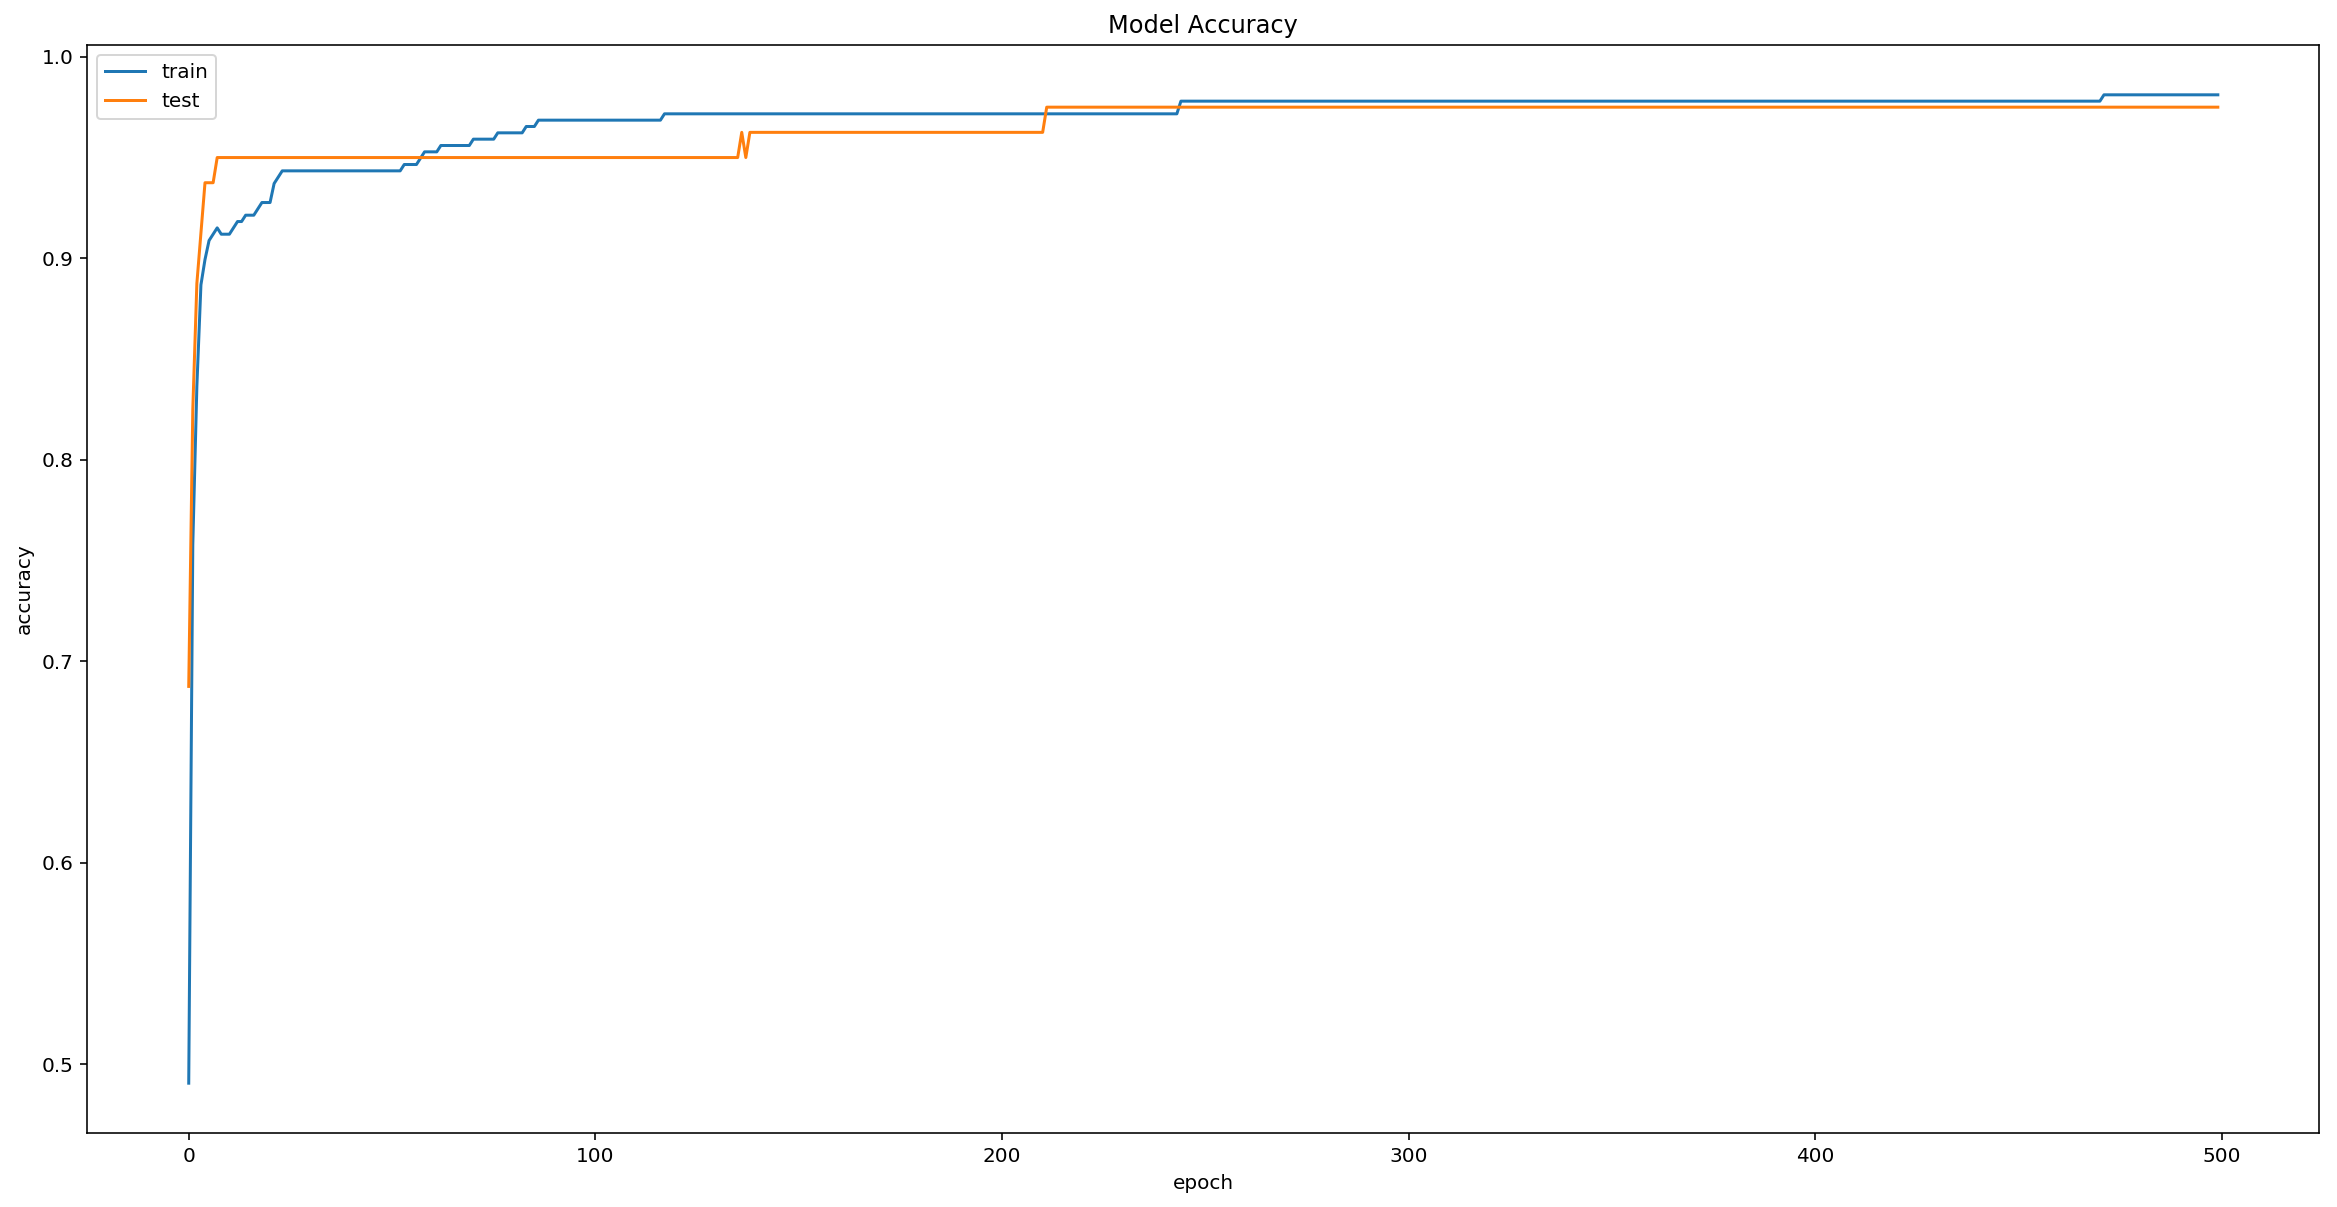

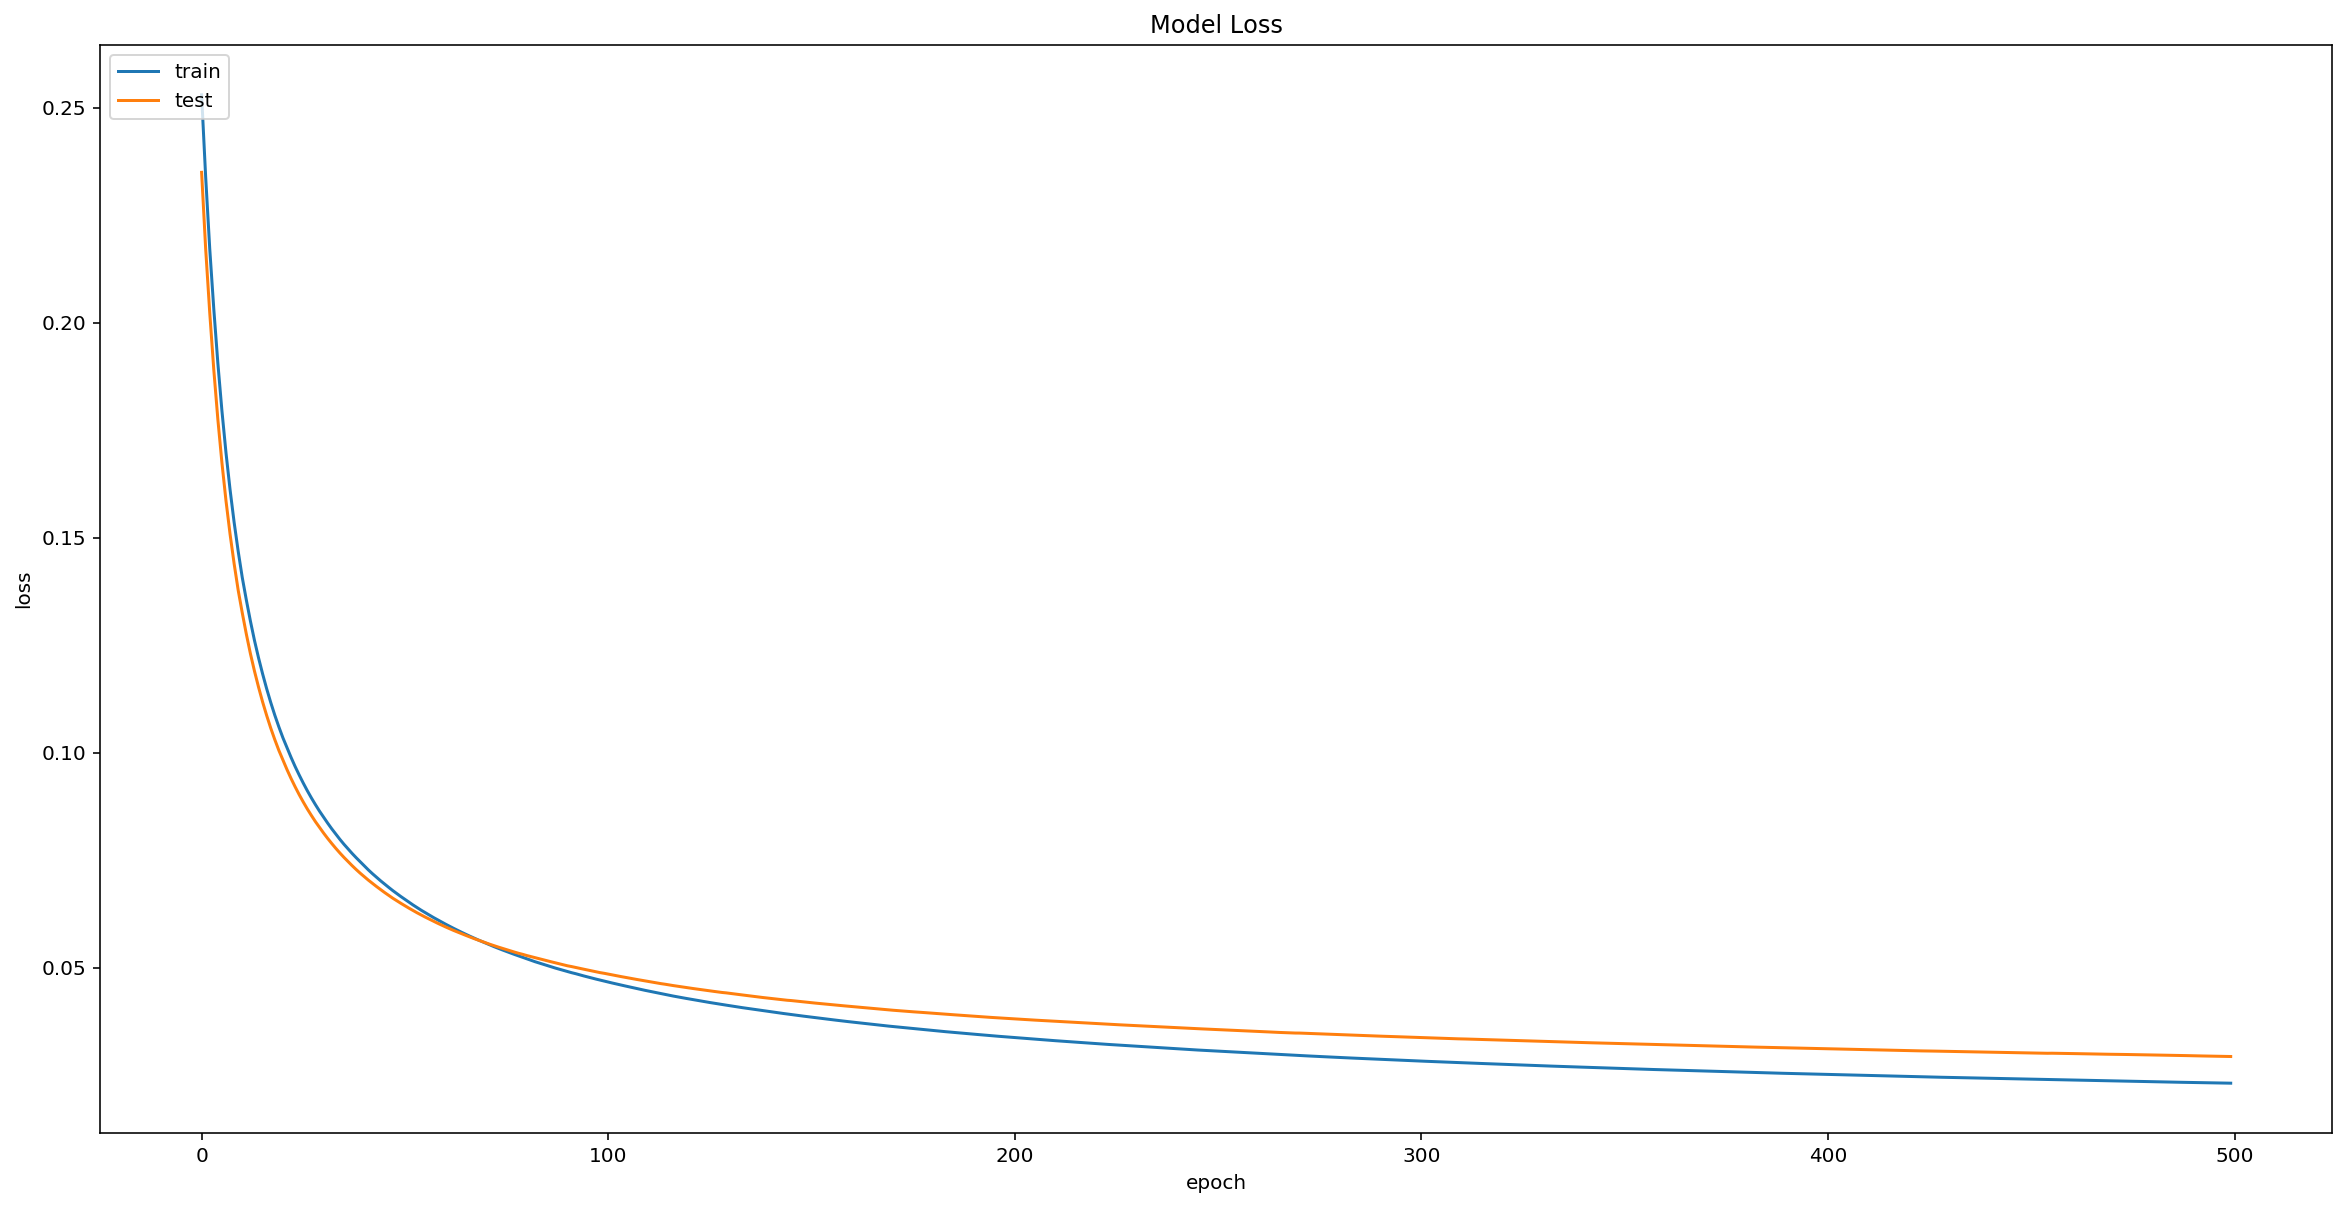

Memory Usage 1.07 MB
Time of Processing 17.56s
Accuracy 98.25%


In [53]:
show_info(model11, X_test_norm, y_test, keras_history11)

In [54]:
# Building the model 12
model12 = Sequential()
model12.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model12.add(Dense(64, activation='tanh'))
model12.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd12 = optimizers.SGD(lr=0.009)
model12.compile(loss = 'mean_squared_error', optimizer=sgd12, metrics=['accuracy'])
model12.summary()

# Training the model 12
keras_history12 = KerasHistory()
memory_usage = monitor(target=train(model12, X_train_norm, y_train, keras_history12, epochs=500, batch_size=15))
keras_history12.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.1675 - acc: 0.8711 - val_loss: 0.1249 - val_acc: 0.9250
Epoch 2/500
 - 0s - loss: 0.1069 - acc: 0.9277 - val_loss: 0.0928 - val_acc: 0.9375
Epoch 3/500
 - 0s - loss: 0.0846 - acc: 0.9340 - val_loss: 0.0774 - val_acc: 0.9500
Epoch 4/500
 - 0s - loss: 0.0728 - acc: 0.9371 - val_loss: 0.0683 - val_acc: 0.9500
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0194 - acc: 0.9843 - val_loss: 0.0251 - val_acc: 0.9625
Epoch 90/500
 - 0s - loss: 0.0194 - acc: 0.9843 - val_loss: 0.0249 - val_acc: 0.9625
Epoch 91/500
 - 0s - loss: 0.0193 - acc: 0.9843 - val_loss: 0.0248 - val_acc: 0.9625
Epoch 92/500
 - 0s - loss: 0.0192 - acc: 0.9843 - val_loss: 0.0247 - val_acc: 0.9625
Epoch 93/500
 - 0s - loss: 0.0192 - acc: 0.9843 - val_loss: 0.0246 - val_acc: 0.9625
Epoch 94/500
 - 0s - loss: 0.0191 - acc: 0.9843 - val_loss: 0.0247 - val_acc: 0.9625
Epoch 95/500
 - 0s - loss: 0.0190 - acc: 0.9843 - val_loss: 0.0246 - val_acc: 0.9625
Epoch 96/500
 - 0s - loss: 0.0190 - acc: 0.9843 - val_loss: 0.0245 - val_acc: 0.9625
Epoch 97/500
 - 0s - loss: 0.0189 - acc: 0.9843 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 98/500
 - 0s - loss: 0.0189 - acc: 0.9843 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 99/500
 - 0s - loss: 0.0188 - acc: 0.9843 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 100/500
 - 0s - loss: 0.0187 - acc: 0.9843 - val_loss: 0.02

Epoch 185/500
 - 0s - loss: 0.0155 - acc: 0.9843 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0155 - acc: 0.9843 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0155 - acc: 0.9843 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0154 - acc: 0.9843 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 189/500
 - 0s - loss: 0.0154 - acc: 0.9843 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0154 - acc: 0.9843 - val_loss: 0.0202 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0154 - acc: 0.9843 - val_loss: 0.0205 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0153 - acc: 0.9843 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0153 - acc: 0.9843 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0153 - acc: 0.9843 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0153 - acc: 0.9843 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0152 - acc: 0.9843 - val

Epoch 281/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0187 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0187 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0134 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0133 - acc: 0.9874 - val

Epoch 377/500
 - 0s - loss: 0.0119 - acc: 0.9874 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9625
Epoch 381/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0201 - val_acc: 0.9625
Epoch 383/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0201 - val_acc: 0.9625
Epoch 384/500
 - 0s - loss: 0.0118 - acc: 0.9874 - val_loss: 0.0201 - val_acc: 0.9625
Epoch 385/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0202 - val_acc: 0.9625
Epoch 386/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0203 - val_acc: 0.9625
Epoch 387/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val_loss: 0.0204 - val_acc: 0.9625
Epoch 388/500
 - 0s - loss: 0.0117 - acc: 0.9874 - val

Epoch 473/500
 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 474/500
 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 475/500
 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 476/500
 - 0s - loss: 0.0106 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 477/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 478/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0231 - val_acc: 0.9625
Epoch 479/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0232 - val_acc: 0.9625
Epoch 480/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0232 - val_acc: 0.9625
Epoch 481/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0233 - val_acc: 0.9625
Epoch 482/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0233 - val_acc: 0.9625
Epoch 483/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val_loss: 0.0233 - val_acc: 0.9625
Epoch 484/500
 - 0s - loss: 0.0105 - acc: 0.9874 - val

## Treinamento 12
Para o treinamento 12 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.009

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

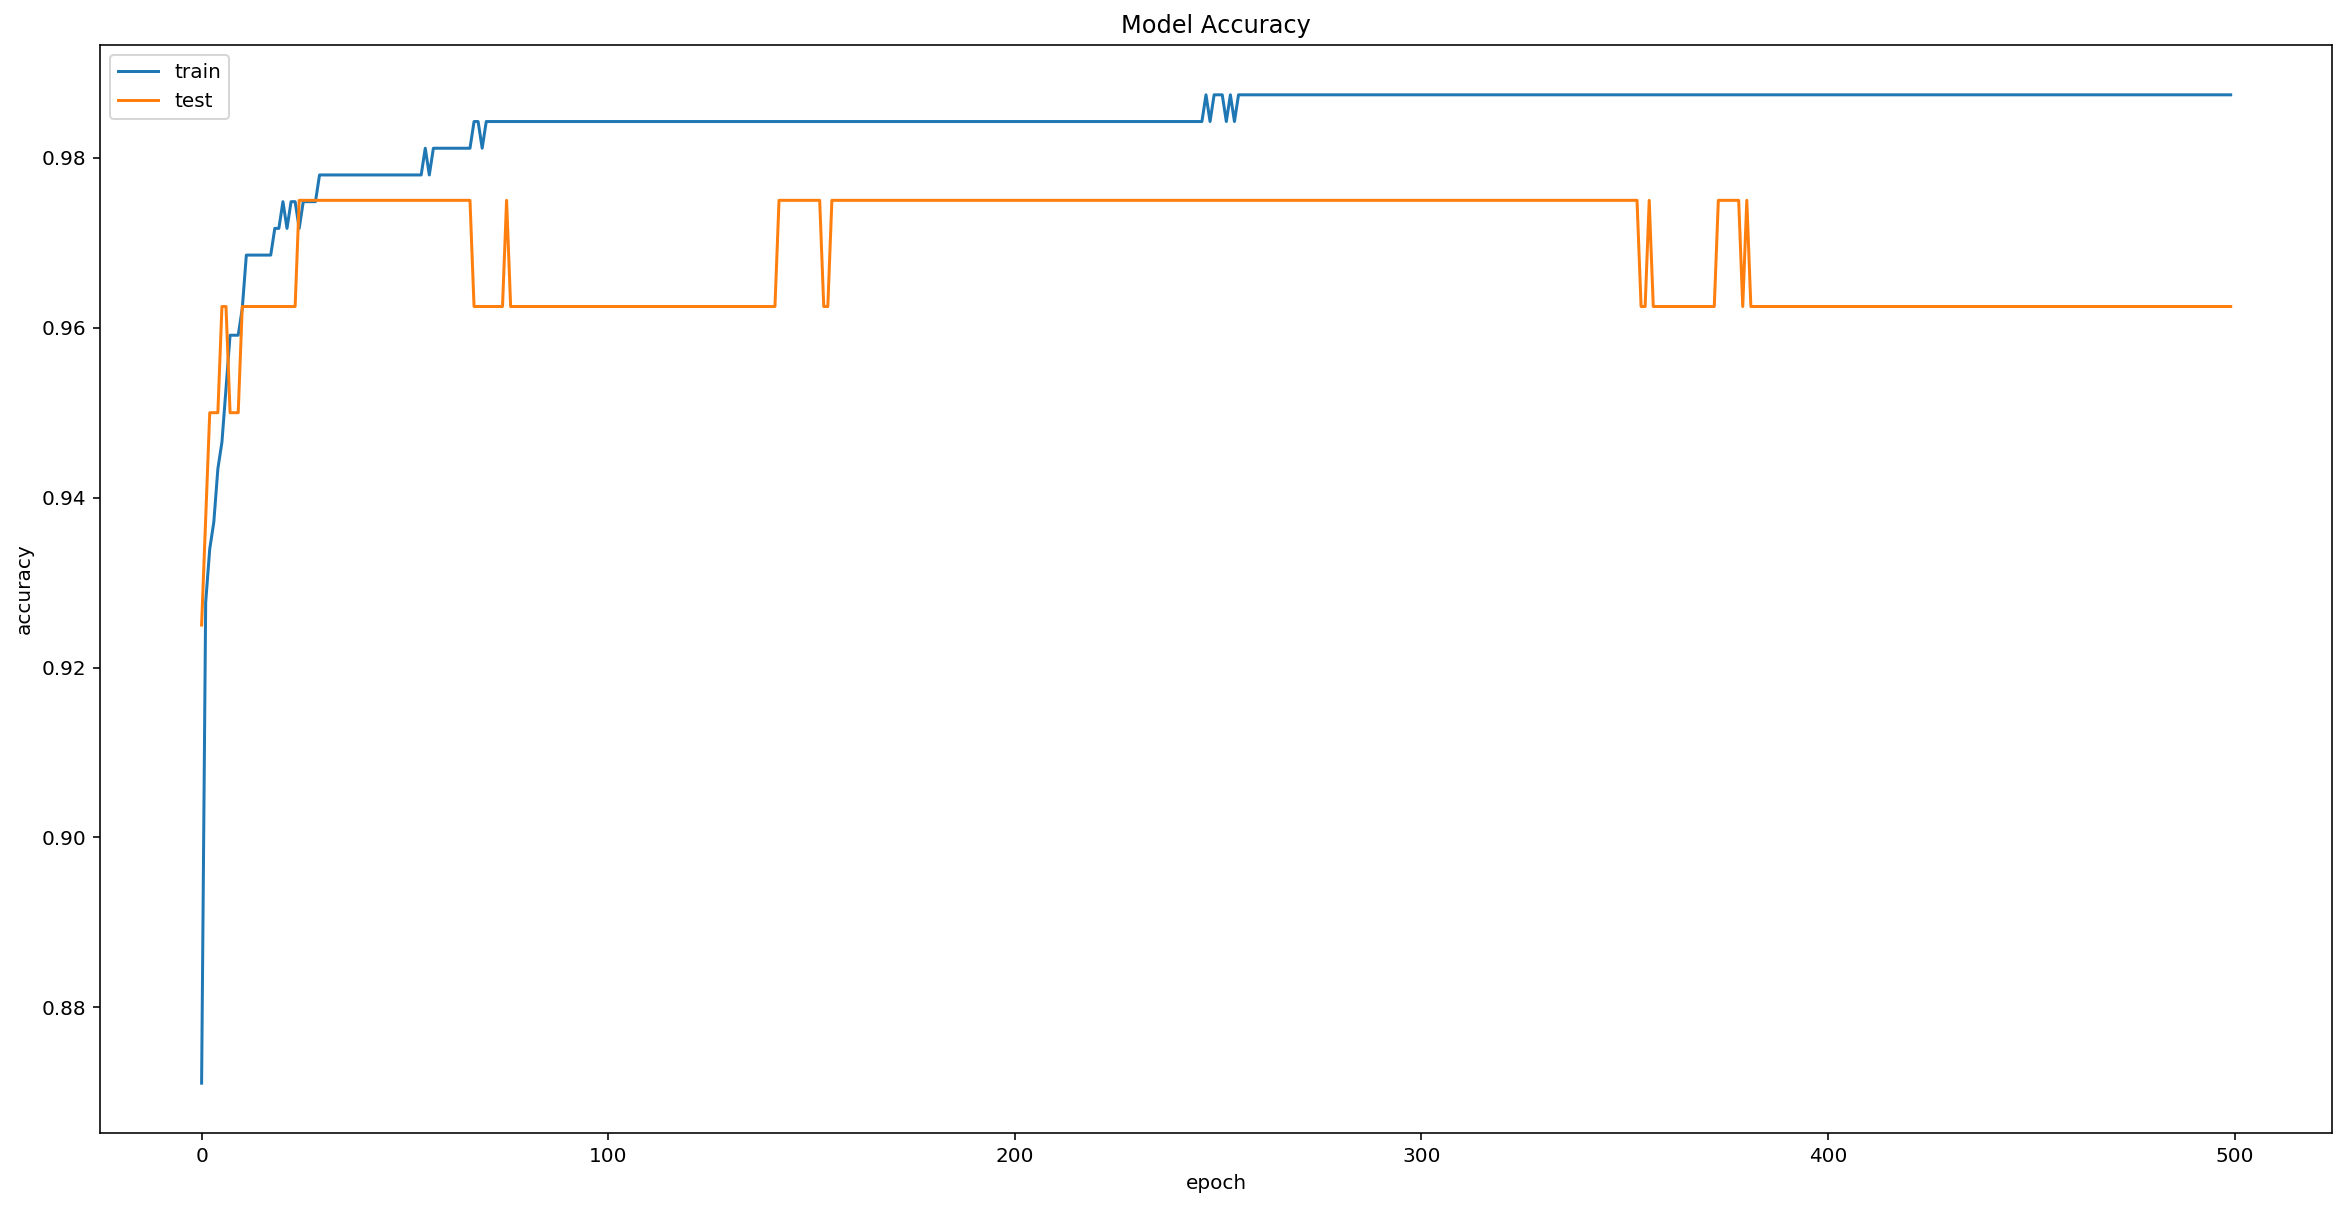

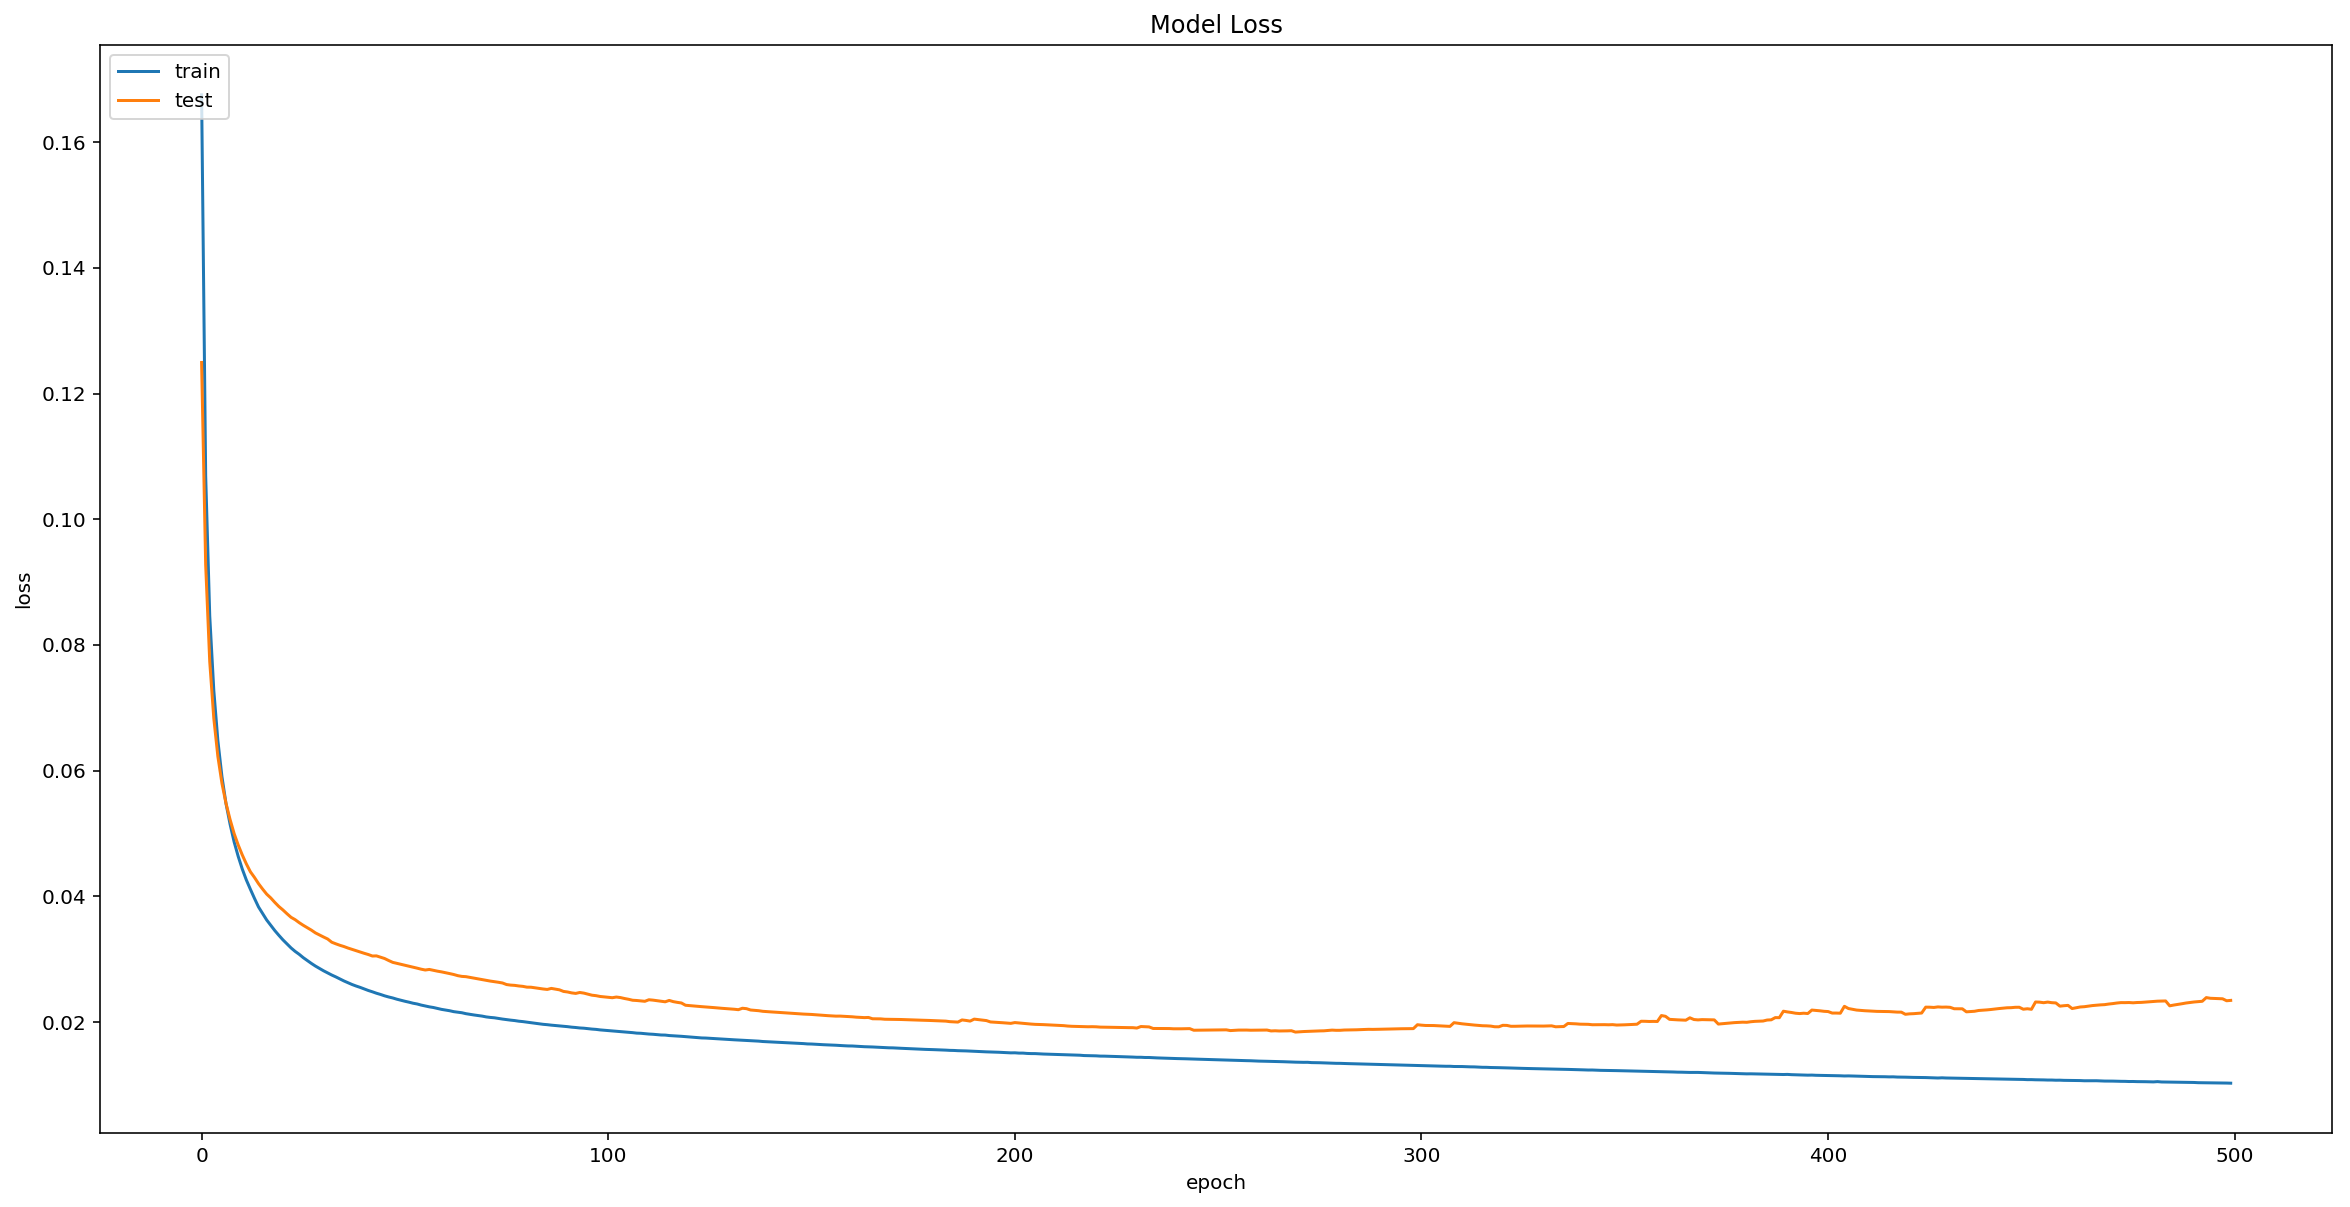

Memory Usage 0.15 MB
Time of Processing 18.31s
Accuracy 97.08%


In [55]:
show_info(model12, X_test_norm, y_test, keras_history12)

In [56]:
# Building the model 13
model13 = Sequential()
model13.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model13.add(Dense(64, activation='tanh'))
model13.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd13 = optimizers.SGD(lr=0.01)
model13.compile(loss = 'mean_squared_error', optimizer=sgd13, metrics=['accuracy'])
model13.summary()

# Training the model 13
keras_history13 = KerasHistory()
memory_usage = monitor(target=train(model13, X_train_norm, y_train, keras_history13, epochs=500, batch_size=15))
keras_history13.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.1586 - acc: 0.8931 - val_loss: 0.1081 - val_acc: 0.9500
Epoch 2/500
 - 0s - loss: 0.0955 - acc: 0.9434 - val_loss: 0.0807 - val_acc: 0.9500
Epoch 3/500
 - 0s - loss: 0.0749 - acc: 0.9434 - val_loss: 0.0676 - val_acc: 0.9500
Epoch 4/500
 - 0s - loss: 0.0641 - acc: 0.9434 - val_loss: 0.0603 - val_acc: 0.9500
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0187 - acc: 0.9843 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 90/500
 - 0s - loss: 0.0186 - acc: 0.9843 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 91/500
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0231 - val_acc: 0.9750
Epoch 92/500
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0233 - val_acc: 0.9750
Epoch 93/500
 - 0s - loss: 0.0184 - acc: 0.9843 - val_loss: 0.0232 - val_acc: 0.9750
Epoch 94/500
 - 0s - loss: 0.0184 - acc: 0.9843 - val_loss: 0.0231 - val_acc: 0.9750
Epoch 95/500
 - 0s - loss: 0.0183 - acc: 0.9843 - val_loss: 0.0230 - val_acc: 0.9750
Epoch 96/500
 - 0s - loss: 0.0183 - acc: 0.9843 - val_loss: 0.0229 - val_acc: 0.9750
Epoch 97/500
 - 0s - loss: 0.0182 - acc: 0.9843 - val_loss: 0.0229 - val_acc: 0.9750
Epoch 98/500
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0227 - val_acc: 0.9750
Epoch 99/500
 - 0s - loss: 0.0181 - acc: 0.9843 - val_loss: 0.0226 - val_acc: 0.9750
Epoch 100/500
 - 0s - loss: 0.0180 - acc: 0.9843 - val_loss: 0.02

Epoch 185/500
 - 0s - loss: 0.0150 - acc: 0.9843 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 189/500
 - 0s - loss: 0.0149 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0148 - acc: 0.9843 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0147 - acc: 0.9843 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0147 - acc: 0.9843 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0147 - acc: 0.9843 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0146 - acc: 0.9843 - val

Epoch 281/500
 - 0s - loss: 0.0128 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0128 - acc: 0.9874 - val_loss: 0.0190 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0186 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0127 - acc: 0.9874 - val_loss: 0.0187 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0188 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0126 - acc: 0.9874 - val_loss: 0.0189 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0126 - acc: 0.9874 - val

Epoch 377/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0218 - val_acc: 0.9625
Epoch 378/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0218 - val_acc: 0.9625
Epoch 379/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0216 - val_acc: 0.9625
Epoch 380/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0207 - val_acc: 0.9625
Epoch 381/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0209 - val_acc: 0.9625
Epoch 382/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0210 - val_acc: 0.9625
Epoch 383/500
 - 0s - loss: 0.0111 - acc: 0.9874 - val_loss: 0.0212 - val_acc: 0.9625
Epoch 384/500
 - 0s - loss: 0.0110 - acc: 0.9874 - val_loss: 0.0213 - val_acc: 0.9625
Epoch 385/500
 - 0s - loss: 0.0110 - acc: 0.9874 - val_loss: 0.0208 - val_acc: 0.9625
Epoch 386/500
 - 0s - loss: 0.0110 - acc: 0.9874 - val_loss: 0.0208 - val_acc: 0.9625
Epoch 387/500
 - 0s - loss: 0.0110 - acc: 0.9874 - val_loss: 0.0210 - val_acc: 0.9625
Epoch 388/500
 - 0s - loss: 0.0110 - acc: 0.9874 - val

Epoch 473/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 474/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 475/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 476/500
 - 0s - loss: 0.0099 - acc: 0.9906 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 477/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 478/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 479/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 480/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 481/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 482/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0240 - val_acc: 0.9625
Epoch 483/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 484/500
 - 0s - loss: 0.0098 - acc: 0.9906 - val

## Treinamento 13
Para o treinamento 13 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.01

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação.

Nesse ciclo podemos observar os resultados abaixo:

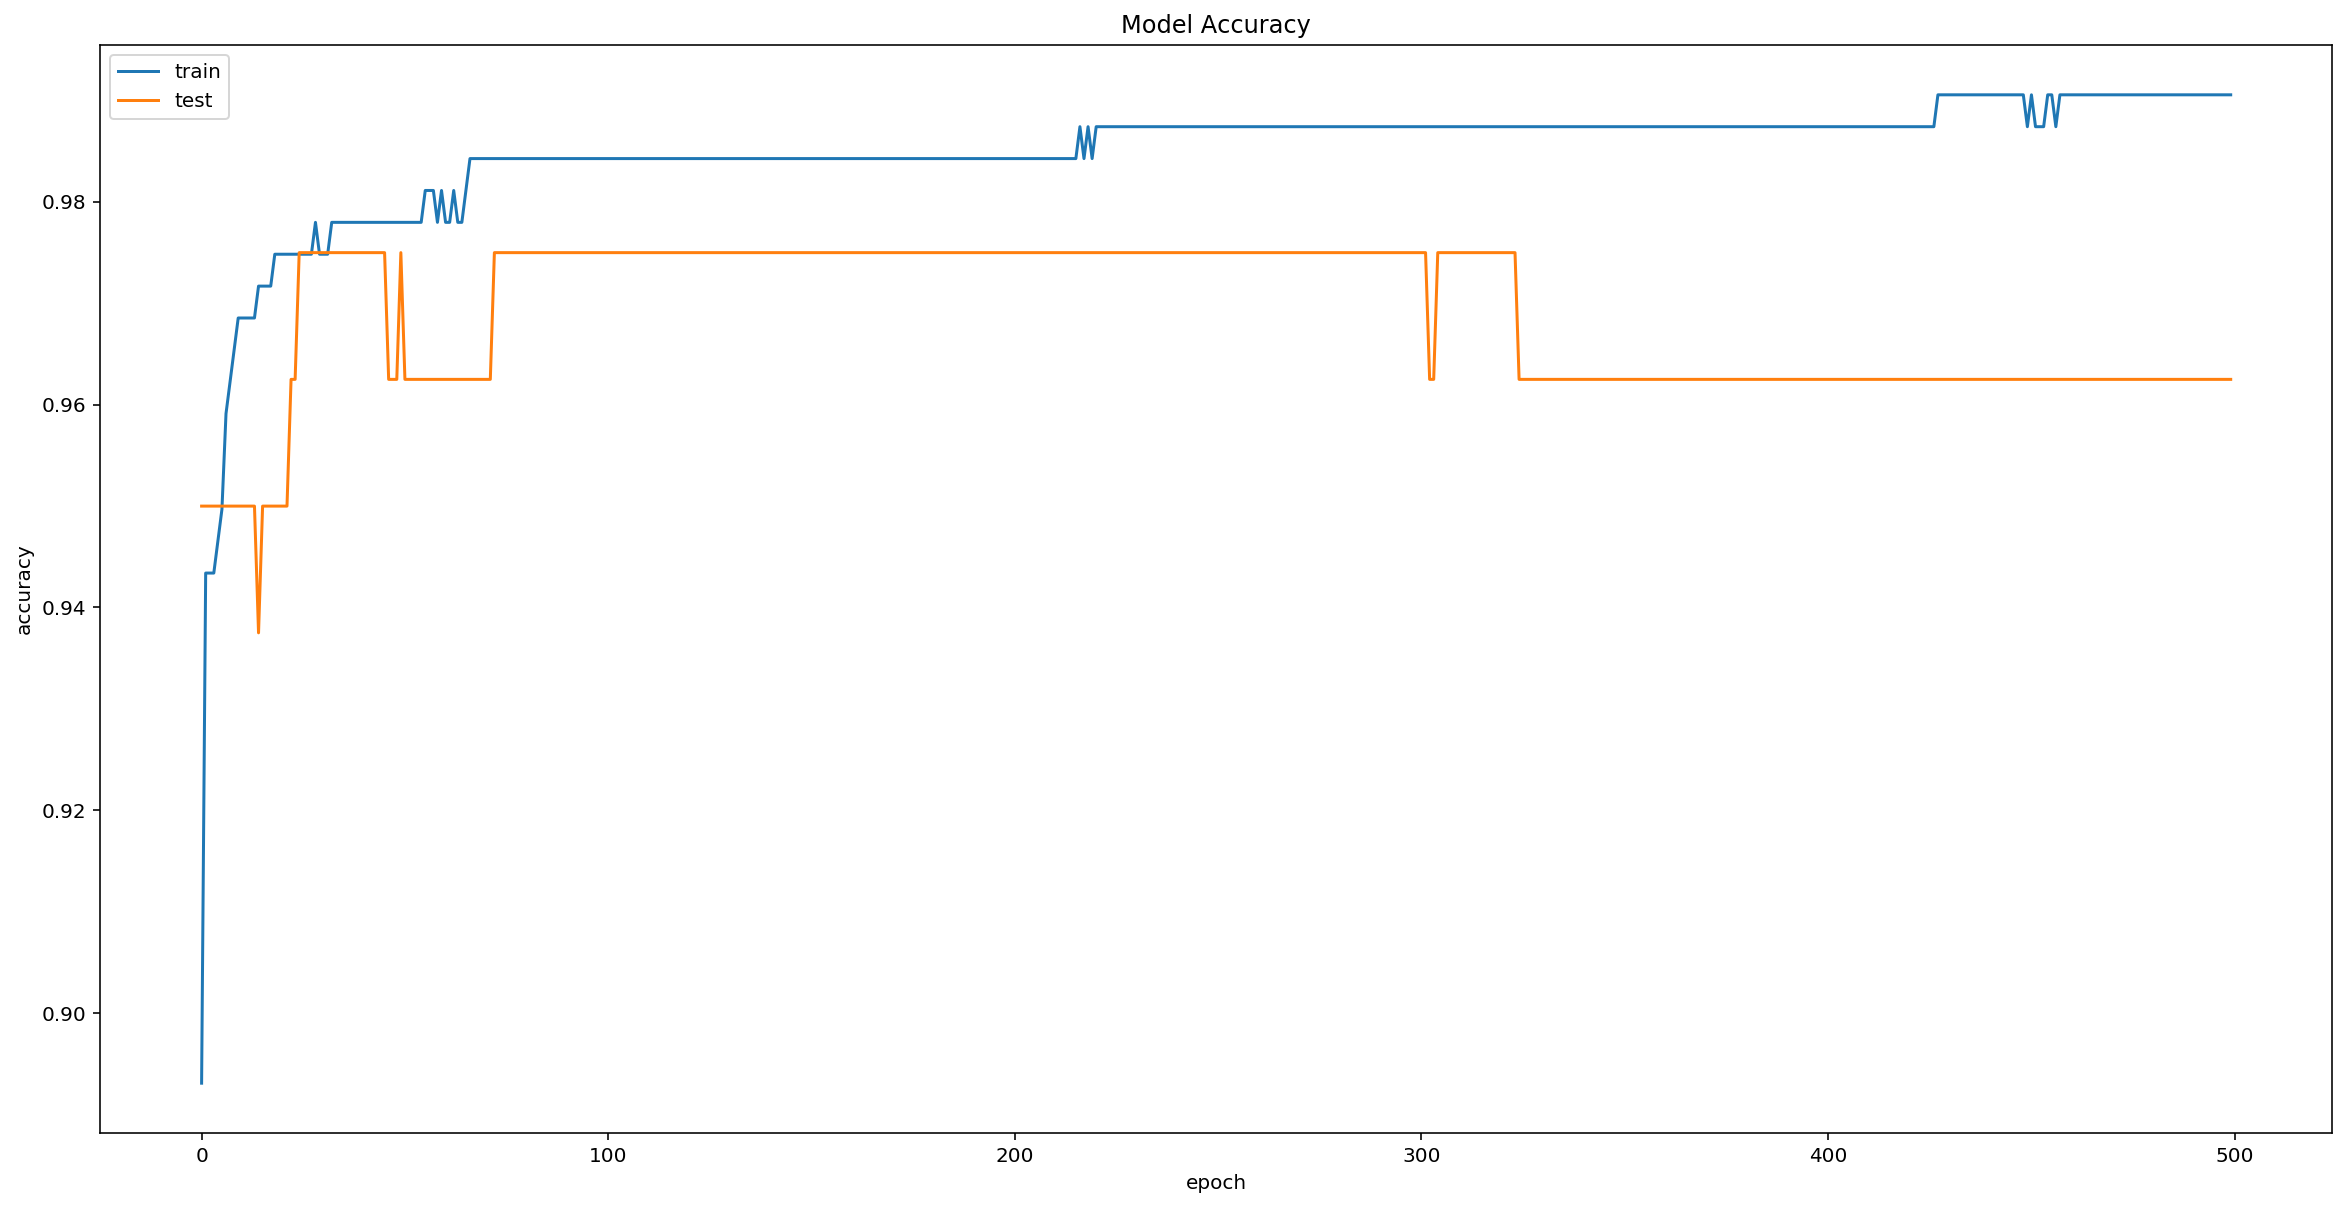

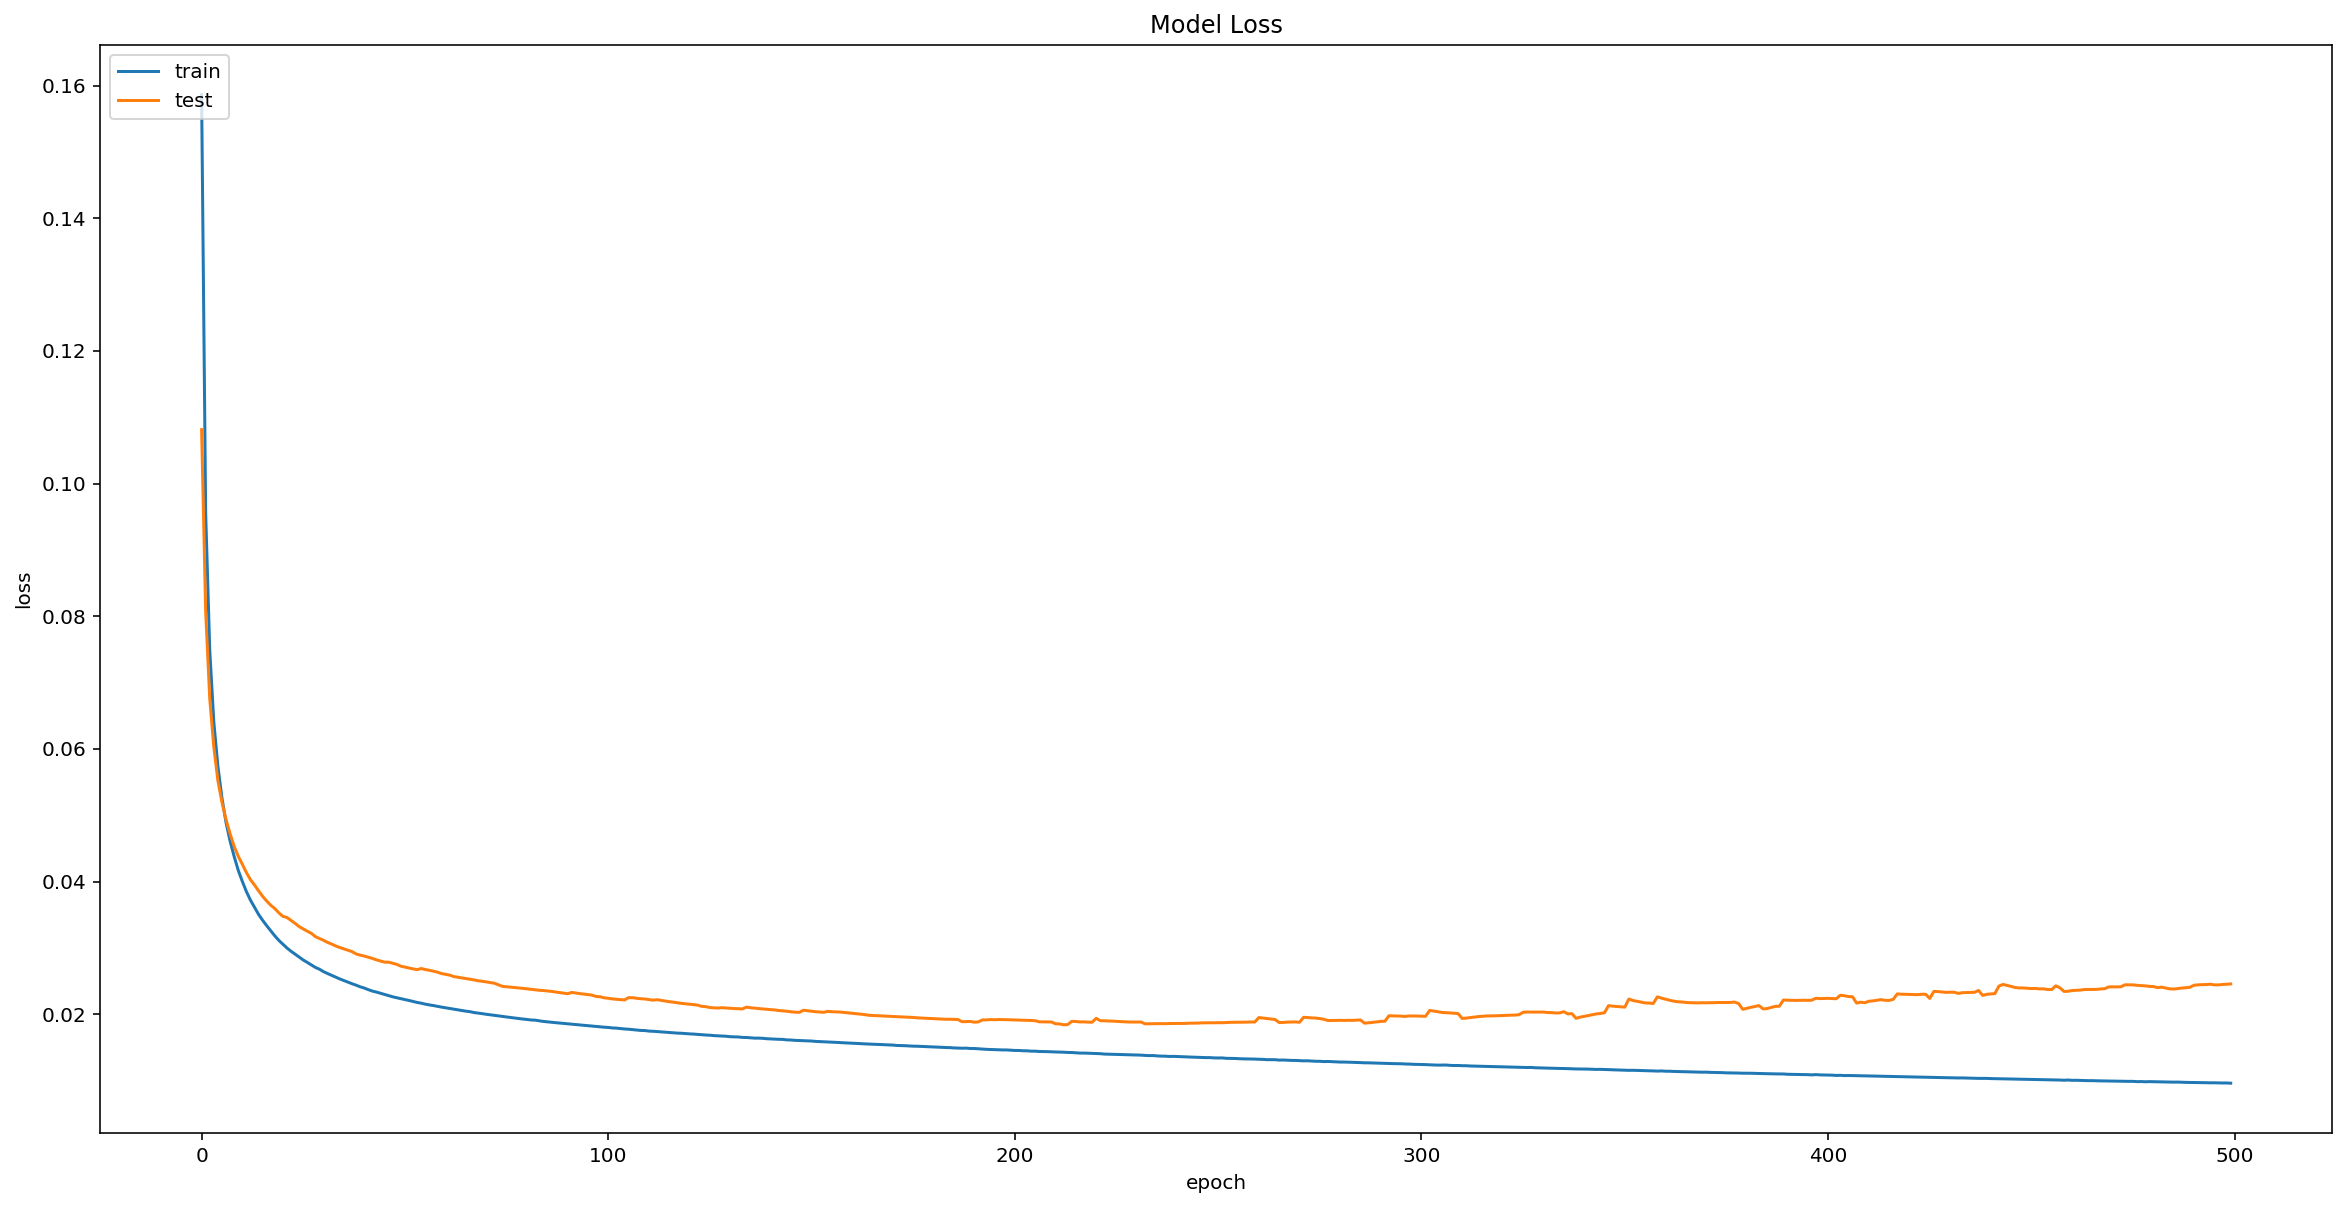

Memory Usage 1.32 MB
Time of Processing 18.13s
Accuracy 96.49%


In [58]:
show_info(model13, X_test_norm, y_test, keras_history13)

In [60]:
# Building the model 14
model14 = Sequential()
model14.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model14.add(Dense(64, activation='tanh'))
model14.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd14 = optimizers.SGD(lr=0.5)
model14.compile(loss = 'mean_squared_error', optimizer=sgd14, metrics=['accuracy'])
model14.summary()

# Training the model 14
keras_history14 = KerasHistory()
memory_usage = monitor(target=train(model14, X_train_norm, y_train, keras_history14, epochs=500, batch_size=15))
keras_history14.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.0479 - acc: 0.9277 - val_loss: 0.0273 - val_acc: 0.9625
Epoch 2/500
 - 0s - loss: 0.0239 - acc: 0.9717 - val_loss: 0.0249 - val_acc: 0.9500
Epoch 3/500
 - 0s - loss: 0.0224 - acc: 0.9717 - val_loss: 0.0217 - val_acc: 0.9750
Epoch 4/500
 - 0s - loss: 0.0219 - acc: 0.9654 - val_loss: 0.0169 - val_acc: 0.9875
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0036 - acc: 0.9969 - val_loss: 0.0401 - val_acc: 0.9500
Epoch 90/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0397 - val_acc: 0.9500
Epoch 91/500
 - 0s - loss: 0.0036 - acc: 0.9969 - val_loss: 0.0413 - val_acc: 0.9500
Epoch 92/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0396 - val_acc: 0.9500
Epoch 93/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0411 - val_acc: 0.9500
Epoch 94/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0400 - val_acc: 0.9500
Epoch 95/500
 - 0s - loss: 0.0036 - acc: 0.9969 - val_loss: 0.0405 - val_acc: 0.9500
Epoch 96/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0408 - val_acc: 0.9375
Epoch 97/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0414 - val_acc: 0.9375
Epoch 98/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0415 - val_acc: 0.9500
Epoch 99/500
 - 0s - loss: 0.0035 - acc: 0.9969 - val_loss: 0.0414 - val_acc: 0.9500
Epoch 100/500
 - 0s - loss: 0.0034 - acc: 0.9969 - val_loss: 0.03

Epoch 185/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 186/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 187/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 188/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 189/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 190/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0447 - val_acc: 0.9375
Epoch 191/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0447 - val_acc: 0.9375
Epoch 192/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0447 - val_acc: 0.9375
Epoch 193/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0448 - val_acc: 0.9375
Epoch 194/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0445 - val_acc: 0.9375
Epoch 195/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0446 - val_acc: 0.9375
Epoch 196/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val

Epoch 281/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0455 - val_acc: 0.9375
Epoch 282/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 283/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 284/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 285/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 286/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0455 - val_acc: 0.9375
Epoch 287/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0455 - val_acc: 0.9375
Epoch 288/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 289/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 290/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0454 - val_acc: 0.9375
Epoch 291/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0455 - val_acc: 0.9375
Epoch 292/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val

Epoch 377/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 378/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 379/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 380/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 381/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 382/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 383/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 384/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 385/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0463 - val_acc: 0.9375
Epoch 386/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0462 - val_acc: 0.9375
Epoch 387/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0462 - val_acc: 0.9375
Epoch 388/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val

Epoch 473/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 474/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 475/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 476/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 477/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 478/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 479/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 480/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 481/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 482/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0464 - val_acc: 0.9375
Epoch 483/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val_loss: 0.0462 - val_acc: 0.9375
Epoch 484/500
 - 0s - loss: 0.0032 - acc: 0.9969 - val

## Treinamento 14
Para o treinamento 14 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.5

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Nesse modelo como a taxa de aprendizado é muito alta o modelo "aprende" muito rápido, o que pode não ser o ideal, pois pode achar um mínimo local.

Nesse ciclo podemos observar os resultados abaixo:

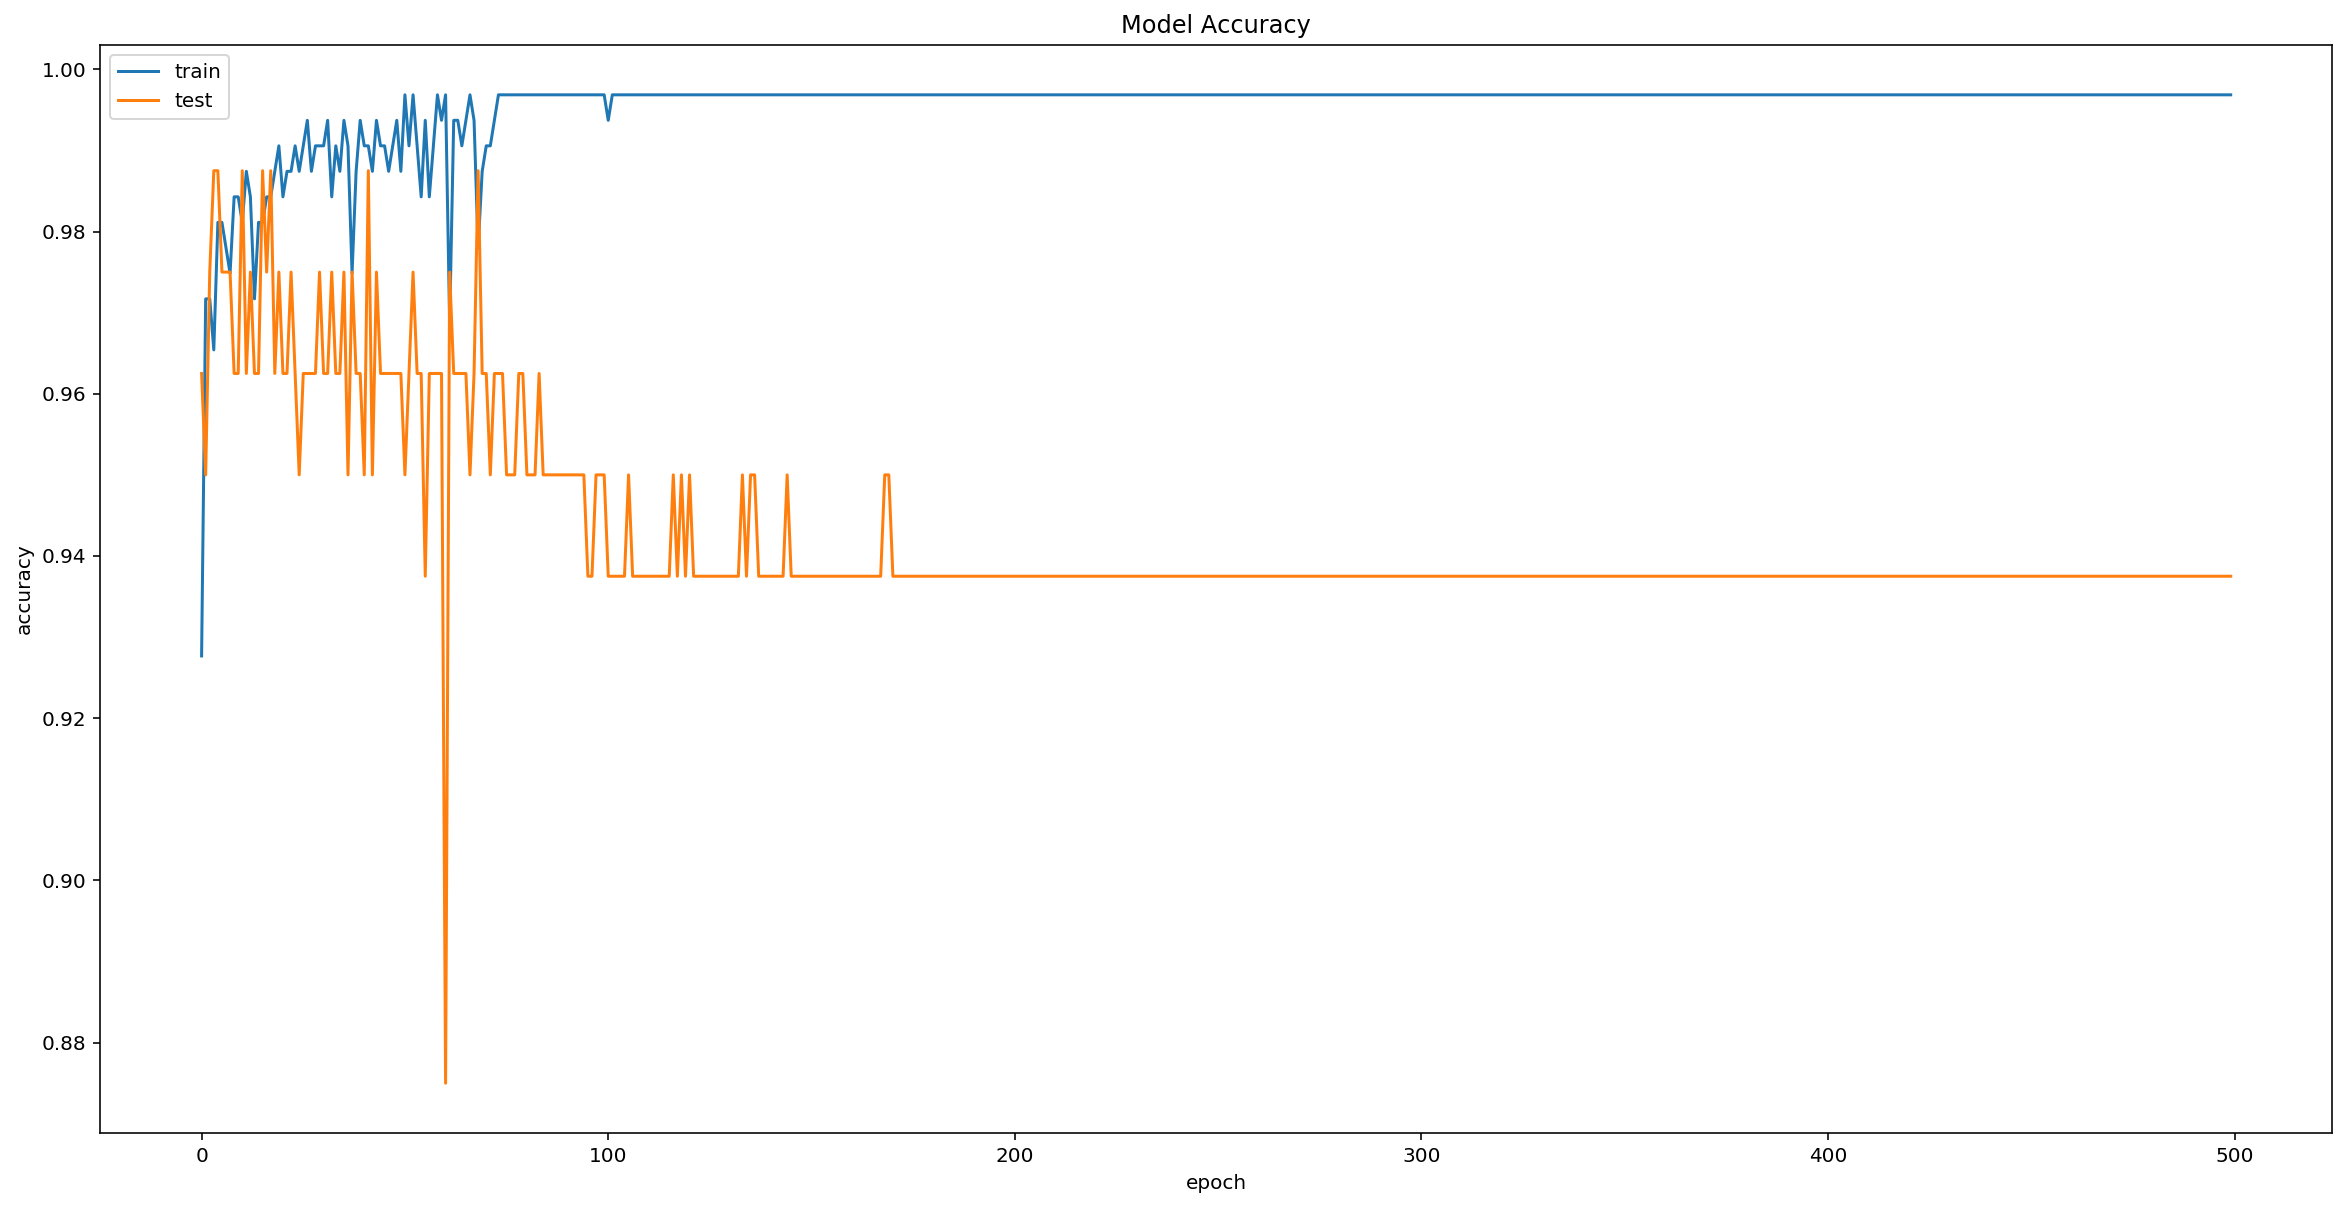

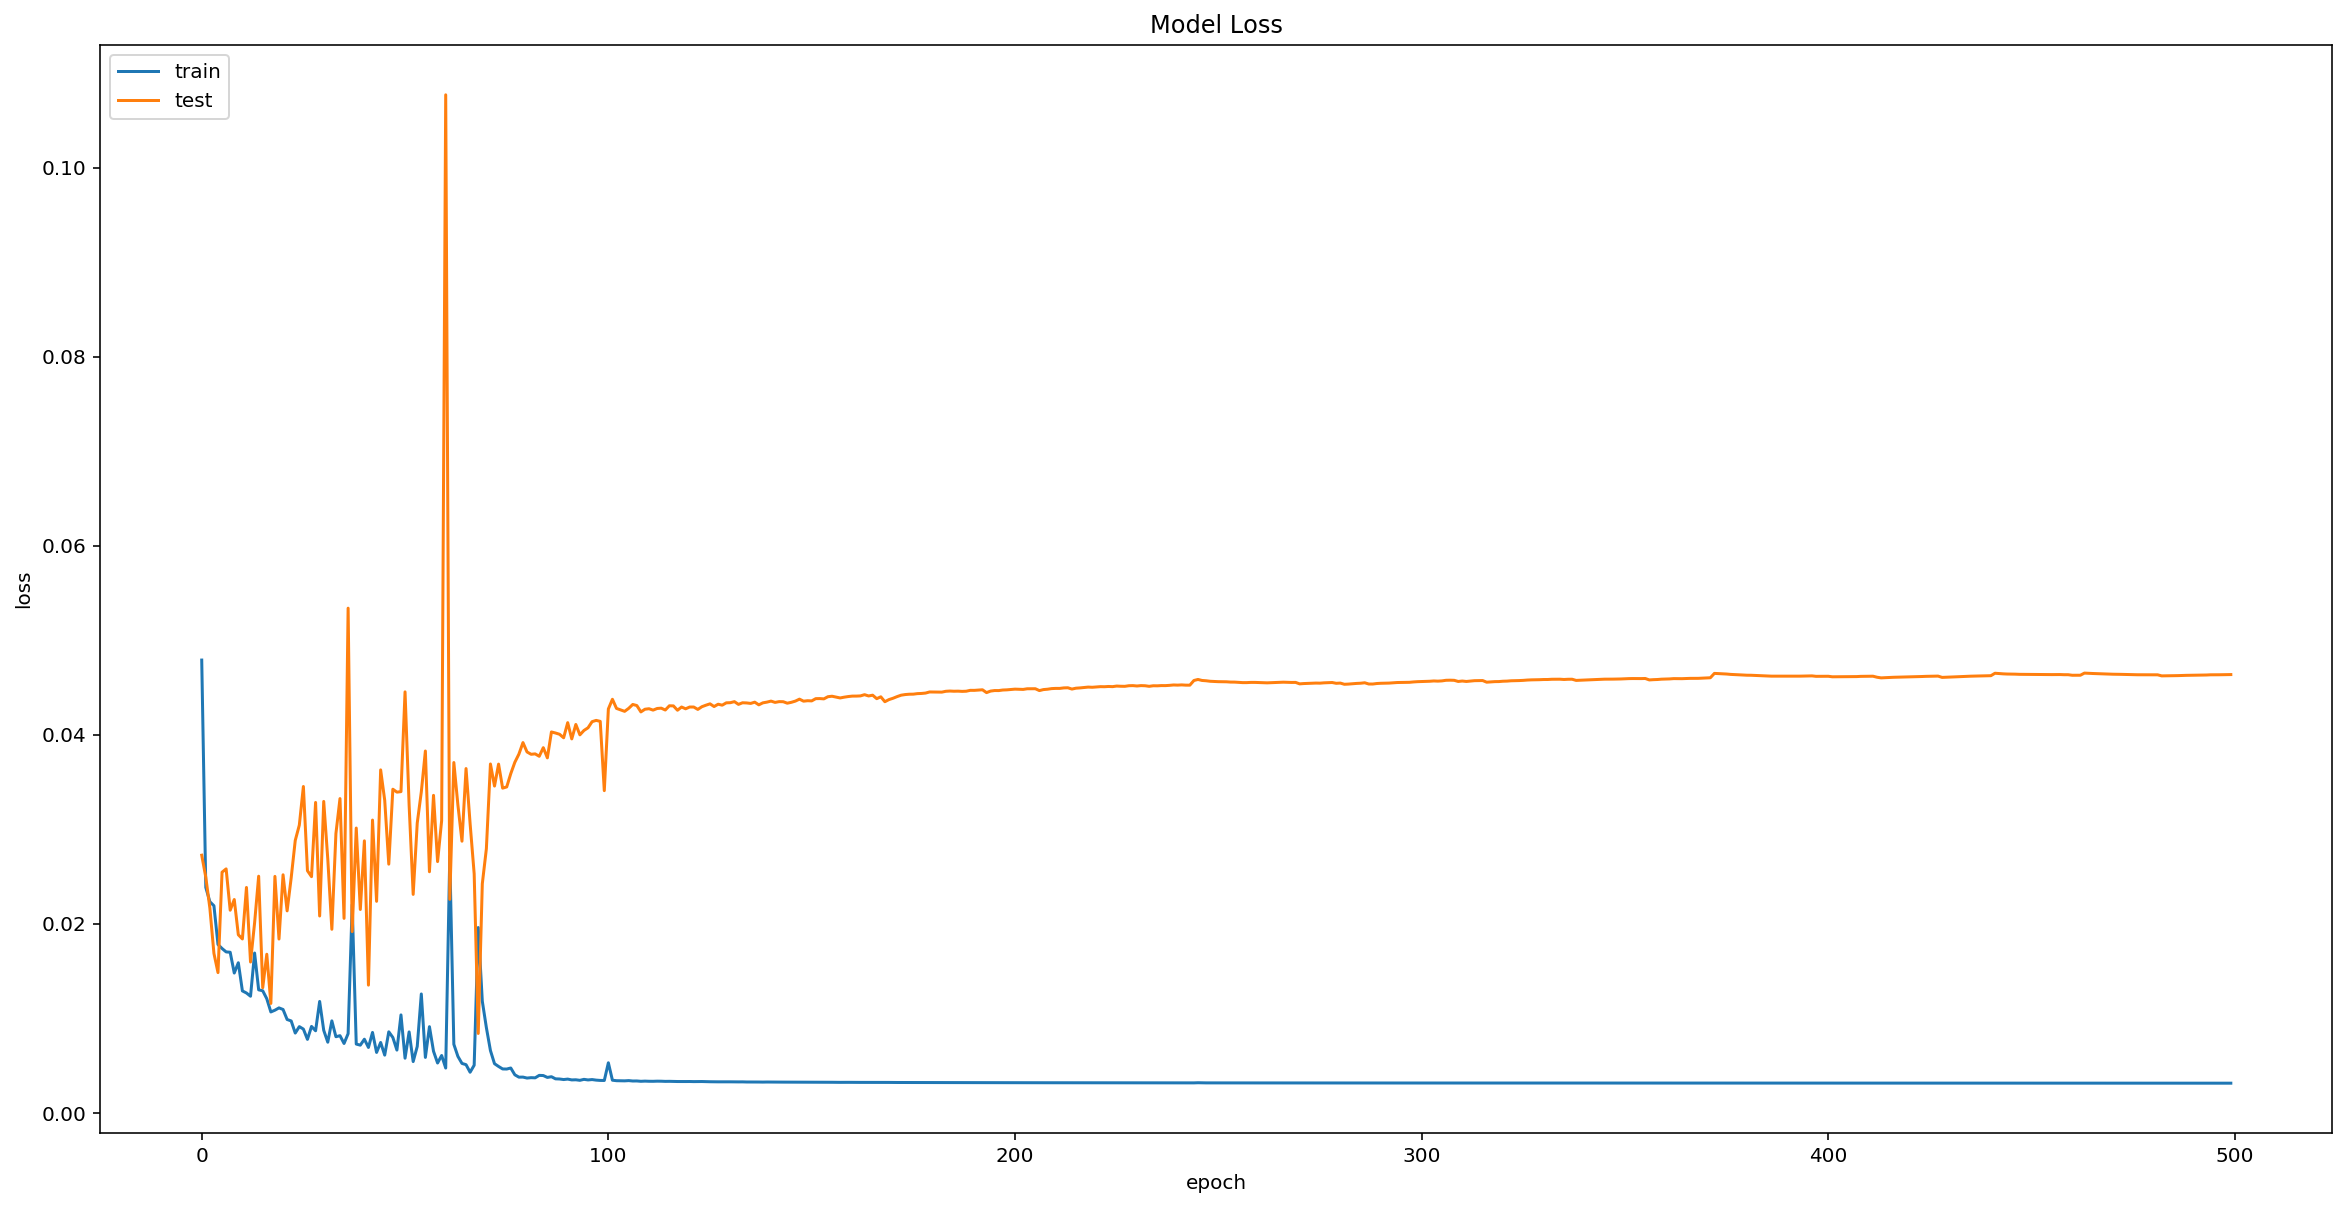

Memory Usage 1.16 MB
Time of Processing 17.65s
Accuracy 95.32%


In [61]:
show_info(model14, X_test_norm, y_test, keras_history14)

In [63]:
# Building the model 15
model15 = Sequential()
model15.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', bias_initializer='normal'))
model15.add(Dense(64, activation='tanh'))
model15.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
sgd15 = optimizers.SGD(lr=0.009)
model15.compile(loss = 'mean_squared_error', optimizer=sgd15, metrics=['accuracy'])
model15.summary()

# Training the model 15
keras_history15 = KerasHistory()
memory_usage = monitor(target=train(model15, X_train_norm, y_train, keras_history15, epochs=500, batch_size=15))
keras_history15.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_68 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/500
 - 0s - loss: 0.1527 - acc: 0.9151 - val_loss: 0.1136 - val_acc: 0.9625
Epoch 2/500
 - 0s - loss: 0.0970 - acc: 0.9465 - val_loss: 0.0854 - val_acc: 0.9625
Epoch 3/500
 - 0s - loss: 0.0761 - acc: 0.9591 - val_loss: 0.0718 - val_acc: 0.9750
Epoch 4/500
 - 0s - loss: 0.0650 - acc: 0.9591 - val_loss: 0.0638 - val_acc: 0.9625
Epoch 5/500
 - 0s - l

Epoch 89/500
 - 0s - loss: 0.0190 - acc: 0.9843 - val_loss: 0.0246 - val_acc: 0.9625
Epoch 90/500
 - 0s - loss: 0.0189 - acc: 0.9843 - val_loss: 0.0245 - val_acc: 0.9625
Epoch 91/500
 - 0s - loss: 0.0188 - acc: 0.9843 - val_loss: 0.0244 - val_acc: 0.9625
Epoch 92/500
 - 0s - loss: 0.0188 - acc: 0.9843 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 93/500
 - 0s - loss: 0.0187 - acc: 0.9843 - val_loss: 0.0243 - val_acc: 0.9625
Epoch 94/500
 - 0s - loss: 0.0186 - acc: 0.9843 - val_loss: 0.0242 - val_acc: 0.9625
Epoch 95/500
 - 0s - loss: 0.0186 - acc: 0.9843 - val_loss: 0.0241 - val_acc: 0.9625
Epoch 96/500
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0240 - val_acc: 0.9625
Epoch 97/500
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0239 - val_acc: 0.9625
Epoch 98/500
 - 0s - loss: 0.0185 - acc: 0.9843 - val_loss: 0.0239 - val_acc: 0.9625
Epoch 99/500
 - 0s - loss: 0.0184 - acc: 0.9843 - val_loss: 0.0238 - val_acc: 0.9625
Epoch 100/500
 - 0s - loss: 0.0183 - acc: 0.9843 - val_loss: 0.02

Epoch 185/500
 - 0s - loss: 0.0152 - acc: 0.9843 - val_loss: 0.0202 - val_acc: 0.9750
Epoch 186/500
 - 0s - loss: 0.0152 - acc: 0.9843 - val_loss: 0.0202 - val_acc: 0.9750
Epoch 187/500
 - 0s - loss: 0.0152 - acc: 0.9843 - val_loss: 0.0202 - val_acc: 0.9750
Epoch 188/500
 - 0s - loss: 0.0151 - acc: 0.9843 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 189/500
 - 0s - loss: 0.0151 - acc: 0.9843 - val_loss: 0.0201 - val_acc: 0.9750
Epoch 190/500
 - 0s - loss: 0.0151 - acc: 0.9843 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 191/500
 - 0s - loss: 0.0151 - acc: 0.9843 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 192/500
 - 0s - loss: 0.0151 - acc: 0.9843 - val_loss: 0.0204 - val_acc: 0.9750
Epoch 193/500
 - 0s - loss: 0.0150 - acc: 0.9843 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 194/500
 - 0s - loss: 0.0150 - acc: 0.9843 - val_loss: 0.0203 - val_acc: 0.9750
Epoch 195/500
 - 0s - loss: 0.0150 - acc: 0.9843 - val_loss: 0.0202 - val_acc: 0.9750
Epoch 196/500
 - 0s - loss: 0.0150 - acc: 0.9843 - val

Epoch 281/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0194 - val_acc: 0.9750
Epoch 282/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0194 - val_acc: 0.9750
Epoch 283/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 284/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 285/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 286/500
 - 0s - loss: 0.0131 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 287/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 288/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0192 - val_acc: 0.9750
Epoch 289/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0194 - val_acc: 0.9750
Epoch 290/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 291/500
 - 0s - loss: 0.0130 - acc: 0.9874 - val_loss: 0.0193 - val_acc: 0.9750
Epoch 292/500
 - 0s - loss: 0.0129 - acc: 0.9874 - val

Epoch 377/500
 - 0s - loss: 0.0116 - acc: 0.9874 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 378/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 379/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 380/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 381/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0199 - val_acc: 0.9750
Epoch 382/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 383/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 384/500
 - 0s - loss: 0.0115 - acc: 0.9874 - val_loss: 0.0200 - val_acc: 0.9750
Epoch 385/500
 - 0s - loss: 0.0114 - acc: 0.9874 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 386/500
 - 0s - loss: 0.0114 - acc: 0.9874 - val_loss: 0.0197 - val_acc: 0.9750
Epoch 387/500
 - 0s - loss: 0.0114 - acc: 0.9874 - val_loss: 0.0198 - val_acc: 0.9750
Epoch 388/500
 - 0s - loss: 0.0114 - acc: 0.9874 - val

Epoch 473/500
 - 0s - loss: 0.0104 - acc: 0.9874 - val_loss: 0.0227 - val_acc: 0.9625
Epoch 474/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0227 - val_acc: 0.9625
Epoch 475/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 476/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 477/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 478/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 479/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 480/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0229 - val_acc: 0.9625
Epoch 481/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0228 - val_acc: 0.9625
Epoch 482/500
 - 0s - loss: 0.0103 - acc: 0.9874 - val_loss: 0.0229 - val_acc: 0.9625
Epoch 483/500
 - 0s - loss: 0.0102 - acc: 0.9874 - val_loss: 0.0229 - val_acc: 0.9625
Epoch 484/500
 - 0s - loss: 0.0102 - acc: 0.9874 - val

## Treinamento 15
Para o treinamento 15 foram utilizados os seguintes hiperparametros:

Épocas = 500

Batchsize = 15

Taxa de Aprendizado = 0.009

A arquitetura ficou com uma camada de entrada, duas ocultas e uma de saída, sendo a primeira com 128 e a segunda com 64 e a camada de saída com dois neurônios. Na primeira utilizei a tangente hiperbólica e na segunda a sigmóide como função de ativação. Com uma taxa de aprendizado menor, o modelo converge mais lentamento, mas com um curva mais suave a tendência é maior de encontrar o mínimo global.

Nesse ciclo podemos observar os resultados abaixo:

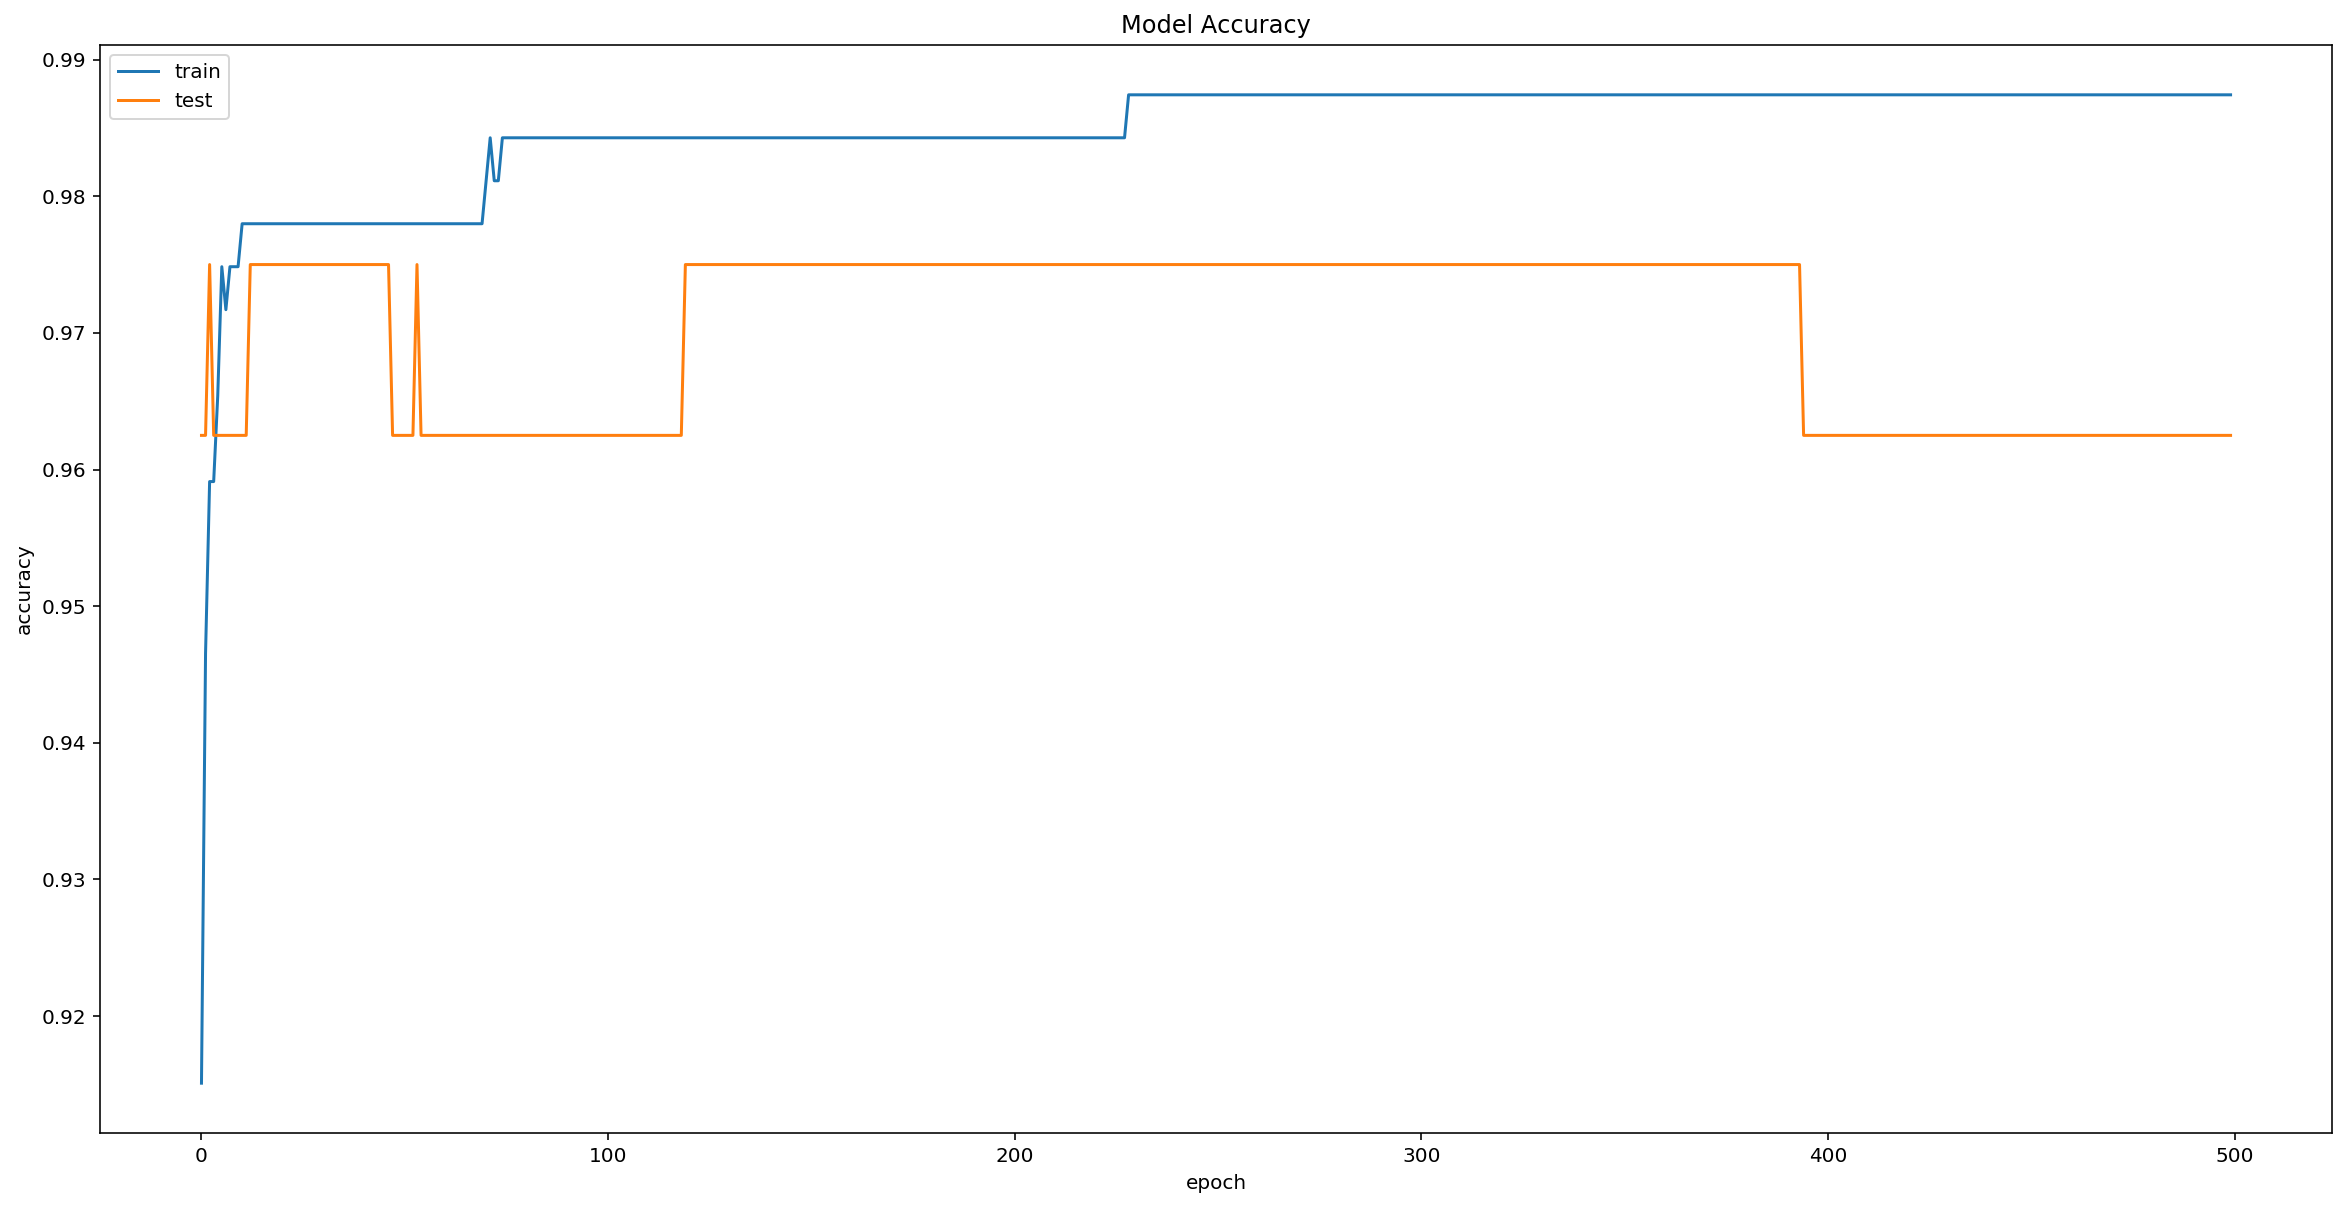

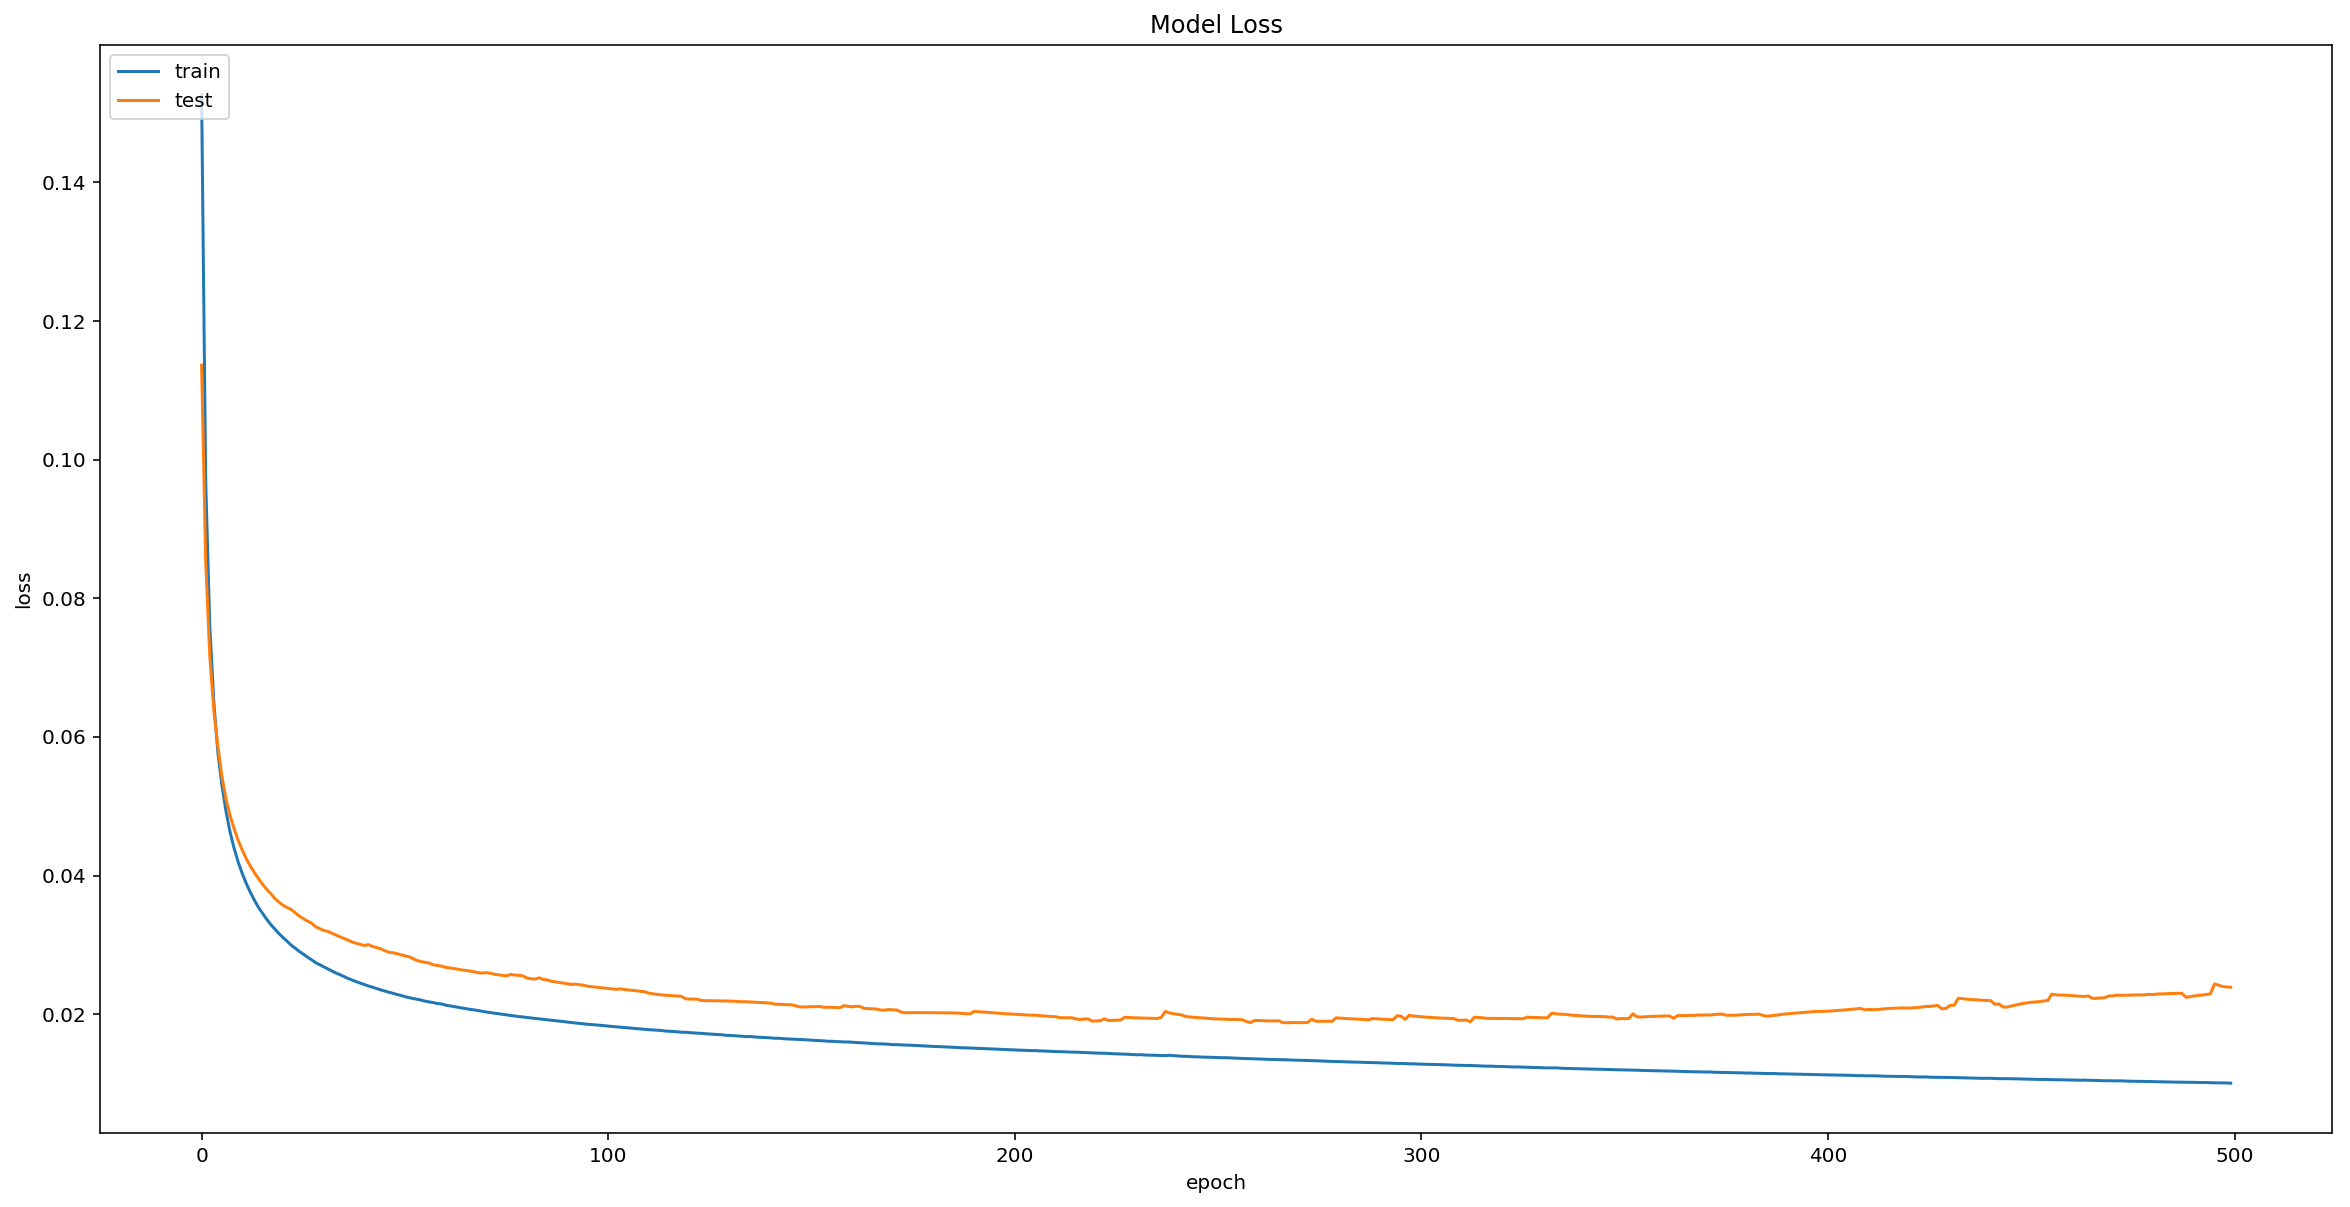

Memory Usage 1.91 MB
Time of Processing 18.23s
Accuracy 97.08%


In [64]:
show_info(model15, X_test_norm, y_test, keras_history15)

## Melhor modelo econtrado!!!

In [9]:
# Building the model best
model_best = Sequential()
model_best.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', activation='relu'))
model_best.add(Dropout(0.2))
model_best.add(Dense(128, kernel_initializer='random_uniform', activation='relu'))
model_best.add(Dropout(0.2))
model_best.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
optimizer = optimizers.RMSprop(lr=0.0001)
model_best.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_best.summary()

# Training the model best
keras_history_best = KerasHistory()
memory_usage = monitor(target=train(model_best, X_train_norm, y_train, keras_history_best, epochs=300, batch_size=10))
keras_history_best.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 20,609
Trainable params: 20,609
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/300
 - 0s - loss: 0.6657 - acc: 0.8050 - val_loss: 0.6278 - val_acc: 0.9375
Epoch 2/3

Epoch 86/300
 - 0s - loss: 0.0253 - acc: 0.9906 - val_loss: 0.0598 - val_acc: 0.9625
Epoch 87/300
 - 0s - loss: 0.0278 - acc: 0.9874 - val_loss: 0.0584 - val_acc: 0.9625
Epoch 88/300
 - 0s - loss: 0.0255 - acc: 0.9906 - val_loss: 0.0574 - val_acc: 0.9625
Epoch 89/300
 - 0s - loss: 0.0269 - acc: 0.9906 - val_loss: 0.0583 - val_acc: 0.9625
Epoch 90/300
 - 0s - loss: 0.0283 - acc: 0.9906 - val_loss: 0.0593 - val_acc: 0.9625
Epoch 91/300
 - 0s - loss: 0.0246 - acc: 0.9906 - val_loss: 0.0588 - val_acc: 0.9625
Epoch 92/300
 - 0s - loss: 0.0239 - acc: 0.9906 - val_loss: 0.0591 - val_acc: 0.9625
Epoch 93/300
 - 0s - loss: 0.0218 - acc: 0.9906 - val_loss: 0.0586 - val_acc: 0.9625
Epoch 94/300
 - 0s - loss: 0.0266 - acc: 0.9906 - val_loss: 0.0594 - val_acc: 0.9625
Epoch 95/300
 - 0s - loss: 0.0244 - acc: 0.9906 - val_loss: 0.0591 - val_acc: 0.9625
Epoch 96/300
 - 0s - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0596 - val_acc: 0.9625
Epoch 97/300
 - 0s - loss: 0.0204 - acc: 0.9937 - val_loss: 0.060

Epoch 182/300
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.1107 - val_acc: 0.9625
Epoch 183/300
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9625
Epoch 184/300
 - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9625
Epoch 185/300
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.1243 - val_acc: 0.9625
Epoch 186/300
 - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.1316 - val_acc: 0.9625
Epoch 187/300
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9625
Epoch 188/300
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9625
Epoch 189/300
 - 0s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.1186 - val_acc: 0.9625
Epoch 190/300
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1297 - val_acc: 0.9625
Epoch 191/300
 - 0s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.1252 - val_acc: 0.9625
Epoch 192/300
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9625
Epoch 193/300
 - 0s - loss: 0.0017 - acc: 1.0000 - val

Epoch 276/300
 - 0s - loss: 8.0460e-04 - acc: 1.0000 - val_loss: 0.2349 - val_acc: 0.9625
Epoch 277/300
 - 0s - loss: 3.5318e-04 - acc: 1.0000 - val_loss: 0.2297 - val_acc: 0.9625
Epoch 278/300
 - 0s - loss: 2.1650e-04 - acc: 1.0000 - val_loss: 0.2357 - val_acc: 0.9625
Epoch 279/300
 - 0s - loss: 3.3986e-04 - acc: 1.0000 - val_loss: 0.2392 - val_acc: 0.9625
Epoch 280/300
 - 0s - loss: 3.7791e-04 - acc: 1.0000 - val_loss: 0.2455 - val_acc: 0.9625
Epoch 281/300
 - 0s - loss: 1.8262e-04 - acc: 1.0000 - val_loss: 0.2548 - val_acc: 0.9625
Epoch 282/300
 - 0s - loss: 1.2331e-04 - acc: 1.0000 - val_loss: 0.2583 - val_acc: 0.9625
Epoch 283/300
 - 0s - loss: 6.3775e-04 - acc: 1.0000 - val_loss: 0.2630 - val_acc: 0.9625
Epoch 284/300
 - 0s - loss: 3.0835e-04 - acc: 1.0000 - val_loss: 0.2650 - val_acc: 0.9625
Epoch 285/300
 - 0s - loss: 2.9581e-04 - acc: 1.0000 - val_loss: 0.2643 - val_acc: 0.9625
Epoch 286/300
 - 0s - loss: 1.9716e-04 - acc: 1.0000 - val_loss: 0.2543 - val_acc: 0.9625
Epoch 287/

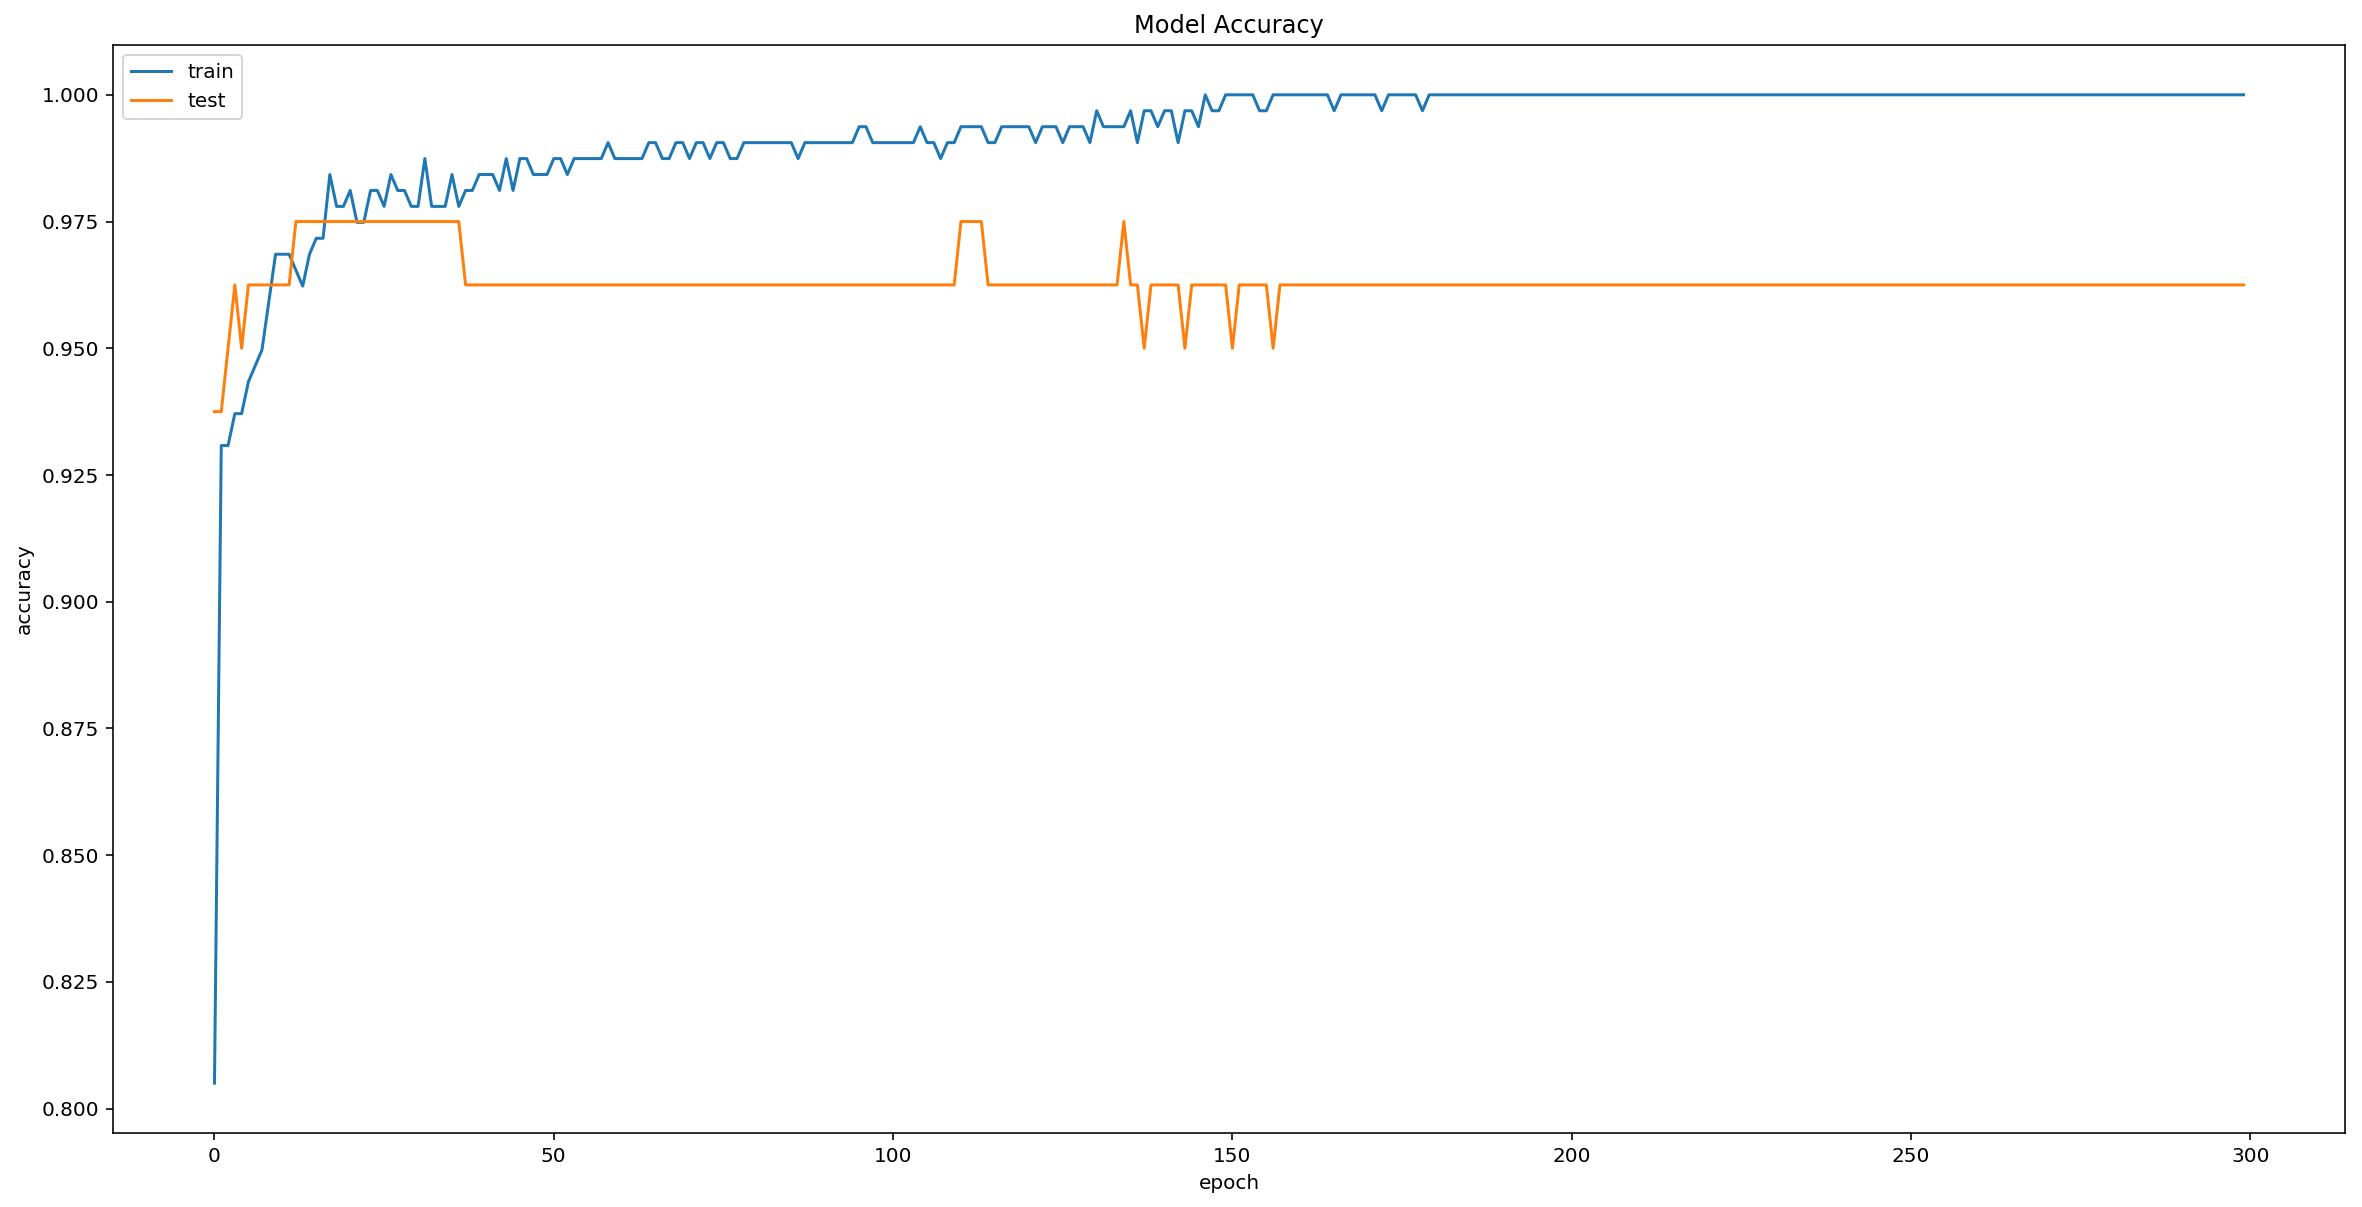

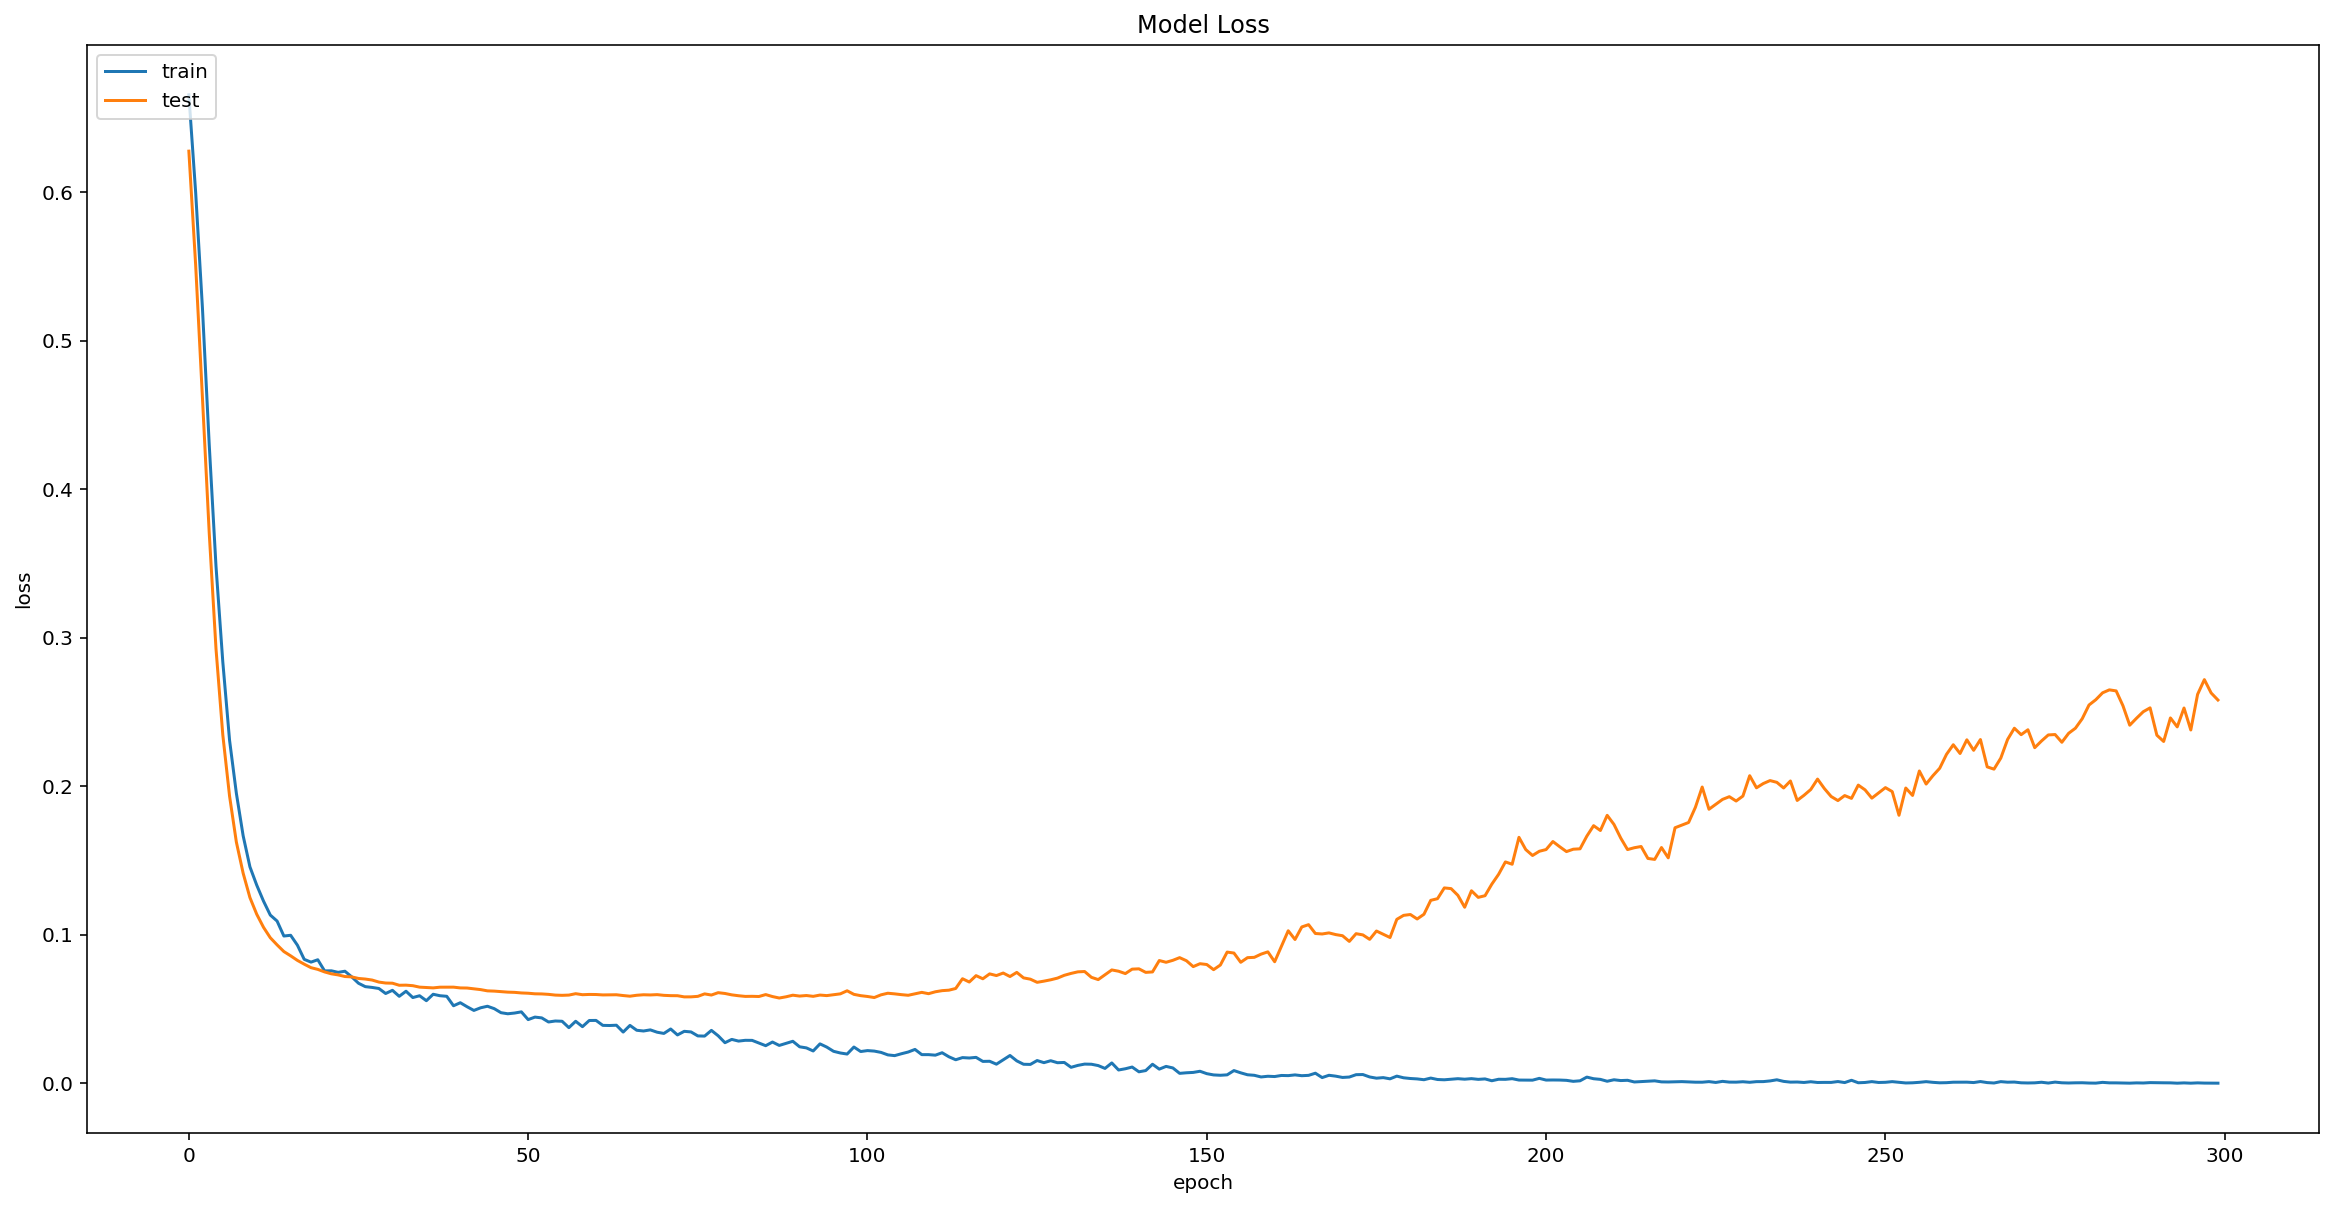

Memory Usage 1.20 MB
Time of Processing 23.68s
Accuracy 99.42%


In [10]:
show_info(model_best, X_test_norm, y_test, keras_history_best)